# -----
# FIG 8 in RECCAP SO paper
# -----
# also included: panel a of Fig. S12
# trends in simB are loaded from netcdf file produced by: PAPER_RECCAPv2_SO_Suppl_time_series_trends_simB.ipynb
#
# Plot time series of CO2 fluxes 
# drift-corrected
# 
# Contact: cara.nissen@awi.de or cara.nissen@colorado.edu
#
# version: August 2023
#

In [2]:
### modules
import os
import numpy as np
import seawater as sw
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm 
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from netCDF4 import Dataset
from datetime import date, timedelta
import copy
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature
from annualmean import annualmean
from datetime import date, timedelta
from sklearn.linear_model import LinearRegression
from mpl_toolkits.axes_grid.inset_locator import inset_axes
from scipy import signal # for detrending of time series

/tmp/ipykernel_459263/1677564082.py:23: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import inset_axes


In [3]:
#-----
# SETTINGS
# define paths to all data
# define where to save plots (if any)
# define years to average over
#-----

# data sets
path1 = '/pscratch/sd/c/cnissen/RECCAPv2/'
path_models = path1+'reccap_submissions/download_20220124/Models/2D_CO2/' 
path_data   = path1+'reccap_submissions/download_20220124/Surface_CO2/'
path_atminv = path1+'reccap_submissions/download_20220124/Atmospheric_inversions/'
path_soccom = path1+'reccap_submissions/download_20220124/Surface_CO2/'
path_trend  = path1+'reccap_submissions/download_20220124/Models/Linear_trends/' 

# river flux adjustment
path_river  = path1+'masks_reccap/river_flux_adjustment/'

# path to RECCAP SO mask
path_mask = path1+'masks_reccap/'

#----
# specify years to average over
#----
# NOTE: the script is written to plot the time series from 1985-2018
#    the years are defined here for plot titles and filenames 
year1,year2 = 1985,2018 
eval_time   = np.arange(year1,year2+1) 

#----
# define simulation
#----
sim = 'A'

#----
# define where to save plots
#----
save_to_dir ='/global/cfs/cdirs/m4003/cnissen/Plots/RECCAPv2_SO_Paper/Fig_8/'
if not os.path.exists(save_to_dir):
    print ('Created '+save_to_dir)
    os.makedirs(save_to_dir)
    

In [4]:
#-----
# define data sets to consider
#-----
# NOTE: there is 6 different atm. inversions in the provided file, only load the ones that start in 1990 
# NOTE: AOML has to be the first in the list! there is a few places where the exclusion of AOML is 
# hard-coded as "[1:]"

# variable name of interest
var = '2D_CO2'

models     = ('CCSM-WHOI','CESM-ETHZ','CNRM-ESM2-1','EC-Earth3','FESOM_REcoM_HR','FESOM_REcoM_LR',\
             'MOM6-Princeton','MPIOM-HAMOCC','MRI-ESM2-1','NorESM-OC1.2',\
             'ORCA025-GEOMAR','ORCA1-LIM3-PISCES','PlankTOM12','ROMS-SouthernOcean-ETHZ') 
models2     = ('CCSM-WHOI','CESM-ETHZ','CNRM-ESM2-1','EC-Earth3','FESOM_REcoM_HR','FESOM_REcoM_LR',\
             'MOM6-Princeton','MPIOM-HAMOCC','MRI-ESM2-1','NorESM-OC1.2',\
             'ORCA025-GEOMAR','ORCA1-LIM3-PISCES','PlankTOM12','ROMS-SO-ETHZ') 
ind_mpi = models.index("MPIOM-HAMOCC")
ind_not_mpi = [i for i, s in enumerate(models) if 'MPIOM-HAMOCC' not in s]
print ('Index of MPI:',ind_mpi)
print ('All inidces except MPI:',ind_not_mpi)
data_assim  = ('BSOSE','ECCO-Darwin')
data_ocim   = ('OCIM-v2014-CTL','OCIM-v2021')
#data_atminv = ['Atm_inv1','Atm_inv2','Atm_inv4']  #'Atm_inv3','Atm_inv5','Atm_inv6' -> start later than 1990
data_atminv = ['Atm_inv1','Atm_inv2','Atm_inv3','Atm_inv4','Atm_inv5','Atm_inv6'] # for 2015-2018, consider all 6
data_prod   = ('AOML_EXTRAT','CMEMS-LSCE-FFNN','CSIRML6','JenaMLS','JMAMLR',\
             'LDEO-HPD','NIES-ML3','OceanSODAETHZ','SOMFFN') 
data_watson = ['UOEX_Wat20']
soccom      = ('SOCCOM_Jena','SOCCOM_SOMFFN')

versionID_models     = ('20211125','v20211122','v20211208','v20220323','v20211119','v20211119',\
                       'v20220125','v20220110','v20220502','v20211125',\
                       'v20210804','v20211215','v20220404','v20220630') 
versionID_data_assim  = ('I134','v20210712')
versionID_data_ocim   = ('v20210607','v20210511')
versionID_data_atminv = ['v20211008']
versionID_data_prod   = ('v20211130','v20210709','v20211117','v20211126','v20211208',\
                       'v20211210','v20220222','v20211207','v20211121')
versionID_data_watson = ['v20211204']

# list of filenames for data products
filename_data_prod = ('fgco2_AOML_EXTRAT_1997-2020_v20211018.nc4',\
                      'fgco2_CMEMS-LSCE-FFNN_1985-2018_v20210709.nc',\
                      'fgco2_CSIRML6_1985-2018_v20211117.nc',\
                      'fgco2_JenaMLS_1985-2018_v20211126.nc',\
                      'fgco2_JMAMLR_1985-2019_v20211208.nc',\
                      'fgco2_LDEO_HPD_1985-2018_v20211210.nc',\
                      'fgco2_NIES-ML3_1980-2020_v20220222.nc',\
                      'fgco2_OceanSODAETHZ_1985-2018_v20211207.nc',\
                      'fgco2_MPI_SOMFFN_1982-2019_v20211121.nc')
filename_data_watson = ['fgco2_UOEX_Wat20_1985-2019_v20211204.nc']

subregions = ('STSS-Atl','STSS-Ind','STSS-Pac',\
              'SPSS-Atl','SPSS-Ind','SPSS-Pac',\
              'ICE-Atl','ICE-Ind','ICE-Pac','STSS','SPSS','ICE','all')   

print ('Models:',len(models),len(versionID_models))
print ('Data products:',len(data_prod),len(filename_data_prod))
print ('Data Watson2020:',len(data_watson),len(versionID_data_watson))
print ('Data assimilating models:',len(data_assim),len(versionID_data_assim))
print ('Data OCIM:',len(data_ocim),len(versionID_data_assim))
print ('Data ATM inversion:',len(data_atminv),len(versionID_data_atminv))


Index of MPI: 7
All inidces except MPI: [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13]
Models: 14 14
Data products: 9 9
Data Watson2020: 1 1
Data assimilating models: 2 2
Data OCIM: 2 2
Data ATM inversion: 6 1


In [5]:
#----
# FUNCTIONS
#----

# transform longitude (e.g., go from -179.5:179.5 to 0.5:359.5)
def transform_lon_coord(data):
    # change lon coordinate in 2D array from 0-360 to -180:180
    # for 2D arrays: assume lon coordinate to be the 2nd dimension  
    # for 3D arrays: assume lon coordinate to be the 3rd dimension  
    if len(data.shape)==2:
        data_transformed          = np.empty_like(data)
        data_transformed[:,0:180] = data[:,180:]
        data_transformed[:,180:]  = data[:,0:180] 
    elif len(data.shape)==3:
        data_transformed          = np.empty_like(data)
        try:
            data_transformed[:,:,0:180] = data[:,:,180:]
            data_transformed[:,:,180:]  = data[:,:,0:180]
        except:
            data_transformed[:,0:180,:] = data[:,180:,:]
            data_transformed[:,180:,:]  = data[:,0:180,:] 
    elif len(data.shape)==4:
        data_transformed          = np.empty_like(data)
        data_transformed[:,0:180,:,:] = data[:,180:,:,:]
        data_transformed[:,180:,:,:]  = data[:,0:180,:,:] 
    elif len(data.shape)==1:
        data_transformed          = np.empty_like(data)
        data_transformed[0:180] = data[180:]
        data_transformed[180:]  = data[0:180]
    return data_transformed


In [6]:
#------
# load RECCAP mask for SO
# make sure region mask matches the submitted products in terms of longitude!
#------

# SO RECCAP regions
#reccap_mask_SO   = Dataset(path_mask+'RECCAP2_region_masks_all_v20221025.nc')
#regions          = reccap_mask_SO_2.variables['southern'][:,:] #"1.SO STSS, 2.SO SPSS, 3.SO ICE"
#lon_regions      = reccap_mask_SO_2.variables['lon'][:]
#print(np.min(lon_regions),np.max(lon_regions)) # lon should be from 0-360 (if it is from -180:180, use transform_lon_coord)
#print(np.min(regions_2),np.max(regions_2))

# SO RECCAP regions
reccap_mask_SO = Dataset(path_mask+'reccap_regions_SOsubs.nc')
regions        = reccap_mask_SO.variables['SO_basins_biomes'][:,:]
lon_regions    = reccap_mask_SO.variables['lon'][:]
print(np.min(lon_regions),np.max(lon_regions)) # lon should be from 0-360 (if it is from -180:180, use transform_lon_coord)

# lon in file is -180:180 -> want 0-360, so transform here
regions = transform_lon_coord(regions)
print(np.min(regions),np.max(regions))


-179.5 179.5
0.0 8.0


In [7]:
#-----
# load data
#-----
      
years_in_file = np.arange(1980,2018+1)

#-----
# atmospheric inversion
#-----
flux_atminv = np.nan*np.ones([180,360,len(eval_time),len(data_atminv)])
for ii in range(0,len(data_atminv)):
    print ('Load '+data_atminv[ii])
    ff = Dataset(path_atminv+'GCP2021_inversions_for_RECCAP2_1x1_version1_1_20211122.nc') 
    # this file contains 6 products!
    data = np.squeeze(ff.variables['ocean_flux_NOT_adjusted'][ii,:,:,:]) # 1990-2020, .mean(axis=0)
    data = data[:-24,:,:] # kick out 2019 & 2020
    data = annualmean(data)
    data = np.transpose(data,[1,2,0]) # time is last
    print (data.shape)
    try: 
        data[data.mask==True]=np.nan
    except: 
        pass
    data[data==0]=np.nan # set land to NaN
    flux_atminv[:,:,5:,ii] = data
    print ('Change sign')
    flux_atminv[:,:,:,ii] = -1*flux_atminv[:,:,:,ii]
    ff.close()
    del data
print ('Transform longitude to 0:360')
flux_atminv = transform_lon_coord(flux_atminv)
    
        
#-----
# models
#-----
flux_models = np.nan*np.ones([180,360,len(eval_time),len(models)])
for ii in range(0,len(models)):
    print ('Load '+models[ii])
    ff = Dataset(path_models+models[ii]+'_'+var+'_'+versionID_models[ii]+'/'+\
                    'fgco2_'+models[ii]+'_'+sim+'_1_gr_1980-2018_'+versionID_models[ii]+'.nc')
    data = np.squeeze(ff.variables['fgco2'][:,:,:])
    data = annualmean(data)
    if models[ii] in ['CCSM-WHOI']: # kick out years 1958-1979
        data = -1*data[22:,:,:] # flip sign
    print (data.shape)
    if models[ii] in ['MPIOM-HAMOCC']: # kick out 2019
        data = data[:-1,:,:]
    try: 
        data[data.mask==True]=np.nan
    except: 
        pass
    data[data==0]=np.nan
        
    # find position into which to write annual means (depends on years provided in submission)
    if models[ii] in ['OCIM-v2014-CTL','CCSM-WHOI']: # these ones stop in 2017
        start_ind = np.where(np.asarray(years_in_file)==year1)[0][0]
        end_ind   = np.argmin(np.abs(eval_time-2017)) 
    else:
        start_ind = np.where(np.asarray(years_in_file)==year1)[0][0]
        end_ind   = np.where(np.asarray(years_in_file)==year2)[0][0]
        
    data = np.transpose(data,[1,2,0])
    if models[ii] in ['OCIM-v2014-CTL','CCSM-WHOI']:
        flux_models[:,:,:end_ind+1,ii] = data[:,:,start_ind:]
    else: 
        flux_models[:,:,:,ii] = data[:,:,start_ind:end_ind+1] #np.nanmean(data,axis=0)
    ff.close()
    del data
    
#-----
# OCIM
#-----
flux_ocim = np.nan*np.ones([180,360,len(eval_time),len(data_ocim)])
for ii in range(0,len(data_ocim)):
    print ('Load '+data_ocim[ii])
    ff = Dataset(path_models+data_ocim[ii]+'_'+var+'_'+versionID_data_ocim[ii]+'/'+\
                    'fgco2_'+data_ocim[ii]+'_'+sim+'_1_gr_1980-2018_'+versionID_data_ocim[ii]+'.nc')
    data = np.squeeze(ff.variables['fgco2'][:,:,:])
    data = annualmean(data)
    try: 
        data[data.mask==True]=np.nan
    except: 
        pass
    # find position into which to write annual means (depends on years provided in submission)
    if data_ocim[ii] in ['OCIM-v2014-CTL']:
        start_ind = np.where(np.asarray(years_in_file)==year1)[0][0]
        end_ind   = np.argmin(np.abs(eval_time-2017)) 
    else:
        start_ind = np.where(np.asarray(years_in_file)==year1)[0][0]
        end_ind   = np.where(np.asarray(years_in_file)==year2)[0][0]
        
    data = np.transpose(data,[1,2,0])
    if data_ocim[ii] in ['OCIM-v2014-CTL']:
        flux_ocim[:,:,:end_ind+1,ii] = data[:,:,start_ind:]
    else: 
        flux_ocim[:,:,:,ii] = data[:,:,start_ind:end_ind+1] #np.nanmean(data,axis=0)
    ff.close()
    del data
        
#-----
# data products
#-----
flux_data_products = np.nan*np.ones([180,360,len(eval_time),len(data_prod)])
for ii in range(0,len(data_prod)):
    print ('Load '+data_prod[ii])
    ff = Dataset(path_data+data_prod[ii]+'_'+versionID_data_prod[ii]+'/'+\
                    filename_data_prod[ii])
    data = np.squeeze(ff.variables['fgco2'][:,:,:])
    if data_prod[ii] in ['AOML_RANDOMF','AOML_EXTRAT']: # get starting time of this product 
        # -> to get rid of incomplete year in beginning
        time = np.squeeze(ff.variables['time'][:])
        day = time[0]
        start = date(1980,1,1)      # This is the "days since" part
        delta = timedelta(day)     # Create a time delta object from the number of days
        offset = start + delta      # Add the specified number of days to 1990
        print(offset)               # >>>  2015-12-01
        del time,day,start,delta,offset
        # delete first 4 entries!
        data = data[4:,:,:]
        #data = data[:-24,:,:] # kick out 2019 & 2020
            
    if data_prod[ii] in ['NIES-ML3']: # reorganize dimensions to math the others
        data = np.transpose(data,[2,1,0])
    if data_prod[ii] in ['SOMFFN']: # reorganize dimensions to math the others
        data = np.transpose(data,[2,1,0])
        data = data[3*12:,:,:] # kick out 1982-1984
    if data_prod[ii] in ['JMAMLR','NIES-ML3']: 
        data = data[5*12:,:,:] # kick out 1980-1984 (filename suggests it starts in 1985, but timedim suggests otherwise)
    if data_prod[ii] in ['JMAMLR','NIES-nn','CSIRML6','SOMFFN']: # 1985-2019
        data = data[:-12,:,:] # kick out 2019
    if data_prod[ii] in ['NIES-ML3']: # 1985-2020
        data = data[:-24,:,:] # kick out 2019 & 2020
    if data_prod[ii] in ['NIES-nn','NIES-ML3']: # mask missing values
        data[data<-9999999]=np.nan
        
    data = annualmean(data)
    print (data.shape)
    data = np.transpose(data,[1,2,0]) # time is last
        
    if data_prod[ii] in ['AOML_RANDOMF','AOML_EXTRAT']: #1997-2020 in file, but 280 months -> 2020 not complete? 
        # it is 1998-2020
        data = data[:,:,:-2] # kick out 2019 & 2020
        years_in_file2 = np.arange(1998,2018+1)
        start_ind = np.where(np.asarray(eval_time)==years_in_file2[0])[0][0]
        flux_data_products[:,:,start_ind:,ii] = data
        del years_in_file2,start_ind
    else: 
        flux_data_products[:,:,:,ii] = data
             
    # for some products, change sign so that pos=into ocean
    if data_prod[ii] in ['NIES-nn']:
        print ('Change sign')
        flux_data_products[:,:,:,ii] = -1*flux_data_products[:,:,:,ii] 
    ff.close()
    del data

#-----
# data Watson2020
#-----
flux_data_watson = np.nan*np.ones([180,360,len(eval_time),len(data_watson)])
for ii in range(0,len(data_watson)):
    print ('Load '+data_watson[ii])
    ff = Dataset(path_data+data_watson[ii]+'_'+versionID_data_watson[ii]+'/'+\
                    filename_data_watson[ii])
    ind_start_watson = 12*3 # skip first three years, i.e. 1985-1987 (wind climatology is used)
    data = np.squeeze(ff.variables['fgco2'][ind_start_watson:,:,:]) 
    data = annualmean(data)
    data = np.transpose(data,[1,2,0]) # time is last
    if data_watson[ii] in ['UOEX_Wat20']: # 1985-2019
        data = data[:,:,:-1]
        ind_start_watson = 3 # here, only annual
        flux_data_watson[:,:,ind_start_watson:,ii] = data
    ff.close()
    del data
     
#-----
# data-assimilating models 
#-----
flux_data_assim = np.nan*np.ones([180,360,len(eval_time),len(data_assim)])
for ii in range(0,len(data_assim)):
    print ('Load '+data_assim[ii])
    ff = Dataset(path_models+data_assim[ii]+'_'+var+'_'+versionID_data_assim[ii]+'/'+\
                    'fgco2_'+data_assim[ii]+'_'+sim+'_1_gr_1980-2018_'+versionID_data_assim[ii]+'.nc')
    data = np.squeeze(ff.variables['fgco2'][:,:,:])
    if data_assim[ii] in ['ECCO-Darwin']: # transform longitudes
        data = transform_lon_coord(data) 
    data = annualmean(data)
    data = np.transpose(data,[1,2,0]) # time is last
    if data_assim[ii] in ['BSOSE']: #2013-2019
        data = data[:,:,:-1] # kick out 2019
        years_in_file2 = np.arange(2013,2018+1)
        start_ind = np.where(np.asarray(eval_time)==years_in_file2[0])[0][0]
        flux_data_assim[:,:,start_ind:,ii] = data
        del years_in_file2,start_ind
    elif data_assim[ii] in ['ECCO-Darwin']: #1985-2018
        start_ind = np.argmin(np.abs(eval_time-1995)) 
        flux_data_assim[:,:,start_ind:,ii] = data[:,:,:]
        del start_ind
    # for some products, change sign so that pos=into ocean
    if data_assim[ii] in ['BSOSE']:
        print ('Change sign')
        flux_data_assim[:,:,:,ii] = -1*flux_data_assim[:,:,:,ii] 
    ff.close()
    del data
    
    

Load Atm_inv1
(180, 360, 29)
Change sign
Load Atm_inv2
(180, 360, 29)
Change sign
Load Atm_inv3
(180, 360, 29)
Change sign
Load Atm_inv4
(180, 360, 29)
Change sign
Load Atm_inv5
(180, 360, 29)
Change sign
Load Atm_inv6
(180, 360, 29)
Change sign
Transform longitude to 0:360
Load CCSM-WHOI
(38, 180, 360)
Load CESM-ETHZ
(39, 180, 360)
Load CNRM-ESM2-1
(39, 180, 360)
Load EC-Earth3
(39, 180, 360)
Load FESOM_REcoM_HR


/global/u2/c/cnissen/scripts_reccap/annualmean.py:43: RuntimeWarning: Mean of empty slice
  var_annualmean[t,:,:] = np.nanmean(datamB, axis=0)


(39, 180, 360)
Load FESOM_REcoM_LR
(39, 180, 360)
Load MOM6-Princeton
(39, 180, 360)
Load MPIOM-HAMOCC
(40, 180, 360)
Load MRI-ESM2-1
(39, 180, 360)
Load NorESM-OC1.2
(39, 180, 360)
Load ORCA025-GEOMAR
(39, 180, 360)
Load ORCA1-LIM3-PISCES
(39, 180, 360)
Load PlankTOM12
(39, 180, 360)
Load ROMS-SouthernOcean-ETHZ
(39, 180, 360)
Load OCIM-v2014-CTL
Load OCIM-v2021
Load AOML_EXTRAT
1997-09-15
(23, 180, 360)
Load CMEMS-LSCE-FFNN
(34, 180, 360)
Load CSIRML6
(34, 180, 360)
Load JenaMLS
(34, 180, 360)
Load JMAMLR
(34, 180, 360)
Load LDEO-HPD
(34, 180, 360)
Load NIES-ML3


/tmp/ipykernel_459263/243556053.py:109: UserWarning: WARNING: _FillValue not used since it
cannot be safely cast to variable data type
  data = np.squeeze(ff.variables['fgco2'][:,:,:])


(34, 180, 360)
Load OceanSODAETHZ
(34, 180, 360)
Load SOMFFN
(34, 180, 360)
Load UOEX_Wat20
Load BSOSE
Change sign
Load ECCO-Darwin


In [8]:
#----
# load SOCCOM files from Seth
#----

ff = Dataset(path_soccom+'RECCAP_regrid_Jena_CS.nc')
soccom1 = ff.variables['F_CO2'][:] 
time1 = ff.variables['time'][:] # starts in Jan 1957, ends in Dec 2020
ff.close()
ff = Dataset(path_soccom+'RECCAP_regrid_SOM_FFN.nc')
soccom2 = ff.variables['F_CO2'][:]
time2 = ff.variables['time'][:] # starts in Jan 1982, ends in Dec 2019
ff.close()
print (soccom1.shape,soccom2.shape)

start = date(1950,1,1)      # This is the "days since" part
offset1 = start + timedelta(time1[0])      # Add the specified number of days to 1990
offset2 = start + timedelta(time2[0])      # Add the specified number of days to 1990
print(offset1,offset2) 

end1 = start + timedelta(time1[-1])      # Add the specified number of days to 1990
end2 = start + timedelta(time2[-1])      # Add the specified number of days to 1990
print(end1,end2) 

# reduce data to Jan-1985 until Dec-2018
soccom1 = soccom1[(28)*12:-24,:,:]
soccom2 = soccom2[(3)*12:-12,:,:]
print (soccom1.shape,soccom2.shape )

# avg over the chosen season
soccom1 = annualmean(-1*soccom1) # CHANGE SIGN
soccom2 = annualmean(-1*soccom2)

soccom_all = np.stack((soccom1,soccom2))
print(soccom_all.shape)

#np.nan*np.ones([180,360,len(eval_time),len(data_assim)])
flux_soccom = np.transpose(soccom_all,[2,3,1,0])
print (flux_soccom.shape)



(768, 180, 360) (456, 180, 360)
1957-01-15 1982-01-15
2020-12-15 2019-12-15
(408, 180, 360) (408, 180, 360)
(2, 34, 180, 360)
(180, 360, 34, 2)


In [9]:
#------
# print some numbers (to spot any obvious unit problems)
#------

for ii in range(0,len(soccom)):
    print (soccom[ii]+': '+str(np.nanmin(flux_soccom[:,:,:,ii]))+' '+str(np.nanmax(flux_soccom[:,:,:,ii])))
        
for ii in range(0,len(models)):
    print (models[ii]+': '+str(np.nanmin(flux_models[:,:,:,ii]))+' '+str(np.nanmax(flux_models[:,:,:,ii])))

for ii in range(0,len(data_ocim)):
    print (data_ocim[ii]+': '+str(np.nanmin(flux_ocim[:,:,:,ii]))+' '+str(np.nanmax(flux_ocim[:,:,:,ii])))

for ii in range(0,len(data_prod)):
    print (data_prod[ii]+': '+str(np.nanmin(flux_data_products[:,:,:,ii]))+' '+str(np.nanmax(flux_data_products[:,:,:,ii])))

for ii in range(0,len(data_watson)):
    print (data_watson[ii]+': '+str(np.nanmin(flux_data_watson[:,:,:,ii]))+' '+str(np.nanmax(flux_data_watson[:,:,:,ii])))

for ii in range(0,len(data_assim)):
    print (data_assim[ii]+': '+str(np.nanmin(flux_data_assim[:,:,:,ii]))+' '+str(np.nanmax(flux_data_assim[:,:,:,ii])))

for ii in range(0,len(data_atminv)):
    print (data_atminv[ii]+': '+str(np.nanmin(flux_atminv[:,:,:,ii]))+' '+str(np.nanmax(flux_atminv[:,:,:,ii])))


SOCCOM_Jena: -1.9408281820965678e-07 3.408697509806508e-07
SOCCOM_SOMFFN: -1.8549687532292555e-07 2.2637804079616248e-07
CCSM-WHOI: -3.328032391891611e-07 2.3799766779575293e-07
CESM-ETHZ: -1.8722379024893598e-07 1.8758713338229427e-07
CNRM-ESM2-1: -3.473808677055083e-07 7.243008834001572e-07
EC-Earth3: -3.455088517512195e-07 2.9743890195277345e-07
FESOM_REcoM_HR: -1.0287609477898954e-06 3.291037252258339e-07
FESOM_REcoM_LR: -5.16851747625652e-07 3.551971909955131e-07
MOM6-Princeton: -6.316397609341927e-07 8.285434885537167e-07
MPIOM-HAMOCC: -2.1326543730992853e-07 2.601472033347818e-07
MRI-ESM2-1: -6.728191124238947e-07 2.867927548777516e-07
NorESM-OC1.2: -3.108359862835641e-07 3.516230151490163e-07
ORCA025-GEOMAR: -5.994956284336938e-07 3.7668123493913067e-07
ORCA1-LIM3-PISCES: -4.1642874748504255e-07 2.7747370268116356e-07
PlankTOM12: -4.364177641491551e-07 1.7493054826900334e-07
ROMS-SouthernOcean-ETHZ: -2.626861999033281e-07 4.0850900973055104e-07
OCIM-v2014-CTL: -5.43813831818880

In [10]:
#------
# get surface area of all the biomes
#------
# calculate area with sw.dist

def get_areas_biomes(area,regions,subregions):
    # calculate area-weighted averages of a given quantity in data according to biomes defined
    # after Fay & McKinley (2014), use RECCAP mask loaded further up
    # provide "area" (with lon from 0:360)
    
    # only consider area for SO RECCAP mask
    area[regions.mask==True]=0
    print ('Total Southern Ocean ocean surface area '+str(np.nansum(area))+' m2')
    
    data_avg = np.zeros(13) # 9 regions in SO, + 3 for combined sectors, +1 for whole SO
    for i in range(0,13):
        reg2  = regions.ravel()
        area2 = area.ravel()
        if subregions[i] in ['STSS-Atl']:
            ind_region = np.where(reg2==0)[0]
        elif subregions[i] in ['STSS-Ind']:
            ind_region = np.where(reg2==3)[0]
        elif subregions[i] in ['STSS-Pac']:
            ind_region = np.where(reg2==6)[0]
        elif subregions[i] in ['SPSS-Atl']:
            ind_region = np.where(reg2==1)[0]
        elif subregions[i] in ['SPSS-Ind']:
            ind_region = np.where(reg2==4)[0]
        elif subregions[i] in ['SPSS-Pac']:
            ind_region = np.where(reg2==7)[0]
        elif subregions[i] in ['ICE-Atl']:
            ind_region = np.where(reg2==2)[0]
        elif subregions[i] in ['ICE-Ind']:
            ind_region = np.where(reg2==5)[0]
        elif subregions[i] in ['ICE-Pac']:
            ind_region = np.where(reg2==8)[0]
        elif subregions[i] in ['STSS']:
            ind_region = np.where((reg2==0) | (reg2==3) | (reg2==6))[0]
        elif subregions[i] in ['SPSS']:
            ind_region = np.where((reg2==1) | (reg2==4) | (reg2==7))[0]
        elif subregions[i] in ['ICE']:
            ind_region =np.where((reg2==2) | (reg2==5) | (reg2==8))[0]
        elif subregions[i] in ['all']:
            ind_region = np.where(reg2>=0)[0]
        data_avg[i] = np.nansum(area2[ind_region]) #np.nansum(data2[ind_region]*area2[ind_region]/total_area)
        del reg2, area2,ind_region
    return data_avg

# define for filtering, but don't use for area calculation
lon = np.arange(0.5,359.5+1,1)
lat = np.arange(-89.5,89.5+1,1)

# need the box boundaries for area calculation
xi = np.arange(0,360+1,1)
yi = np.arange(-90,90+1,1) 

area = np.zeros((len(xi)-1,len(yi)-1))
#calculate area
for i in range(0,len(xi)-1): #laenge pruefen!
    if i==np.round(len(xi)/2): 
        print ('50% done')
    for j in range(0,len(yi)-1): 
        dist1 = sw.dist([yi[j],yi[j+1]],[xi[i],xi[i]])
        dist2 = sw.dist([yi[j],yi[j]],[xi[i],xi[i+1]])
        area[i][j] = float(dist1[0]) * float(dist2[0]) *1000 *1000 #m2
area = area.transpose()
print ('Global area:',np.sum(area),'m2') 
area_global = np.copy(area)

area_biomes = get_areas_biomes(area,regions,subregions)

#print (area_biomes)
print('TEST: the following three should be identical')
print (np.sum(area_biomes[0:9])) # 9 subregions
print (np.sum(area_biomes[9:12])) # 3 subregions
print (np.sum(area_biomes[12])) # 1 subregion 


50% done
Global area: 509364377985322.94 m2
Total Southern Ocean ocean surface area 77409028462219.4 m2
TEST: the following three should be identical
77409028462219.4
77409028462219.42
77409028462219.42


In [11]:
#-----
# get subareas avg
#-----
# NOTE: for each product/model, get areas of biomes separately
# the areas are not the same for the different prodcuts

def get_subarea_avg(flux_models,regions,area,eval_time,models_ABCD,subregions):
    flux_subareas  = np.nan*np.ones([len(eval_time),len(models_ABCD),len(subregions)]) 
    biome_areas    = np.nan*np.ones([len(models_ABCD),len(subregions)]) 
    for pp in range(0,len(models_ABCD)):
        counter=0 # only for printing of total area
        print ('Process '+models_ABCD[pp])
        for i in range(0,len(subregions)):
            for yy in range(0,len(eval_time)):
                data1 = flux_models[:,:,yy,pp]
                reg2  = regions.ravel()  # SO RECCAP mask
                area2 = area.ravel() # surface area
                data2 = data1.ravel()
                if subregions[i] in ['STSS-Atl']:
                    ind_region = np.where(reg2==0)[0]
                elif subregions[i] in ['STSS-Ind']:
                    ind_region = np.where(reg2==3)[0]
                elif subregions[i] in ['STSS-Pac']:
                    ind_region = np.where(reg2==6)[0]
                elif subregions[i] in ['SPSS-Atl']:
                    ind_region = np.where(reg2==1)[0]
                elif subregions[i] in ['SPSS-Ind']:
                    ind_region = np.where(reg2==4)[0]
                elif subregions[i] in ['SPSS-Pac']:
                    ind_region = np.where(reg2==7)[0]
                elif subregions[i] in ['ICE-Atl']:
                    ind_region = np.where(reg2==2)[0]
                elif subregions[i] in ['ICE-Ind']:
                    ind_region = np.where(reg2==5)[0]
                elif subregions[i] in ['ICE-Pac']:
                    ind_region = np.where(reg2==8)[0]
                elif subregions[i] in ['STSS']:
                    ind_region = np.where((reg2==0) | (reg2==3) | (reg2==6))[0]
                elif subregions[i] in ['SPSS']:
                    ind_region = np.where((reg2==1) | (reg2==4) | (reg2==7))[0]
                elif subregions[i] in ['ICE']:
                    ind_region =np.where((reg2==2) | (reg2==5) | (reg2==8))[0]
                elif subregions[i] in ['all']:
                    ind_region = np.where(reg2>=0)[0]
                    
                ind_not_nan_data = np.where(~np.isnan(data2[ind_region]))[0] # only consider data points that are filled
                total_area = np.sum(area2[ind_region][ind_not_nan_data])
                #total_area = np.sum(area2[ind_region])
                if np.nansum(data1)!=0: # only for years which are filled
                    if (subregions[i] in ['all']) & (counter==0):
                        print (total_area )
                        counter = 1
                    biome_areas[pp,i] = total_area 
                    flux_subareas[yy,pp,i] = np.nansum(data2[ind_region]*area2[ind_region]/total_area)
                del data1,reg2,area2,data2,ind_region,total_area
    return flux_subareas,biome_areas
    

In [12]:
#-----
# get subareas avg: data products
#-----
# NOTE: for each product/model, get areas of biomes separately
# the areas are not the same for the different prodcuts
def get_subarea_avg_TEST(flux_models,regions,area,eval_time,models_ABCD,subregions):
    biome_areas    = np.nan*np.ones([len(eval_time),len(models_ABCD),len(subregions)]) 
    for pp in range(0,len(models_ABCD)):
        counter=0 # only for printing of total area
        print ('Process '+models_ABCD[pp])
        for i in range(0,len(subregions)):
            for yy in range(0,len(eval_time)):
                data1 = flux_models[:,:,yy,pp]
                reg2  = regions.ravel()  # SO RECCAP mask
                area2 = area.ravel() # surface area
                data2 = data1.ravel()
                if subregions[i] in ['STSS-Atl']:
                    ind_region = np.where(reg2==0)[0]
                elif subregions[i] in ['STSS-Ind']:
                    ind_region = np.where(reg2==3)[0]
                elif subregions[i] in ['STSS-Pac']:
                    ind_region = np.where(reg2==6)[0]
                elif subregions[i] in ['SPSS-Atl']:
                    ind_region = np.where(reg2==1)[0]
                elif subregions[i] in ['SPSS-Ind']:
                    ind_region = np.where(reg2==4)[0]
                elif subregions[i] in ['SPSS-Pac']:
                    ind_region = np.where(reg2==7)[0]
                elif subregions[i] in ['ICE-Atl']:
                    ind_region = np.where(reg2==2)[0]
                elif subregions[i] in ['ICE-Ind']:
                    ind_region = np.where(reg2==5)[0]
                elif subregions[i] in ['ICE-Pac']:
                    ind_region = np.where(reg2==8)[0]
                elif subregions[i] in ['STSS']:
                    ind_region = np.where((reg2==0) | (reg2==3) | (reg2==6))[0]
                elif subregions[i] in ['SPSS']:
                    ind_region = np.where((reg2==1) | (reg2==4) | (reg2==7))[0]
                elif subregions[i] in ['ICE']:
                    ind_region =np.where((reg2==2) | (reg2==5) | (reg2==8))[0]
                elif subregions[i] in ['all']:
                    ind_region = np.where(reg2>=0)[0]

                ind_not_nan_data = np.where(~np.isnan(data2[ind_region]))[0] # only consider data points that are filled
                total_area = np.sum(area2[ind_region][ind_not_nan_data])
                #total_area = np.sum(area2[ind_region])
                if np.nansum(data1)!=0: # only for years which are filled
                    if (subregions[i] in ['all']) & (counter==0):
                        print (total_area )
                        counter = 1
                    biome_areas[yy,pp,i] = total_area 
                del data1,reg2,area2,data2,ind_region,total_area
    return biome_areas

print ('-----')
print ('data products')
print ('-----')
biome_area_data_products_varying = get_subarea_avg_TEST(flux_data_products,regions,area,\
                                                    eval_time,data_prod,subregions)



-----
data products
-----
Process AOML_EXTRAT
77182686197228.12
Process CMEMS-LSCE-FFNN
73647074238260.6
Process CSIRML6
75956069483462.88
Process JenaMLS
77405832654098.36
Process JMAMLR
72001325799725.03
Process LDEO-HPD
77043201248352.36
Process NIES-ML3
76336956437489.22
Process OceanSODAETHZ
76482430896315.38
Process SOMFFN
74444375365152.88


In [13]:
#------
# get subarea mean of models, data product, data assimilation products
#------

# calculate subarea averages
#subregions = ('STSS_Atl','SPSS_Atl','ICE_Atl','STSS_Ind','SPSS_Ind',\
#              'ICE_Ind','STSS_Pac','SPSS_Pac','ICE_Pac','STSS','SPSS','ICE')#,'all')
# 13 regions: 9 regions in SO, + 3 for combined sectors, +1 for whole SO

print ('-----')
print ('SOCCOM')
print ('-----')
flux_soccom_subareas,biome_area_soccom = get_subarea_avg(flux_soccom,regions,area,\
                                                eval_time,soccom,subregions)
    
print ('-----')
print ('models')
print ('-----')
flux_models_subareas,biome_area_models = get_subarea_avg(flux_models,regions,area,\
                                                eval_time,models,subregions)
print ('-----')
print ('OCIM')
print ('-----')
flux_ocim_subareas,biome_area_ocim = get_subarea_avg(flux_ocim,regions,area,\
                                                eval_time,data_ocim,subregions)
        
print ('-----')
print ('data products')
print ('-----')
flux_data_products_subareas,biome_area_data_products = get_subarea_avg(flux_data_products,regions,area,\
                                                eval_time,data_prod,subregions)

print ('-----')
print ('data products/Watson2020')
print ('-----')
flux_data_watson_subareas,biome_area_data_watson = get_subarea_avg(flux_data_watson,regions,area,\
                                                eval_time,data_watson,subregions)

print ('-----')
print ('data-assimilating models')
print ('-----')
flux_data_assim_subareas,biome_area_data_assim = get_subarea_avg(flux_data_assim,regions,area,\
                                                eval_time,data_assim,subregions)

print ('-----')
print ('atm inversions')
print ('-----')
flux_atminv_subareas,biome_area_atminv = get_subarea_avg(flux_atminv,regions,area,\
                                                eval_time,data_atminv,subregions)
    

-----
SOCCOM
-----
Process SOCCOM_Jena
76893579241079.84
Process SOCCOM_SOMFFN
74444375365152.88
-----
models
-----
Process CCSM-WHOI
74492275264407.1
Process CESM-ETHZ
76149904481959.67
Process CNRM-ESM2-1
77371852756049.22
Process EC-Earth3
77367548050317.14
Process FESOM_REcoM_HR
77075005194060.84
Process FESOM_REcoM_LR
77075005194060.84
Process MOM6-Princeton
77075005194060.84
Process MPIOM-HAMOCC
76003285884316.31
Process MRI-ESM2-1
77325948214566.8
Process NorESM-OC1.2
77374505093557.94
Process ORCA025-GEOMAR
77289199561810.75
Process ORCA1-LIM3-PISCES
77402636845977.3
Process PlankTOM12
76670454088793.06
Process ROMS-SouthernOcean-ETHZ
76894536194319.66
-----
OCIM
-----
Process OCIM-v2014-CTL
77075005194060.84
Process OCIM-v2021
77075005194060.84
-----
data products
-----
Process AOML_EXTRAT
77182686197228.12
Process CMEMS-LSCE-FFNN
73647074238260.6
Process CSIRML6
75956069483462.88
Process JenaMLS
77405832654098.36
Process JMAMLR
72001325799725.03
Process LDEO-HPD
7704320124835

In [14]:
#--- 
# print some numbers
#---

ss = -1

print ('######')
print ('Subregion '+subregions[ss]+':')
print ('######')

for ii in range(0,len(soccom)):
        print (soccom[ii]+': '+str(flux_soccom_subareas[-2,ii,ss]))
                
for ii in range(0,len(models)):
        if models[ii] in ['OCIM-v2014-CTL','CCSM-WHOI']: # year 2018 not available!, print year 2017!
             print (models[ii]+': '+str(flux_models_subareas[-2,ii,ss])) # last year, whole SO 
        else:
            print (models[ii]+': '+str(flux_models_subareas[-1,ii,ss])) # last year, whole SO 
            
for ii in range(0,len(data_ocim)):
        if data_ocim[ii] in ['OCIM-v2014-CTL']: # year 2018 not available!, print year 2017!
             print (data_ocim[ii]+': '+str(flux_ocim_subareas[-2,ii,ss])) # last year, whole SO 
        else:
            print (data_ocim[ii]+': '+str(flux_ocim_subareas[-1,ii,ss])) # last year, whole SO 

for ii in range(0,len(data_prod)):
        print (data_prod[ii]+': '+str(flux_data_products_subareas[-1,ii,ss]))# last year, whole SO 
    
for ii in range(0,len(data_watson)):
        print (data_watson[ii]+': '+str(flux_data_watson_subareas[-1,ii,ss]))
        
for ii in range(0,len(data_assim)):
        print (data_assim[ii]+': '+str(flux_data_assim_subareas[-1,ii,ss]))# last year, whole SO 

for ii in range(0,len(data_atminv)):
        print (data_atminv[ii]+': '+str(flux_atminv_subareas[-1,ii,ss]))# last year, whole SO 


        

######
Subregion all:
######
SOCCOM_Jena: 1.5839072879459185e-08
SOCCOM_SOMFFN: 2.197143579812024e-08
CCSM-WHOI: 2.035881093091796e-08
CESM-ETHZ: 3.120886545477298e-08
CNRM-ESM2-1: 1.842900355708883e-08
EC-Earth3: 1.5997418995185397e-08
FESOM_REcoM_HR: 4.683412766973994e-08
FESOM_REcoM_LR: 3.871533671451623e-08
MOM6-Princeton: 3.9561852176573295e-08
MPIOM-HAMOCC: 4.1949297658834164e-08
MRI-ESM2-1: 3.443743117206353e-08
NorESM-OC1.2: 4.3581461856629926e-08
ORCA025-GEOMAR: 4.581613858215737e-08
ORCA1-LIM3-PISCES: 2.985258511197887e-08
PlankTOM12: 2.95879817034716e-08
ROMS-SouthernOcean-ETHZ: 3.5841547686978557e-08
OCIM-v2014-CTL: 5.340414076981168e-08
OCIM-v2021: 5.37501090560348e-08
AOML_EXTRAT: 4.166614991545029e-08
CMEMS-LSCE-FFNN: 3.955209097029648e-08
CSIRML6: 3.4891743188601984e-08
JenaMLS: 3.750394673667549e-08
JMAMLR: 4.2990999302987564e-08
LDEO-HPD: 2.9882843521484294e-08
NIES-ML3: 2.9262687758036157e-08
OceanSODAETHZ: 3.632073182837807e-08
SOMFFN: 2.9514761965870207e-08
UOEX_Wa

In [15]:
#-----
# get multi-model and multi-data mean
#-----

print (flux_models_subareas.shape)
print (flux_ocim_subareas.shape)
print (flux_data_products_subareas.shape)
print (flux_data_watson_subareas.shape)
print (flux_data_assim_subareas.shape)

ind_list = [0,1,3] # only include inv1, inv2, inv4 here -> only these start in 1990
print (flux_atminv_subareas[:,ind_list,:].shape)

multi_model_mean      = np.nanmean(flux_models_subareas,axis=1)
multi_ocim_mean       = np.nanmean(flux_ocim_subareas,axis=1)
multi_data_prod_mean  = np.nanmean(flux_data_products_subareas,axis=1)
multi_data_watson_mean= np.nanmean(flux_data_watson_subareas,axis=1)
multi_data_assim_mean = np.nanmean(flux_data_assim_subareas,axis=1)
multi_atminv_mean     = np.nanmean(flux_atminv_subareas[:,ind_list,:],axis=1) # only include those that start in 1990
multi_soccom_mean     = np.nanmean(flux_soccom_subareas,axis=1)

#multi_data_prod_mean  = np.nanmean(flux_data_products[:,:,1:],axis=2) # leave out AOML_EXTRAT (starts later)
    
print (data_prod)
print ('AOML (all):',flux_data_products_subareas[:,0,-1])
print ('CCSM-WHOI (all):',flux_models_subareas[:,0,-1])
    
# get mean area for each product class
#print biome_area_atminv.shape
area_mean_models        = np.mean(biome_area_models[:,:],axis=0) 
area_mean_data_products = np.mean(biome_area_data_products[:,:],axis=0) 
area_mean_watson        = np.mean(biome_area_data_watson[:,:],axis=0)
area_mean_data_assim    = np.mean(biome_area_data_assim[:,:],axis=0)
area_mean_ocim          = np.mean(biome_area_ocim[:,:],axis=0)
area_mean_atminv        = np.mean(biome_area_atminv[ind_list,:],axis=0) # only include those that start in 1990
area_mean_soccom        = np.mean(biome_area_soccom[:,:],axis=0)

print ('area_mean_models (all):',area_mean_models[-1])
print ('area_mean_data_products (all):',area_mean_data_products[-1])
print ('area_mean_watson (all):',area_mean_watson[-1])
print ('area_mean_data_assim (all):',area_mean_data_assim[-1])
print ('area_mean_ocim (all):',area_mean_ocim[-1])
print ('area_mean_atminv (all):',area_mean_atminv[-1])
print ('area_mean_soccom (all):',area_mean_soccom[-1])


(34, 14, 13)
(34, 2, 13)
(34, 9, 13)
(34, 1, 13)
(34, 2, 13)
(34, 3, 13)
('AOML_EXTRAT', 'CMEMS-LSCE-FFNN', 'CSIRML6', 'JenaMLS', 'JMAMLR', 'LDEO-HPD', 'NIES-ML3', 'OceanSODAETHZ', 'SOMFFN')
AOML (all): [           nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan 1.40615694e-08 1.52688026e-08 1.65644182e-08
 1.63762934e-08 1.97764252e-08 2.42505902e-08 2.51150112e-08
 2.91051833e-08 2.72589266e-08 2.46552996e-08 2.61350050e-08
 3.06001597e-08 3.55619885e-08 3.86187106e-08 3.47239339e-08
 3.52279716e-08 3.66856423e-08 3.68788035e-08 3.77060392e-08
 3.90201101e-08 4.16661499e-08]
CCSM-WHOI (all): [8.59687351e-09 9.92957096e-09 8.48138119e-09 1.18567546e-08
 7.60841138e-09 1.14097375e-08 1.27120112e-08 1.71361824e-08
 1.07665565e-08 1.11882030e-08 1.22975347e-08 1.36141723e-08
 1.02441266e-08 1.02380263e-08 9.89095468e-09 1.25992091e-08
 1.20049642e-08 

/tmp/ipykernel_459263/1738166859.py:17: RuntimeWarning: Mean of empty slice
  multi_data_watson_mean= np.nanmean(flux_data_watson_subareas,axis=1)
/tmp/ipykernel_459263/1738166859.py:18: RuntimeWarning: Mean of empty slice
  multi_data_assim_mean = np.nanmean(flux_data_assim_subareas,axis=1)
/tmp/ipykernel_459263/1738166859.py:19: RuntimeWarning: Mean of empty slice
  multi_atminv_mean     = np.nanmean(flux_atminv_subareas[:,ind_list,:],axis=1) # only include those that start in 1990


In [16]:
#----
# load river file, apply to model fields
#----

river_adjustment = True
if river_adjustment: 
    river_adj_names = ('Lacroix2020')
    ff = Dataset(path_river+'fgco2_lacroix-river_v20211223.nc')
    river = ff.variables['fgco2'][:] # lon is 0-360, needs to be transformed for plotting
    ff.close()
    print (river.shape)

subregions = ('STSS-Atl','STSS-Ind','STSS-Pac',\
              'SPSS-Atl','SPSS-Ind','SPSS-Pac',\
              'ICE-Atl','ICE-Ind','ICE-Pac','STSS','SPSS','ICE','all')

# 13 regions: 9 regions in SO, + 3 for combined sectors, +1 for whole SO

if river_adjustment: 
    #------
    # models
    #------
    river_subareas   = np.nan*np.ones([len(subregions)]) 
    biome_area_river      = np.nan*np.ones([len(subregions)]) 
    print ('Process river file ')
    for i in range(0,len(subregions)):
        data1 = np.copy(river)
        reg2  = regions.ravel()  # SO RECCAP mask
        area2 = area.ravel() # surface area
        data2 = data1.ravel()
            
        if subregions[i] in ['STSS-Atl']:
            ind_region = np.where(reg2==0)[0]
        elif subregions[i] in ['STSS-Ind']:
            ind_region = np.where(reg2==3)[0]
        elif subregions[i] in ['STSS-Pac']:
            ind_region = np.where(reg2==6)[0]
        elif subregions[i] in ['SPSS-Atl']:
            ind_region = np.where(reg2==1)[0]
        elif subregions[i] in ['SPSS-Ind']:
            ind_region = np.where(reg2==4)[0]
        elif subregions[i] in ['SPSS-Pac']:
            ind_region = np.where(reg2==7)[0]
        elif subregions[i] in ['ICE-Atl']:
            ind_region = np.where(reg2==2)[0]
        elif subregions[i] in ['ICE-Ind']:
            ind_region = np.where(reg2==5)[0]
        elif subregions[i] in ['ICE-Pac']:
            ind_region = np.where(reg2==8)[0]
        elif subregions[i] in ['STSS']:
            ind_region = np.where((reg2==0) | (reg2==3) | (reg2==6))[0]
        elif subregions[i] in ['SPSS']:
            ind_region = np.where((reg2==1) | (reg2==4) | (reg2==7))[0]
        elif subregions[i] in ['ICE']:
            ind_region =np.where((reg2==2) | (reg2==5) | (reg2==8))[0]
        elif subregions[i] in ['all']:
            ind_region = np.where(reg2>=0)[0]
        ind_not_nan_data = np.where(~np.isnan(data2[ind_region]))[0] # only consider data points that are filled
        total_area = np.sum(area2[ind_region][ind_not_nan_data])
        if subregions[i] in ['all']:
            print (total_area)
        biome_area_river[i] = total_area 
        #total_area = np.sum(area2[ind_region])
        if np.nansum(data1)!=0: # only for years which are filled
            river_subareas[i] = np.nansum(data2[ind_region]*area2[ind_region]/total_area)
        del data1,reg2,area2,data2,ind_region,total_area
        
#-------
# save field to apply to model output
#-------

if river_adjustment:
    add_to_models = np.copy(river_subareas)
else:
    add_to_models = np.zeros_like(river_subareas) # add a field of zeros
print ('River fluxes to add for subregion all:',add_to_models[-1])

    
#----
# check for river fluxes
#----
if river_adjustment:
    print ('')
    print ('River flux adjustment (pos=outgassing):')
    factor_river = 365.25*86400.*12.011/1e15 # don't use "-1" here; global number should positive = outgassing due to rivers
    for ss in range(0,len(subregions)):
        print (subregions[ss]+': '+str(factor_river*river_subareas[ss]*biome_area_river[ss])+' Pg C yr-1')
    # check: add up 3 subregions
    print ('based on STSS/SPSS/ICE: '+str(np.sum(factor_river*river_subareas[9:12]*biome_area_river[9:12]))+' Pg C yr-1')

    print ('Global ocean area: '+str(np.sum(area_global))+' m2')
    print ('Global river flux: '+str(np.nansum(factor_river*np.multiply(river,area_global)))+' Pg C yr-1')
    print ('SO/Global: '+str(100*factor_river*river_subareas[-1]*biome_area_river[-1]/np.nansum(factor_river*np.multiply(river,area_global)))+'%')
    print ('')
    #print river


    

(180, 360)
Process river file 
76118473462222.84
River fluxes to add for subregion all: 1.3662420531327198e-09

River flux adjustment (pos=outgassing):
STSS-Atl: -0.01546799211558836 Pg C yr-1
STSS-Ind: 0.0026367052644284345 Pg C yr-1
STSS-Pac: -0.0013755711900539146 Pg C yr-1
SPSS-Atl: -0.008262337193420477 Pg C yr-1
SPSS-Ind: 0.045257119271516585 Pg C yr-1
SPSS-Pac: 0.016270984555087874 Pg C yr-1
ICE-Atl: -0.0035661499261086895 Pg C yr-1
ICE-Ind: 0.0054982502435766975 Pg C yr-1
ICE-Pac: -0.0015724400214355222 Pg C yr-1
STSS: -0.014206858041213835 Pg C yr-1
SPSS: 0.05326576663318398 Pg C yr-1
ICE: 0.00035966029603248497 Pg C yr-1
all: 0.03941856888800264 Pg C yr-1
based on STSS/SPSS/ICE: 0.03941856888800263 Pg C yr-1
Global ocean area: 509364377985322.94 m2
Global river flux: 0.6158395517429716 Pg C yr-1
SO/Global: 6.400785525456877%



In [17]:
#-----
# PLOTTING
#-----

In [18]:
#------
# FIG for paper: combine panels
#------

In [19]:

def subroutine_plotting_time_series_1region(ax,area_mean_watson,\
                                            area_mean_soccom,multi_data_watson_mean,multi_soccom_mean,\
                                            area_mean_atminv,multi_atminv_mean,\
                                                biome_area_models,biome_area_data_products,\
                                                biome_area_data_assim,biome_area_ocim,\
                                                biome_area_atminv,\
                                                models_all,data_all,\
                                                            data_assim_all,data_ocim_all,data_atminv_all,\
                                            add_to_models,biome_area_river,\
                                                            models,data_prod,data_assim,data_ocim,data_atminv,\
                                               eval_time,factor,unit,\
                                       subregions,panel_label,counter,atminv_ocim_on,\
                                            yticks_on,ylim1,ylim2,yticks,yticklabels,leg_pos,leg_col,leg_prop):
    
                            
    lw_mean          = 2.5
    lw_all           = 1
    alpha_value      = 0.3
    alpha_std=0.3
    fs_text = 9

    color_models     = 'C2'
    color_data       = 'C0'
    color_watson     = color_data #'lightsteelblue'
    color_data_assim ='grey'
    color_data_assim1 = 'dimgrey'
    color_data_assim2 = color_data_assim1 #'darkgrey'
    color_atminv     = 'goldenrod'#'C4'
    color_ocim1 = 'navajowhite'
    color_ocim2 = 'papayawhip'
    color_dots = 'black'
    color_soccom = 'darkslateblue'
    ls_ecco = '--'
    ls_soccom = '--'
    ls_watson = ':'
    ls_ldeo = '-.'
    
    factor_river = 365.25*86400.*12.011/1e15 # for river fluxes, no need to multiply by "-1" -> pos=outgassing already!

    #-----
    # MODELS
    #-----
    add_rivers = factor_river*biome_area_river*add_to_models
    add_each_year = add_rivers*np.ones(len(eval_time))
    
    # create array of area: models x time (area constant in time)
    area_2d = np.transpose(np.tile(biome_area_models[:],[len(eval_time),1])) # should be models x time
    
    model_data_mean = np.nanmean(area_2d*factor*models_all[:,:],axis=0)+add_each_year
    model_data_std = np.nanstd(area_2d*factor*models_all[:,:],axis=0)
    #print model_data_std
    #a2a = area_mean_models*factor*model_mean[:]+model_data_std
    #a2b = area_mean_models*factor*model_mean[:]-model_data_std
    a2a = model_data_mean+model_data_std
    a2b = model_data_mean-model_data_std
 #   ax.fill_between(range(0,len(eval_time)), a2a, a2b, color=color_models,alpha = alpha_std,\
 #                        edgecolor='none') #label='model std',
    for dd in range(0,models_all.shape[0]):
        #print 'Avg for '+models[dd]+': '+str(np.nanmean(biome_area_models[dd]*factor*models_all[dd,:]+add_each_year))
        ax.plot(range(0,len(eval_time)),biome_area_models[dd]*factor*models_all[dd,:]+add_each_year,\
                    color=color_models, linewidth=0.5, alpha=0.4) #ax=ax, hue=dim
    #ax.plot(range(0,len(eval_time)),area_mean_models*factor*model_mean[:]+add_each_year,\
    #                color_models,label='Models',linewidth=lw_mean)
    ax.plot(range(0,len(eval_time)),model_data_mean,\
                    color_models,label='GOBMs',linewidth=lw_mean)
    #print 'Models'
    #print 'first year, mean:',area_mean_models*factor*model_mean[0]+add_each_year[0]
    #print 'first year, std:',np.nanstd(area_mean_models*factor*models_all[:,0],axis=0)
    #print 'last year, mean:',area_mean_models*factor*model_mean[-1]+add_each_year[0]
    #print 'last year, std:',np.nanstd(area_mean_models*factor*models_all[:,-1],axis=0)
    

    #-----
    # DATA ASSIM
    #-----
    ax.plot(range(0,len(eval_time)),biome_area_data_assim[0]*factor*data_assim_all[0,:],\
                    color=color_data_assim1, linewidth=lw_mean-0.75, label='B-SOSE')
    ax.plot(range(0,len(eval_time)),biome_area_data_assim[1]*factor*data_assim_all[1,:],\
                    color=color_data_assim2, linestyle=ls_ecco,linewidth=lw_mean-0.75, label=data_assim[1])
    
    if atminv_ocim_on:
        #-----
        # DATA OCIM
        #-----
        ax.plot(range(0,len(eval_time)),biome_area_ocim[0]*factor*data_ocim_all[0,:],\
                        color=color_ocim1, linewidth=lw_mean, label=data_ocim[0])
        ax.plot(range(0,len(eval_time)),biome_area_ocim[1]*factor*data_ocim_all[1,:],\
                        color=color_ocim2, linewidth=lw_mean, label=data_ocim[1])

    #-----
    # DATA -> area not constant in time, passed as an input argument 
    #-----
    obs_data_mean  = np.nanmean(biome_area_data_products[:,:]*factor*data_all[:,:],axis=0)
    obs_data_std   = np.nanstd(biome_area_data_products[:,:]*factor*data_all[:,:],axis=0)
    a2a = obs_data_mean+obs_data_std
    a2b = obs_data_mean-obs_data_std
  #  ax.fill_between(range(0,len(eval_time)), a2a, a2b, color=color_data,alpha = alpha_std,\
  #                           edgecolor='none') #label='data std',

    for dd in range(0,data_all.shape[0]):
        #print 'Avg for '+data_prod[dd]+': '+str(np.nanmean(biome_area_data_products[dd,:]*factor*data_all[dd,:]))
        ax.plot(range(0,len(eval_time)),biome_area_data_products[dd,:]*factor*data_all[dd,:],\
                    color=color_data, linewidth=0.5, alpha=0.4) #ax=ax, hue=dim
    ax.plot(range(0,len(eval_time)),obs_data_mean,\
                        color_data,label='$p$CO$_{2}$-products',linewidth=lw_mean,zorder=40)

    #print 'Data products'
    #print 'first year, mean:',area_mean_data_products*factor*data_mean[0]
    #print 'first year, std:',np.nanstd(area_mean_data_products*factor*data_all[:,0],axis=0)
    #print 'last year, mean:',area_mean_data_products*factor*data_mean[-1]
    #print 'last year, std:',np.nanstd(area_mean_data_products*factor*data_all[:,-1],axis=0)
    
    #-----
    # SOCCOM
    #-----
    ax.plot(range(0,len(eval_time)),area_mean_soccom*factor*multi_soccom_mean,\
                     color_data,ls='--',label='BGC-float $p$CO$_{2}$-prod.',linewidth=lw_mean-0.75,zorder=21)
        
    #-----
    # DATA: Watson2020
    #-----
    ax.plot(range(0,len(eval_time)),area_mean_watson*factor*multi_data_watson_mean[:],\
                    color_watson,linestyle=ls_watson,label='Watson2020',linewidth=lw_mean-0.75,zorder=30)
    
    #if atminv_ocim_on:
    #-----
    # atm inv
    #-----
    area_2d_atminv = np.transpose(np.tile(biome_area_atminv[:],[len(eval_time),1])) # should be models x time
    
    ind_list = [0,1,3] # only those that start in 1990
    atminv_mean  = np.nanmean(area_2d_atminv[ind_list,:]*(-1)*data_atminv_all[ind_list,:],axis=0)
    atminv_std   = np.nanstd(area_2d_atminv[ind_list,:]*(-1)*data_atminv_all[ind_list,:],axis=0)
    
    for dd in range(0,data_atminv_all.shape[0]):
        ax.plot(range(0,len(eval_time)),biome_area_atminv[dd]*(-1)*data_atminv_all[dd,:],\
                    color=color_atminv, linewidth=0.5, alpha=0.4)
    #print area_mean_atminv #(-1)*multi_atminv_mean[:]
    print (atminv_mean[-1])
    ax.plot(range(0,len(eval_time)),atminv_mean,\
                    color=color_atminv,label='Atmosph. inversions',linewidth=lw_mean-0.75,zorder=31) 
    
    # ax.plot(range(0,len(eval_time)),area_mean_atminv*(-1)*multi_atminv_mean[:],\
    #                 color='red',label='Atmosph. inversions',linewidth=lw_mean-0.75,zorder=31) #data_atminv[0]
    #ax.plot(range(0,len(eval_time)),biome_area_atminv[0]*(-1)*data_atminv_all[0],\
    #                color_atminv,label='atmosph. inversions',linewidth=lw_mean-0.75,zorder=32)
        
    ax.set_xlim((0.0,len(eval_time)-1))
    ax.set_ylim((ylim1,ylim2))
    
    if counter==0: # don't plot for STSS
        ax.hlines(0,0,len(eval_time),color='k', linestyle='-', linewidth=0.5, zorder=0)

    if yticks_on: 
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticklabels)
        ax.set_ylabel(unit,fontsize=fs_text+2)
    else: 
        ax.set_yticks(yticks) # []
        ax.set_yticklabels([])
        
    ax.set_xticks(np.arange(0,len(eval_time),5))
    ax.set_xticklabels(eval_time[0::5])

    for label in ax.yaxis.get_majorticklabels():
            label.set_size(fs_text)
    for label in ax.xaxis.get_majorticklabels():
            label.set_size(fs_text)

    if counter>0:
        ax.legend(loc='right',bbox_to_anchor=leg_pos, \
                          ncol=leg_col,fancybox=False,frameon=False,shadow=False,prop=leg_prop) 
    ax.annotate(panel_label,xy=(0.02,0.94), xycoords='axes fraction',
                         fontsize=fs_text+1,fontweight='bold')
    ax.annotate(subregions,xy=(0.1,0.94), xycoords='axes fraction',fontsize=fs_text+1)


(13, 34)
all
-0.9120502385049775
STSS
-0.7103716627399402
SPSS
-0.1263599315482247
ICE
-0.07531864421681256
fig8_time_series_CO2_flux_avg_1985_2018_wShading_std_2x2_panels_wRiver_Adjustment.png


/tmp/ipykernel_459263/3375366538.py:132: RuntimeWarning: Mean of empty slice
  atminv_mean  = np.nanmean(area_2d_atminv[ind_list,:]*(-1)*data_atminv_all[ind_list,:],axis=0)
/global/homes/c/cnissen/.conda/envs/myenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_459263/3375366538.py:132: RuntimeWarning: Mean of empty slice
  atminv_mean  = np.nanmean(area_2d_atminv[ind_list,:]*(-1)*data_atminv_all[ind_list,:],axis=0)
/global/homes/c/cnissen/.conda/envs/myenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_459263/3375366538.py:132: RuntimeWarning: Mean of empty slice
  atminv_mean  = np.nanmean(area_2d_atminv[ind_list,:]*(-1)*data_atminv_all[ind_list,:],axis=0)
/global/homes/c/cnissen/.conda/envs/myenv/lib/pytho

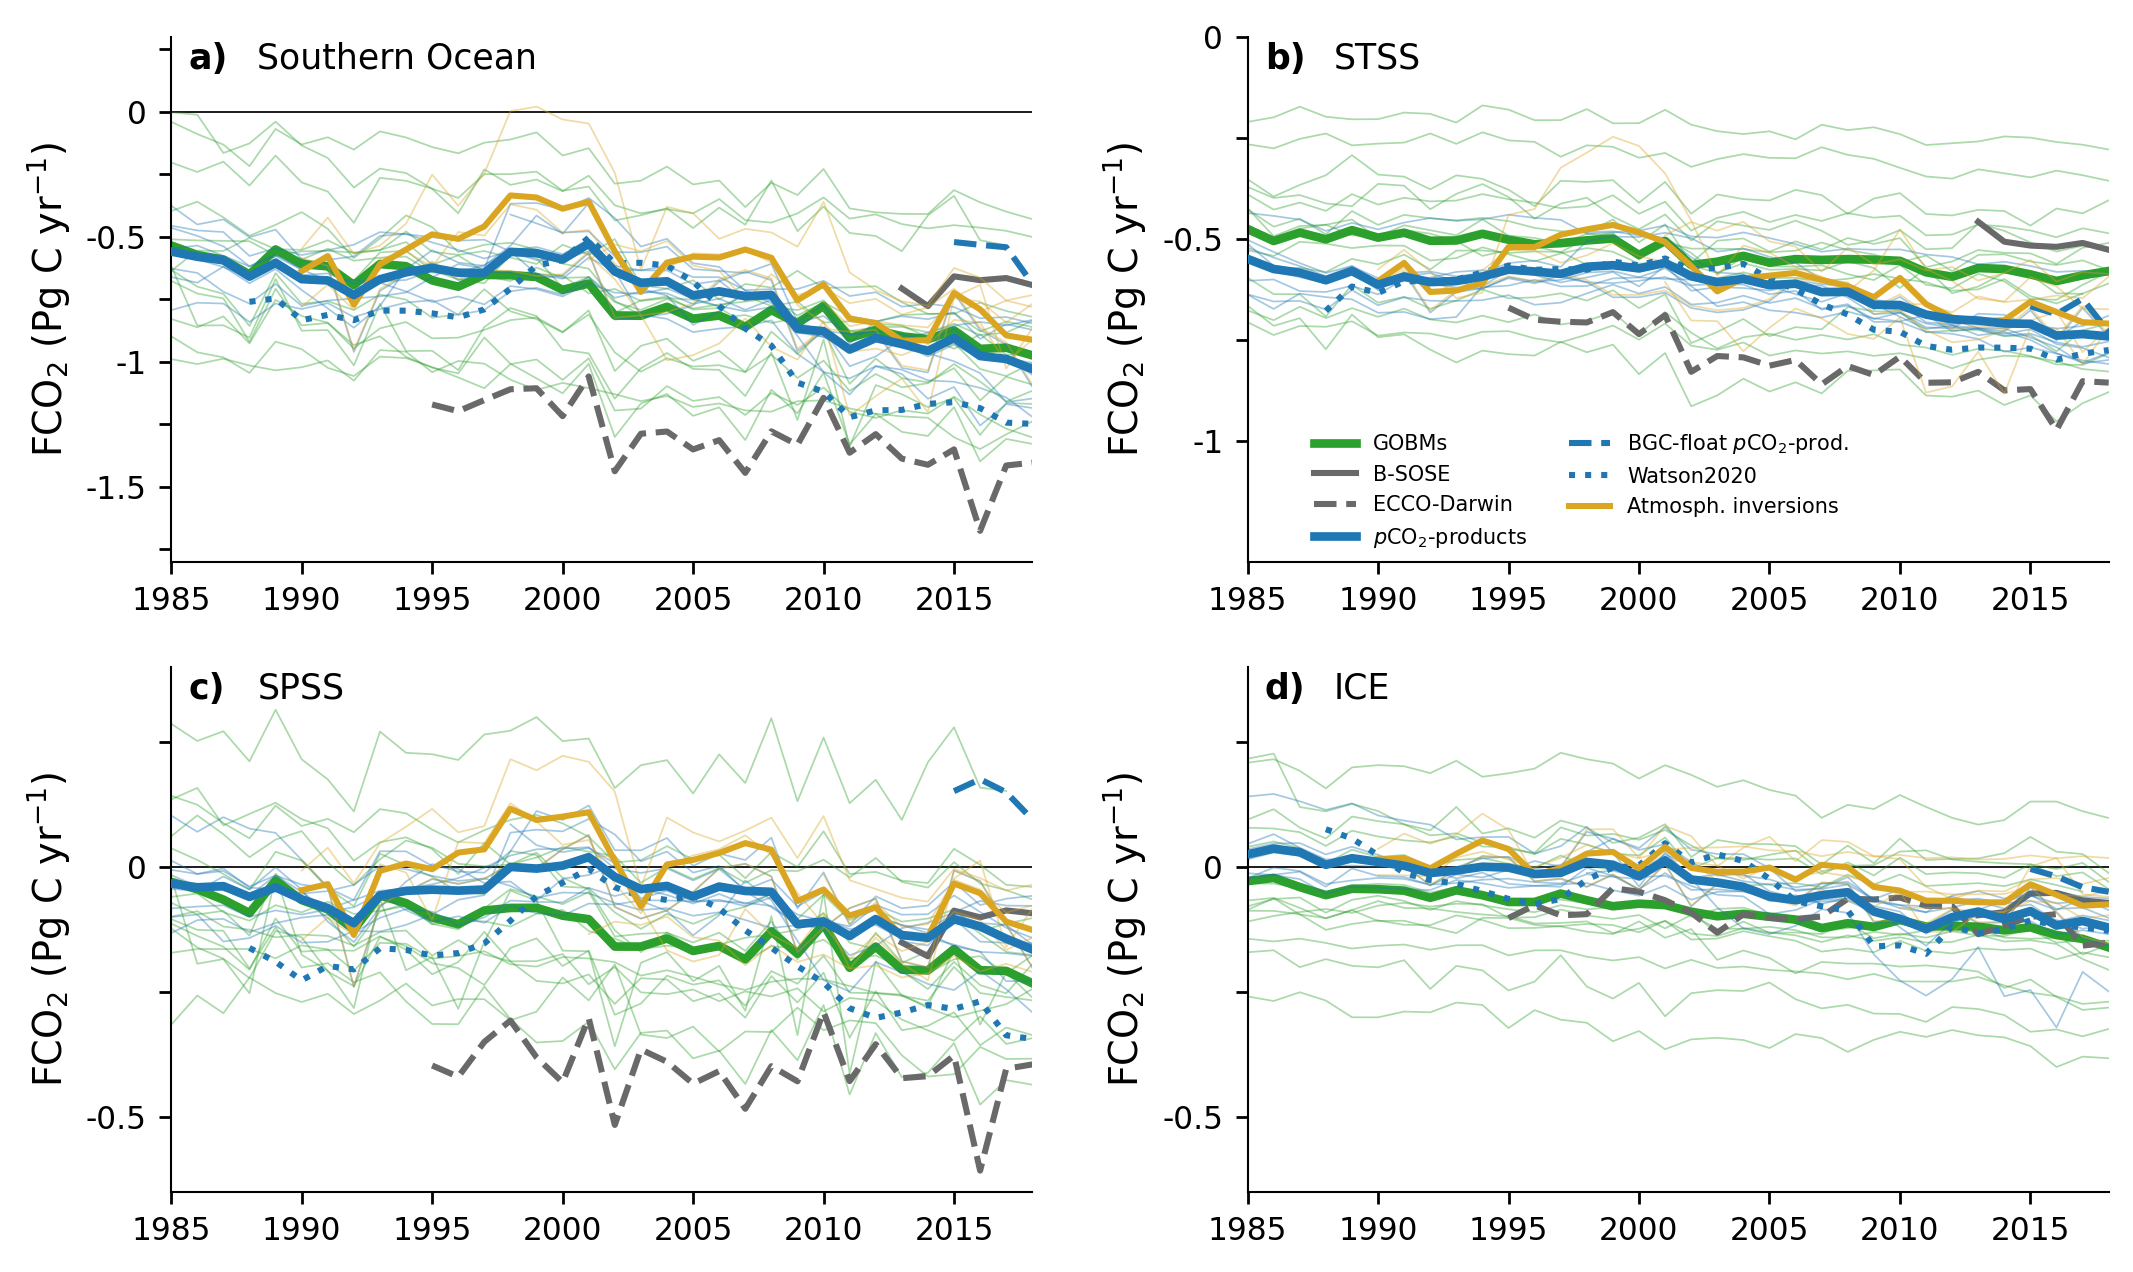

In [20]:
#----
# plot for paper: green/blue, 3 regions
#-----

dpicnt = 250

matplotlib.rcParams['axes.linewidth'] = 0.6 #set the value globally
plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})
    
panel_labels = ['a)','b)','c)','d)']

unit    = 'FCO$_{2}$ (Pg C yr$^{-1}$)'
factor2 = -1*365.25*86400.*12.011/1e15 # conversion factor from mol C m-2 s-1 to PgC yr-1


fig, axs = plt.subplots(2,2,figsize=(10,6), dpi=dpicnt,\
                            gridspec_kw={'width_ratios': [1,1],\
                                         'height_ratios': [1,1]})
plt.subplots_adjust(wspace=0.25)
plt.subplots_adjust(hspace=0.2)

ax1 = plt.subplot2grid((2,2), (0,0))#, colspan=6) # all
ax2 = plt.subplot2grid((2,2), (0,1))#, colspan=6) # STSS
ax3 = plt.subplot2grid((2,2), (1,0))#, colspan=6) # SPSS
ax4 = plt.subplot2grid((2,2), (1,1))#, colspan=6) # ICE


# transpose arrays for function:
# expected input: data: models x regions x time, data_mean: regions x time; swap dimensions in arrays
flux_models_subareas_plot     = np.transpose(flux_models_subareas,[1,2,0])
flux_data_products_plot       = np.transpose(flux_data_products_subareas,[1,2,0])
flux_data_assim_subareas_plot = np.transpose(flux_data_assim_subareas,[1,2,0])
flux_data_ocim_subareas_plot  = np.transpose(flux_ocim_subareas,[1,2,0])
flux_atminv_subareas_plot  = np.transpose(flux_atminv_subareas,[1,2,0])
multi_model_mean_plot      = np.transpose(multi_model_mean,[1,0])
multi_data_prod_mean_plot  = np.transpose(multi_data_prod_mean,[1,0])
multi_data_assim_mean_plot = np.transpose(multi_data_assim_mean,[1,0])
multi_data_watson_mean_plot = np.transpose(multi_data_watson_mean,[1,0])
multi_soccom_mean_plot = np.transpose(multi_soccom_mean,[1,0])
multi_soccom_mean_plot[:,0:-4] = np.nan # only show years 2015-2018 for SOCCOM products

print (multi_data_assim_mean_plot.shape)

atminv_ocim_on = False
if atminv_ocim_on:
    leg_pos = (0.81, 0.15)
    leg_col = 2
    prop={'size': 5}
else:
    leg_pos = (0.72, 0.135) #(1.01, 0.73)
    #leg_pos = (0.96, 0.82)
    leg_col = 2
    prop={'size': 6}
    
#-----
# all
#-----
ax=ax1
rr = subregions.index("all") # region index
print (subregions[rr])
counter = 0 # if set to 1, print legend
panel_number = 1
panel_label = panel_labels[panel_number-1]
ylim1,ylim2=-1.8,0.3
yticks = [-1.75,-1.5,-1.25,-1,-0.75,-0.5,-0.25,0,0.25]
yticklabels =['',-1.5,'',-1,'',-0.5,'',0,'']
yticks_on=True
subroutine_plotting_time_series_1region(ax,area_mean_watson[rr],area_mean_soccom[rr],\
                                                multi_data_watson_mean_plot[rr,:],\
                                                multi_soccom_mean_plot[rr,:],\
                                        area_mean_atminv[rr],multi_data_assim_mean_plot[rr,:],\
                                                biome_area_models[:,rr],\
                                        np.transpose(biome_area_data_products_varying[:,:,rr]),\
                                                biome_area_data_assim[:,rr],biome_area_ocim[:,rr],\
                                                biome_area_atminv[:,rr],\
                                                flux_models_subareas_plot[:,rr,:],\
                                                flux_data_products_plot[:,rr,:],\
                                                flux_data_assim_subareas_plot[:,rr,:],\
                                                flux_data_ocim_subareas_plot[:,rr,:],\
                                                flux_atminv_subareas_plot[:,rr,:],\
                                        add_to_models[rr],biome_area_river[rr],\
                                                models,data_prod,data_assim,data_ocim,data_atminv,\
                                               eval_time,factor2,unit,\
                                       'Southern Ocean',panel_label,counter,atminv_ocim_on,\
                                        yticks_on,ylim1,ylim2,yticks,yticklabels,leg_pos,leg_col,prop)

                                            
#-----
# STSS
#-----
ax=ax2
#ax.set_axis_off()
rr = subregions.index("STSS") # region index
print (subregions[rr])
counter = 1 # if set to 1, print legend
panel_number = 2
panel_label = panel_labels[panel_number-1]
ylim1,ylim2=-1.3,-0.0
yticks = [-1,-0.75,-0.5,-0.25,0]
yticklabels =[-1,'',-0.5,'',0]
yticks_on=True
subroutine_plotting_time_series_1region(ax,area_mean_watson[rr],area_mean_soccom[rr],\
                                                multi_data_watson_mean_plot[rr,:],\
                                                multi_soccom_mean_plot[rr,:],\
                                        area_mean_atminv[rr],multi_data_assim_mean_plot[rr,:],\
                                                biome_area_models[:,rr],\
                                        np.transpose(biome_area_data_products_varying[:,:,rr]),\
                                                biome_area_data_assim[:,rr],biome_area_ocim[:,rr],\
                                                biome_area_atminv[:,rr],\
                                                flux_models_subareas_plot[:,rr,:],\
                                                flux_data_products_plot[:,rr,:],\
                                                flux_data_assim_subareas_plot[:,rr,:],\
                                                flux_data_ocim_subareas_plot[:,rr,:],\
                                                flux_atminv_subareas_plot[:,rr,:],\
                                        add_to_models[rr],biome_area_river[rr],\
                                                models,data_prod,data_assim,data_ocim,data_atminv,\
                                               eval_time,factor2,unit,\
                                       subregions[rr],panel_label,counter,atminv_ocim_on,\
                                        yticks_on,ylim1,ylim2,yticks,yticklabels,leg_pos,leg_col,prop)

# same yticks etc for the three subregions: 
if atminv_ocim_on:
    ylim1,ylim2=-1.0,0.4
    yticks = [-1.0,-0.75,-0.5,-0.25,0,0.25]
    yticklabels =[-1,'',-0.5,'',0,'']
else:
    #ylim1,ylim2=-0.75,0.5
    #yticks = [0.75,-0.5,-0.25,0,0.25,0.5]
    #yticklabels =['',-0.5,'',0,'',0.5]
    ylim1,ylim2=-0.65,0.4
    yticks = [-0.5,-0.25,0,0.25]
    yticklabels =[-0.5,'',0,'']
    
#-----
# SPSS
#-----
ax=ax3
#ax.set_axis_off()
rr = subregions.index("SPSS") # region index
print (subregions[rr])
counter = 0 # if set to 1, print legend
panel_number = 3
panel_label = panel_labels[panel_number-1]
yticks_on=True
subroutine_plotting_time_series_1region(ax,area_mean_watson[rr],area_mean_soccom[rr],\
                                                multi_data_watson_mean_plot[rr,:],\
                                                multi_soccom_mean_plot[rr,:],\
                                        area_mean_atminv[rr],multi_data_assim_mean_plot[rr,:],\
                                                biome_area_models[:,rr],\
                                        np.transpose(biome_area_data_products_varying[:,:,rr]),\
                                                biome_area_data_assim[:,rr],biome_area_ocim[:,rr],\
                                                biome_area_atminv[:,rr],\
                                                flux_models_subareas_plot[:,rr,:],\
                                                flux_data_products_plot[:,rr,:],\
                                                flux_data_assim_subareas_plot[:,rr,:],\
                                                flux_data_ocim_subareas_plot[:,rr,:],\
                                                flux_atminv_subareas_plot[:,rr,:],\
                                        add_to_models[rr],biome_area_river[rr],\
                                                models,data_prod,data_assim,data_ocim,data_atminv,\
                                               eval_time,factor2,unit,\
                                       subregions[rr],panel_label,counter,atminv_ocim_on,\
                                        yticks_on,ylim1,ylim2,yticks,yticklabels,leg_pos,leg_col,prop)
#-----
# ICE
#-----
ax=ax4
#ax.set_axis_off()
rr = subregions.index("ICE") # region index
print (subregions[rr])
counter = 0 # if set to 1, print legend
panel_number = 4
panel_label = panel_labels[panel_number-1]
yticks_on=True
subroutine_plotting_time_series_1region(ax,area_mean_watson[rr],area_mean_soccom[rr],\
                                                multi_data_watson_mean_plot[rr,:],\
                                                multi_soccom_mean_plot[rr,:],\
                                        area_mean_atminv[rr],multi_data_assim_mean_plot[rr,:],\
                                                biome_area_models[:,rr],\
                                        np.transpose(biome_area_data_products_varying[:,:,rr]),\
                                                biome_area_data_assim[:,rr],biome_area_ocim[:,rr],\
                                                biome_area_atminv[:,rr],\
                                                flux_models_subareas_plot[:,rr,:],\
                                                flux_data_products_plot[:,rr,:],\
                                                flux_data_assim_subareas_plot[:,rr,:],\
                                                flux_data_ocim_subareas_plot[:,rr,:],\
                                                flux_atminv_subareas_plot[:,rr,:],\
                                        add_to_models[rr],biome_area_river[rr],\
                                                models,data_prod,data_assim,data_ocim,data_atminv,\
                                               eval_time,factor2,unit,\
                                       subregions[rr],panel_label,counter,atminv_ocim_on,\
                                        yticks_on,ylim1,ylim2,yticks,yticklabels,leg_pos,leg_col,prop)    
    
if river_adjustment:
    river_name = '_wRiver_Adjustment'
else:
    river_name = ''
    
if atminv_ocim_on: 
    filename1 = 'fig8_time_series_CO2_flux_avg_'+str(year1)+'_'+str(year2)+\
    '_wShading_std_wOCIM_wAtmInv_2x2_panels'+river_name+'.png'
else:
    filename1 = 'fig8_time_series_CO2_flux_avg_'+str(year1)+'_'+str(year2)+\
    '_wShading_std_2x2_panels'+river_name+'.png'
print (filename1)
    
plt.savefig(save_to_dir+filename1,dpi = dpicnt, bbox_inches='tight')
plt.show()


(13, 34)
STSS-Atl
-0.22392977867085026
STSS-Ind
-0.28517752486738823
STSS-Pac
-0.2012643592017017
SPSS-Atl
-0.05308897759147569
SPSS-Ind
-0.018003534347566835
SPSS-Pac
-0.055267419609182154
ICE-Atl
-0.014044098369425434
ICE-Ind
-0.01439082545264451
ICE-Pac
-0.04688372039474261
fig8_time_series_CO2_flux_avg_1985_2018_wShading_std_9regions_3x3_panels_wRiver_Adjustment


/tmp/ipykernel_459263/3375366538.py:132: RuntimeWarning: Mean of empty slice
  atminv_mean  = np.nanmean(area_2d_atminv[ind_list,:]*(-1)*data_atminv_all[ind_list,:],axis=0)
/global/homes/c/cnissen/.conda/envs/myenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_459263/3375366538.py:132: RuntimeWarning: Mean of empty slice
  atminv_mean  = np.nanmean(area_2d_atminv[ind_list,:]*(-1)*data_atminv_all[ind_list,:],axis=0)
/global/homes/c/cnissen/.conda/envs/myenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_459263/3375366538.py:132: RuntimeWarning: Mean of empty slice
  atminv_mean  = np.nanmean(area_2d_atminv[ind_list,:]*(-1)*data_atminv_all[ind_list,:],axis=0)
/global/homes/c/cnissen/.conda/envs/myenv/lib/pytho

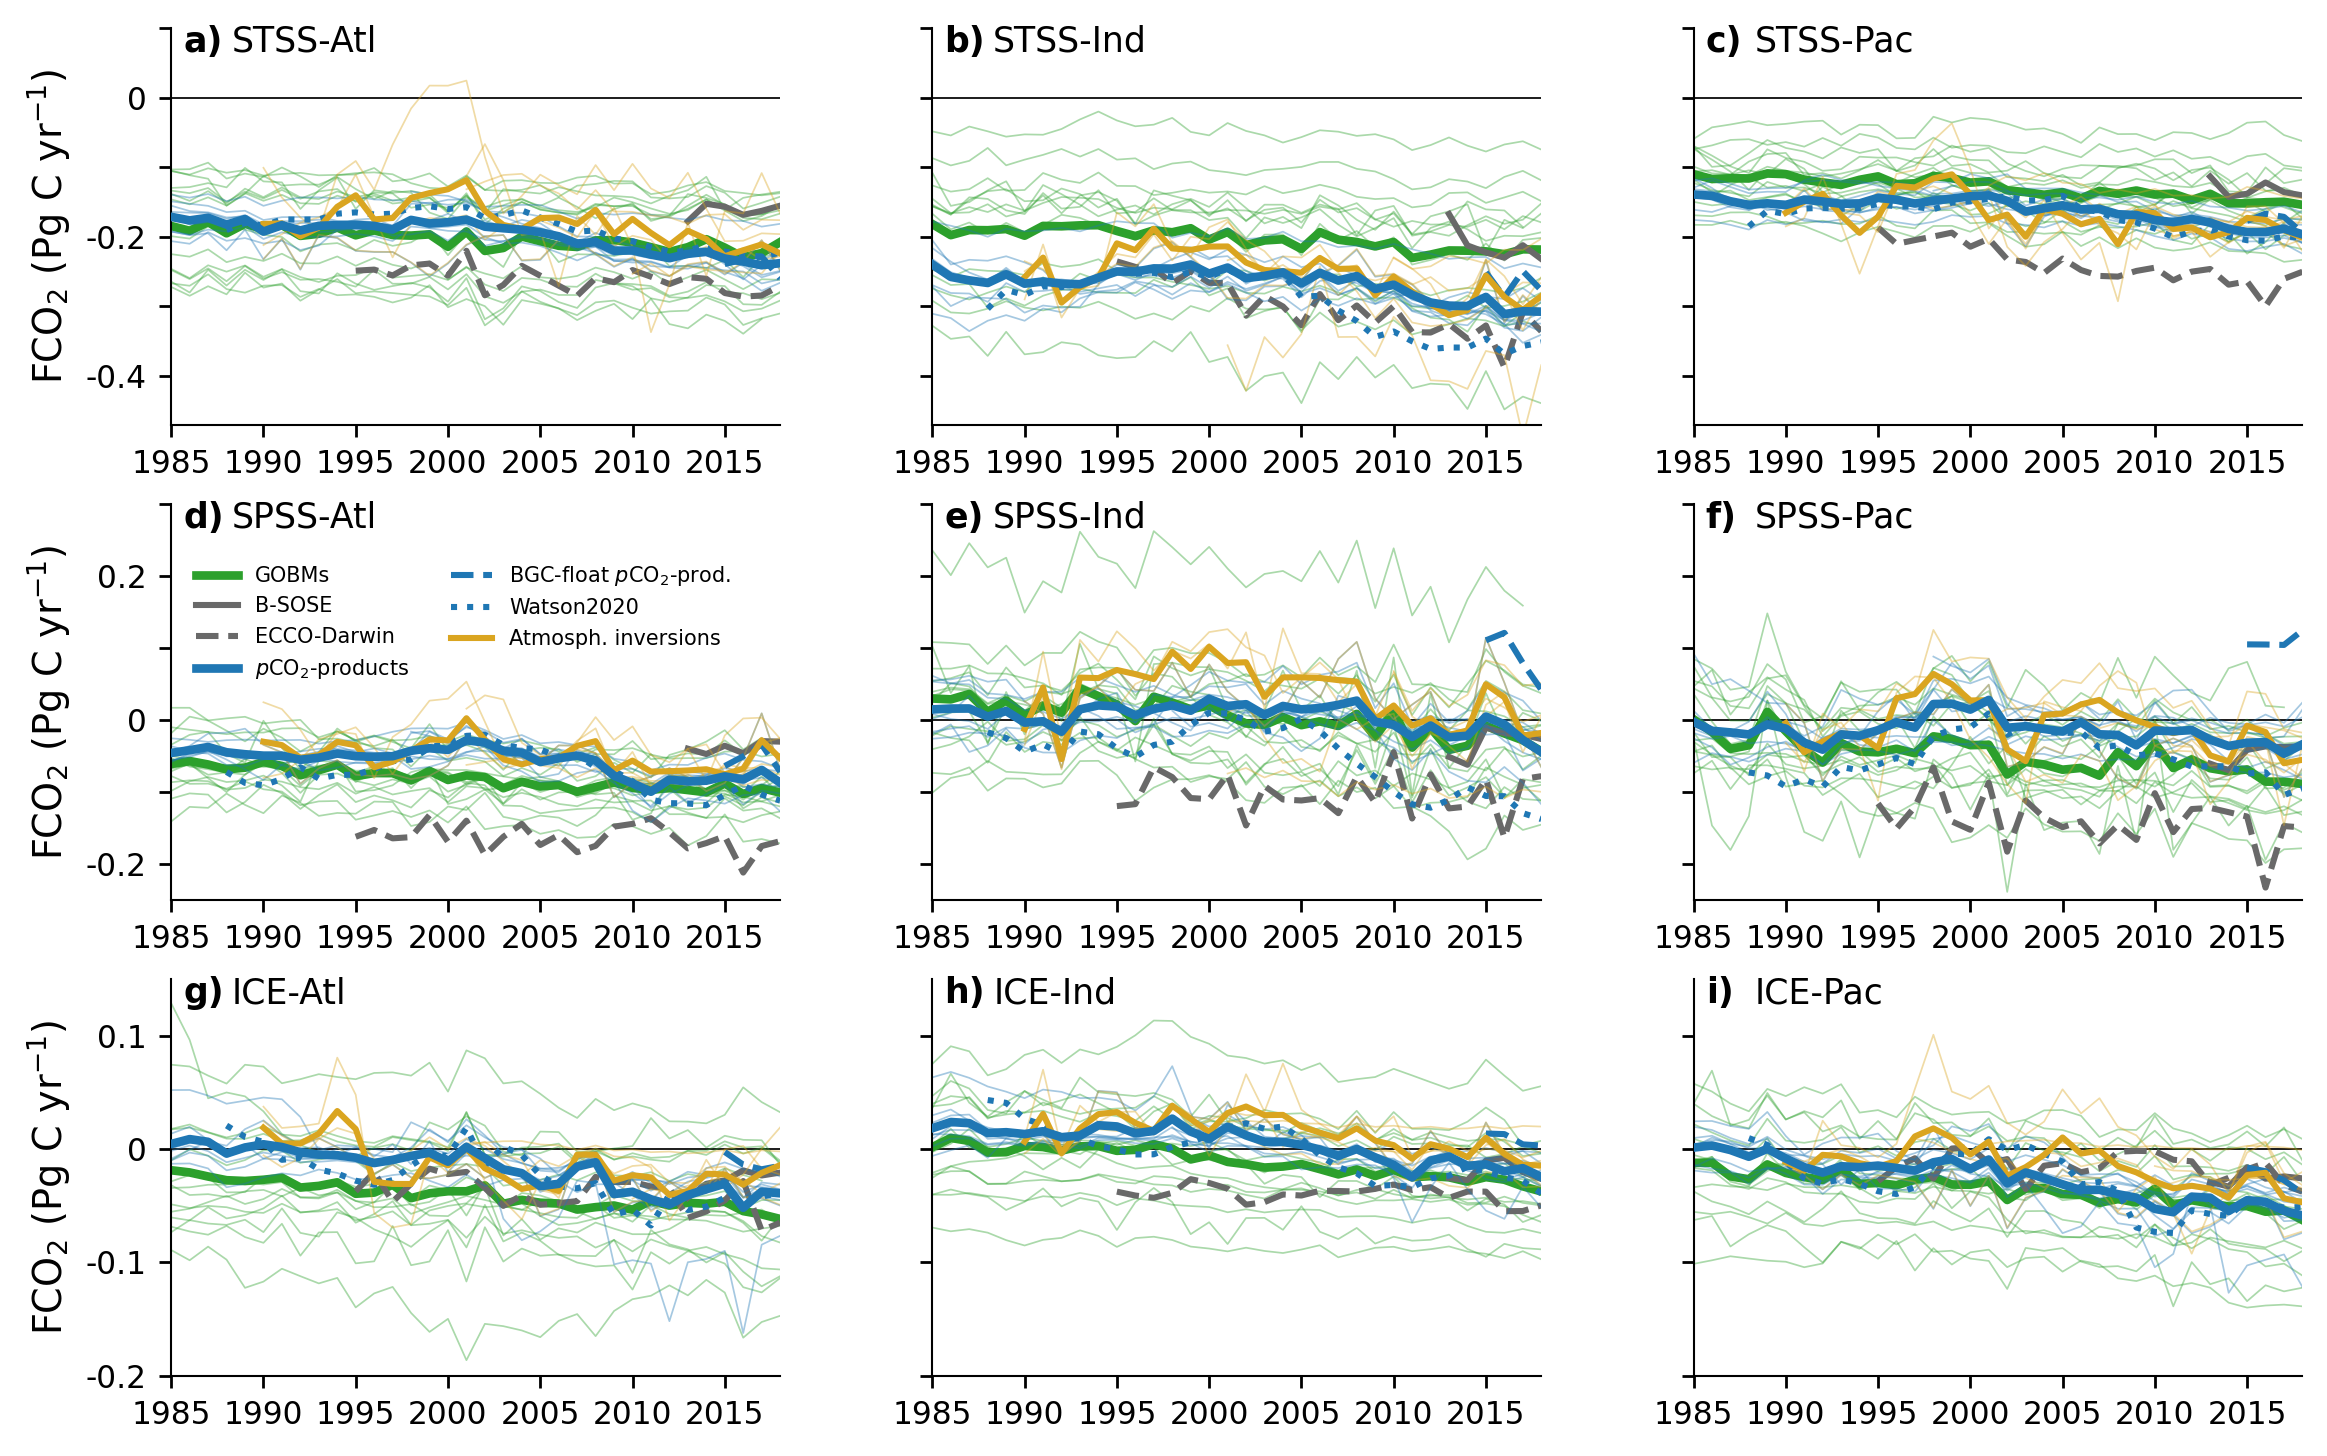

In [21]:
#----
# plot for paper: green/blue, 9 regions
#-----

dpicnt = 250

matplotlib.rcParams['axes.linewidth'] = 0.6 #set the value globally
plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})
    
panel_labels = ['a)','b)','c)','d)','e)','f)','g)','h)','i)']

unit    = 'FCO$_{2}$ (Pg C yr$^{-1}$)'
factor2 = -1*365.25*86400.*12.011/1e15 # conversion factor from mol C m-2 s-1 to PgC yr-1


fig, axs = plt.subplots(3,3,figsize=(11,7), dpi=dpicnt,\
                            gridspec_kw={'width_ratios': [1,1,1],\
                                         'height_ratios': [1,1,1]})
plt.subplots_adjust(wspace=0.25)
plt.subplots_adjust(hspace=0.2)

ax1 = plt.subplot2grid((3,3), (0,0))
ax2 = plt.subplot2grid((3,3), (0,1))
ax3 = plt.subplot2grid((3,3), (0,2))

ax4 = plt.subplot2grid((3,3), (1,0))
ax5 = plt.subplot2grid((3,3), (1,1))
ax6 = plt.subplot2grid((3,3), (1,2))

ax7 = plt.subplot2grid((3,3), (2,0))
ax8 = plt.subplot2grid((3,3), (2,1))
ax9 = plt.subplot2grid((3,3), (2,2))


# transpose arrays for function:
# expected input: data: models x regions x time, data_mean: regions x time; swap dimensions in arrays
flux_models_subareas_plot     = np.transpose(flux_models_subareas,[1,2,0])
flux_data_products_plot       = np.transpose(flux_data_products_subareas,[1,2,0])
flux_data_assim_subareas_plot = np.transpose(flux_data_assim_subareas,[1,2,0])
flux_data_ocim_subareas_plot  = np.transpose(flux_ocim_subareas,[1,2,0])
flux_atminv_subareas_plot  = np.transpose(flux_atminv_subareas,[1,2,0])
multi_model_mean_plot      = np.transpose(multi_model_mean,[1,0])
multi_data_prod_mean_plot  = np.transpose(multi_data_prod_mean,[1,0])
multi_data_assim_mean_plot = np.transpose(multi_data_assim_mean,[1,0])
multi_data_watson_mean_plot = np.transpose(multi_data_watson_mean,[1,0])
multi_soccom_mean_plot = np.transpose(multi_soccom_mean,[1,0])
multi_soccom_mean_plot[:,0:-4] = np.nan # only show years 2015-2018 for SOCCOM products

print (multi_data_assim_mean_plot.shape)

atminv_ocim_on = False
if atminv_ocim_on:
    leg_pos = (0.81, 0.15)
    leg_col = 2
    prop={'size': 5}
else:
    leg_pos = (0.95, 0.7) #(1.01, 0.73)
    #leg_pos = (0.96, 0.82)
    leg_col = 2
    prop={'size': 6}
    
#-----
# 1st row: STSS
#-----
ylim1,ylim2=-0.47,0.1
yticks = [-0.4,-0.3,-0.2,-0.1,0,0.1]
yticklabels =[-0.4,'',-0.2,'',0,'']

ax=ax1
rr = subregions.index("STSS-Atl") # region index
print (subregions[rr])
counter = 0 # if set to 1, print legend
panel_number = 1
panel_label = panel_labels[panel_number-1]
yticks_on=True
subroutine_plotting_time_series_1region(ax,area_mean_watson[rr],area_mean_soccom[rr],\
                                                multi_data_watson_mean_plot[rr,:],\
                                                multi_soccom_mean_plot[rr,:],\
                                        area_mean_atminv[rr],multi_data_assim_mean_plot[rr,:],\
                                                biome_area_models[:,rr],\
                                        np.transpose(biome_area_data_products_varying[:,:,rr]),\
                                                biome_area_data_assim[:,rr],biome_area_ocim[:,rr],\
                                                biome_area_atminv[:,rr],\
                                                flux_models_subareas_plot[:,rr,:],\
                                                flux_data_products_plot[:,rr,:],\
                                                flux_data_assim_subareas_plot[:,rr,:],\
                                                flux_data_ocim_subareas_plot[:,rr,:],\
                                                flux_atminv_subareas_plot[:,rr,:],\
                                        add_to_models[rr],biome_area_river[rr],\
                                                models,data_prod,data_assim,data_ocim,data_atminv,\
                                               eval_time,factor2,unit,\
                                       subregions[rr],panel_label,counter,atminv_ocim_on,\
                                        yticks_on,ylim1,ylim2,yticks,yticklabels,leg_pos,leg_col,prop)

                                            
ax=ax2
rr = subregions.index("STSS-Ind") # region index
print (subregions[rr])
counter = 0 # if set to 1, print legend
panel_number = 2
panel_label = panel_labels[panel_number-1]
yticks_on=False
subroutine_plotting_time_series_1region(ax,area_mean_watson[rr],area_mean_soccom[rr],\
                                                multi_data_watson_mean_plot[rr,:],\
                                                multi_soccom_mean_plot[rr,:],\
                                        area_mean_atminv[rr],multi_data_assim_mean_plot[rr,:],\
                                                biome_area_models[:,rr],\
                                        np.transpose(biome_area_data_products_varying[:,:,rr]),\
                                                biome_area_data_assim[:,rr],biome_area_ocim[:,rr],\
                                                biome_area_atminv[:,rr],\
                                                flux_models_subareas_plot[:,rr,:],\
                                                flux_data_products_plot[:,rr,:],\
                                                flux_data_assim_subareas_plot[:,rr,:],\
                                                flux_data_ocim_subareas_plot[:,rr,:],\
                                                flux_atminv_subareas_plot[:,rr,:],\
                                        add_to_models[rr],biome_area_river[rr],\
                                                models,data_prod,data_assim,data_ocim,data_atminv,\
                                               eval_time,factor2,unit,\
                                       subregions[rr],panel_label,counter,atminv_ocim_on,\
                                        yticks_on,ylim1,ylim2,yticks,yticklabels,leg_pos,leg_col,prop)


ax=ax3
rr = subregions.index("STSS-Pac") # region index
print (subregions[rr])
counter = 0 # if set to 1, print legend
panel_number = 3
panel_label = panel_labels[panel_number-1]
yticks_on=False
subroutine_plotting_time_series_1region(ax,area_mean_watson[rr],area_mean_soccom[rr],\
                                                multi_data_watson_mean_plot[rr,:],\
                                                multi_soccom_mean_plot[rr,:],\
                                        area_mean_atminv[rr],multi_data_assim_mean_plot[rr,:],\
                                                biome_area_models[:,rr],\
                                        np.transpose(biome_area_data_products_varying[:,:,rr]),\
                                                biome_area_data_assim[:,rr],biome_area_ocim[:,rr],\
                                                biome_area_atminv[:,rr],\
                                                flux_models_subareas_plot[:,rr,:],\
                                                flux_data_products_plot[:,rr,:],\
                                                flux_data_assim_subareas_plot[:,rr,:],\
                                                flux_data_ocim_subareas_plot[:,rr,:],\
                                                flux_atminv_subareas_plot[:,rr,:],\
                                        add_to_models[rr],biome_area_river[rr],\
                                                models,data_prod,data_assim,data_ocim,data_atminv,\
                                               eval_time,factor2,unit,\
                                       subregions[rr],panel_label,counter,atminv_ocim_on,\
                                        yticks_on,ylim1,ylim2,yticks,yticklabels,leg_pos,leg_col,prop)


    
#-----
# 2nd row: SPSS
#-----
ylim1,ylim2=-0.25,0.3
yticks = [-0.2,-0.1,0,0.1,0.2,0.3]
yticklabels =[-0.2,'',0,'',0.2,'']

ax=ax4
rr = subregions.index("SPSS-Atl") # region index
print (subregions[rr])
counter = 1 # if set to 1, print legend
panel_number = 4
panel_label = panel_labels[panel_number-1]
yticks_on=True
subroutine_plotting_time_series_1region(ax,area_mean_watson[rr],area_mean_soccom[rr],\
                                                multi_data_watson_mean_plot[rr,:],\
                                                multi_soccom_mean_plot[rr,:],\
                                        area_mean_atminv[rr],multi_data_assim_mean_plot[rr,:],\
                                                biome_area_models[:,rr],\
                                        np.transpose(biome_area_data_products_varying[:,:,rr]),\
                                                biome_area_data_assim[:,rr],biome_area_ocim[:,rr],\
                                                biome_area_atminv[:,rr],\
                                                flux_models_subareas_plot[:,rr,:],\
                                                flux_data_products_plot[:,rr,:],\
                                                flux_data_assim_subareas_plot[:,rr,:],\
                                                flux_data_ocim_subareas_plot[:,rr,:],\
                                                flux_atminv_subareas_plot[:,rr,:],\
                                        add_to_models[rr],biome_area_river[rr],\
                                                models,data_prod,data_assim,data_ocim,data_atminv,\
                                               eval_time,factor2,unit,\
                                       subregions[rr],panel_label,counter,atminv_ocim_on,\
                                        yticks_on,ylim1,ylim2,yticks,yticklabels,leg_pos,leg_col,prop)

                                            
ax=ax5
rr = subregions.index("SPSS-Ind") # region index
print (subregions[rr])
counter = 0 # if set to 1, print legend
panel_number = 5
panel_label = panel_labels[panel_number-1]
yticks_on=False
subroutine_plotting_time_series_1region(ax,area_mean_watson[rr],area_mean_soccom[rr],\
                                                multi_data_watson_mean_plot[rr,:],\
                                                multi_soccom_mean_plot[rr,:],\
                                        area_mean_atminv[rr],multi_data_assim_mean_plot[rr,:],\
                                                biome_area_models[:,rr],\
                                        np.transpose(biome_area_data_products_varying[:,:,rr]),\
                                                biome_area_data_assim[:,rr],biome_area_ocim[:,rr],\
                                                biome_area_atminv[:,rr],\
                                                flux_models_subareas_plot[:,rr,:],\
                                                flux_data_products_plot[:,rr,:],\
                                                flux_data_assim_subareas_plot[:,rr,:],\
                                                flux_data_ocim_subareas_plot[:,rr,:],\
                                                flux_atminv_subareas_plot[:,rr,:],\
                                        add_to_models[rr],biome_area_river[rr],\
                                                models,data_prod,data_assim,data_ocim,data_atminv,\
                                               eval_time,factor2,unit,\
                                       subregions[rr],panel_label,counter,atminv_ocim_on,\
                                        yticks_on,ylim1,ylim2,yticks,yticklabels,leg_pos,leg_col,prop)


ax=ax6
rr = subregions.index("SPSS-Pac") # region index
print (subregions[rr])
counter = 0 # if set to 1, print legend
panel_number = 6
panel_label = panel_labels[panel_number-1]
yticks_on=False
subroutine_plotting_time_series_1region(ax,area_mean_watson[rr],area_mean_soccom[rr],\
                                                multi_data_watson_mean_plot[rr,:],\
                                                multi_soccom_mean_plot[rr,:],\
                                        area_mean_atminv[rr],multi_data_assim_mean_plot[rr,:],\
                                                biome_area_models[:,rr],\
                                        np.transpose(biome_area_data_products_varying[:,:,rr]),\
                                                biome_area_data_assim[:,rr],biome_area_ocim[:,rr],\
                                                biome_area_atminv[:,rr],\
                                                flux_models_subareas_plot[:,rr,:],\
                                                flux_data_products_plot[:,rr,:],\
                                                flux_data_assim_subareas_plot[:,rr,:],\
                                                flux_data_ocim_subareas_plot[:,rr,:],\
                                                flux_atminv_subareas_plot[:,rr,:],\
                                        add_to_models[rr],biome_area_river[rr],\
                                                models,data_prod,data_assim,data_ocim,data_atminv,\
                                               eval_time,factor2,unit,\
                                       subregions[rr],panel_label,counter,atminv_ocim_on,\
                                        yticks_on,ylim1,ylim2,yticks,yticklabels,leg_pos,leg_col,prop)

#-----
# 3rd row: ICE
#-----
ylim1,ylim2=-0.2,0.15
yticks = [-0.2,-0.1,0,0.1]
yticklabels =[-0.2,-0.1,0,0.1]

ax=ax7
rr = subregions.index("ICE-Atl") # region index
print (subregions[rr])
counter = 0 # if set to 1, print legend
panel_number = 7
panel_label = panel_labels[panel_number-1]
yticks_on=True
subroutine_plotting_time_series_1region(ax,area_mean_watson[rr],area_mean_soccom[rr],\
                                                multi_data_watson_mean_plot[rr,:],\
                                                multi_soccom_mean_plot[rr,:],\
                                        area_mean_atminv[rr],multi_data_assim_mean_plot[rr,:],\
                                                biome_area_models[:,rr],\
                                        np.transpose(biome_area_data_products_varying[:,:,rr]),\
                                                biome_area_data_assim[:,rr],biome_area_ocim[:,rr],\
                                                biome_area_atminv[:,rr],\
                                                flux_models_subareas_plot[:,rr,:],\
                                                flux_data_products_plot[:,rr,:],\
                                                flux_data_assim_subareas_plot[:,rr,:],\
                                                flux_data_ocim_subareas_plot[:,rr,:],\
                                                flux_atminv_subareas_plot[:,rr,:],\
                                        add_to_models[rr],biome_area_river[rr],\
                                                models,data_prod,data_assim,data_ocim,data_atminv,\
                                               eval_time,factor2,unit,\
                                       subregions[rr],panel_label,counter,atminv_ocim_on,\
                                        yticks_on,ylim1,ylim2,yticks,yticklabels,leg_pos,leg_col,prop)

                                            
ax=ax8
rr = subregions.index("ICE-Ind") # region index
print (subregions[rr])
counter = 0 # if set to 1, print legend
panel_number = 8
panel_label = panel_labels[panel_number-1]
yticks_on=False
subroutine_plotting_time_series_1region(ax,area_mean_watson[rr],area_mean_soccom[rr],\
                                                multi_data_watson_mean_plot[rr,:],\
                                                multi_soccom_mean_plot[rr,:],\
                                        area_mean_atminv[rr],multi_data_assim_mean_plot[rr,:],\
                                                biome_area_models[:,rr],\
                                        np.transpose(biome_area_data_products_varying[:,:,rr]),\
                                                biome_area_data_assim[:,rr],biome_area_ocim[:,rr],\
                                                biome_area_atminv[:,rr],\
                                                flux_models_subareas_plot[:,rr,:],\
                                                flux_data_products_plot[:,rr,:],\
                                                flux_data_assim_subareas_plot[:,rr,:],\
                                                flux_data_ocim_subareas_plot[:,rr,:],\
                                                flux_atminv_subareas_plot[:,rr,:],\
                                        add_to_models[rr],biome_area_river[rr],\
                                                models,data_prod,data_assim,data_ocim,data_atminv,\
                                               eval_time,factor2,unit,\
                                       subregions[rr],panel_label,counter,atminv_ocim_on,\
                                        yticks_on,ylim1,ylim2,yticks,yticklabels,leg_pos,leg_col,prop)


ax=ax9
rr = subregions.index("ICE-Pac") # region index
print (subregions[rr])
counter = 0 # if set to 1, print legend
panel_number = 9
panel_label = panel_labels[panel_number-1]
yticks_on=False
subroutine_plotting_time_series_1region(ax,area_mean_watson[rr],area_mean_soccom[rr],\
                                                multi_data_watson_mean_plot[rr,:],\
                                                multi_soccom_mean_plot[rr,:],\
                                        area_mean_atminv[rr],multi_data_assim_mean_plot[rr,:],\
                                                biome_area_models[:,rr],\
                                        np.transpose(biome_area_data_products_varying[:,:,rr]),\
                                                biome_area_data_assim[:,rr],biome_area_ocim[:,rr],\
                                                biome_area_atminv[:,rr],\
                                                flux_models_subareas_plot[:,rr,:],\
                                                flux_data_products_plot[:,rr,:],\
                                                flux_data_assim_subareas_plot[:,rr,:],\
                                                flux_data_ocim_subareas_plot[:,rr,:],\
                                                flux_atminv_subareas_plot[:,rr,:],\
                                        add_to_models[rr],biome_area_river[rr],\
                                                models,data_prod,data_assim,data_ocim,data_atminv,\
                                               eval_time,factor2,unit,\
                                       subregions[rr],panel_label,counter,atminv_ocim_on,\
                                        yticks_on,ylim1,ylim2,yticks,yticklabels,leg_pos,leg_col,prop)
    
    
if river_adjustment:
    river_name = '_wRiver_Adjustment'
else:
    river_name = ''
    
if atminv_ocim_on: 
    filename1 = 'fig8_time_series_CO2_flux_avg_'+str(year1)+'_'+str(year2)+\
    '_wShading_std_wOCIM_wAtmInv_9regions3x3_panels'+river_name+''
else:
    filename1 = 'fig8_time_series_CO2_flux_avg_'+str(year1)+'_'+str(year2)+\
    '_wShading_std_9regions_3x3_panels'+river_name+''
print (filename1)
    
plt.savefig(save_to_dir+filename1+'.png',dpi = dpicnt, bbox_inches='tight',format='png')
plt.savefig(save_to_dir+filename1+'.pdf',dpi = dpicnt, bbox_inches='tight',format='pdf')
plt.show()






In [22]:
#----
# FUNCTIONS to plot drift-corrected time series
#----


def subroutine_plotting_time_series_1region_MMM_MDM_w_simB(ax,biome_area_models,biome_area_data_products,\
                                                models_all,data_all,\
                                                add_to_models,biome_area_river,\
                                                models,data_prod,\
                                               eval_time,factor,unit,\
                                       subregions,panel_label,counter,\
                                            yticks_on,ylim1,ylim2,yticks,yticklabels,\
                                                   leg_pos,leg_col,leg_prop,slope,slope1,slope2):
    
                            
    lw_mean          = 2.5
    lw_all           = 1
    alpha_value      = 0.3
    alpha_std=0.3
    fs_text = 9

    color_models     = 'C2'
    color_data       = 'C0'
    color_watson     = color_data #'lightsteelblue'
    color_data_assim ='grey'
    color_data_assim1 = 'dimgrey'
    color_data_assim2 = color_data_assim1 #'darkgrey'
    color_atminv     = 'C4'
    color_ocim1 = 'navajowhite'
    color_ocim2 = 'papayawhip'
    color_dots = 'black'
    color_soccom = 'darkslateblue'
    ls_ecco = ':'
    ls_soccom = ':'
    ls_watson = '--'
    ls_ldeo = '-.'
    
    factor_river = 365.25*86400.*12.011/1e15 # for river fluxes, no need to multiply by "-1" -> pos=outgassing already!

    #-----
    # MODELS
    #-----
    add_rivers = factor_river*biome_area_river*add_to_models
    add_each_year = add_rivers*np.ones(len(eval_time))
    
    # create array of area: models x time (area constant in time)
    area_2d = np.transpose(np.tile(biome_area_models[:],[len(eval_time),1])) # should be models x time
    
    # apply model trends
    models_all2 = np.zeros_like(models_all)
    # "slope" is already in PgC yr-1 yr-1, 
    # make sure that when applying it to fluxes, the latter are already in Pg C yr-1
    for mm in range(0,len(models)):
        for yy in range(0,len(eval_time)):
                models_all2[mm,yy] = area_2d[mm,yy]*factor*models_all[mm,yy]-slope[mm]
                
    # correcting with trend from 1985-2000
    models_all2a = np.zeros_like(models_all)
    # "slope" is already in PgC yr-1 yr-1, 
    # make sure that when applying it to fluxes, the latter are already in Pg C yr-1
    for mm in range(0,len(models)):
        for yy in range(0,len(eval_time)):
                models_all2a[mm,yy] = area_2d[mm,yy]*factor*models_all[mm,yy]-slope1[mm]
                
    # correcting with trend from 2001-2018
    models_all2b = np.zeros_like(models_all)
    # "slope" is already in PgC yr-1 yr-1, 
    # make sure that when applying it to fluxes, the latter are already in Pg C yr-1
    for mm in range(0,len(models)):
        for yy in range(0,len(eval_time)):
                models_all2b[mm,yy] = area_2d[mm,yy]*factor*models_all[mm,yy]-slope2[mm]
    
    yy = 0
    for mm in range(0,len(models)):
        print (eval_time[yy],models[mm],models_all2[mm,yy],models_all2a[mm,yy],models_all2b[mm,yy])
    
    
#    print 'Comparison with and without drift correction:'
#    print models[5]
#    print 'first year, with vs without:',models_all2[5,0],area_2d[5,0]*factor*models_all[5,0]
#    print 'last year, with vs without:',models_all2[5,-1],area_2d[5,-1]*factor*models_all[5,-1]
    #print slope[:]
    # for calculation of multi-model mean, use the array that is drift-corrected
    model_data_mean = np.nanmean(models_all2[:,:],axis=0)+add_each_year
#    model_data_mean_no_drift = np.nanmean(area_2d*factor*models_all[:,:],axis=0)+add_each_year
#    print 'with drift corr, MMM, first/last year:',model_data_mean[0],model_data_mean[-1]
#    print 'no drift corr, MMM, first/last year:',model_data_mean_no_drift[0],model_data_mean_no_drift[-1]
#    print ''
    #model_data_std = np.nanstd(area_2d*factor*models_all[:,:],axis=0)
    #print model_data_std
    #a2a = area_mean_models*factor*model_mean[:]+model_data_std
    #a2b = area_mean_models*factor*model_mean[:]-model_data_std
    ax.plot(range(0,len(eval_time)),model_data_mean,\
                    color_models,label='GOBMs',linewidth=lw_mean)
    
    #-----
    # DATA -> area not constant in time, passed as an input argument 
    #-----
    obs_data_mean  = np.nanmean(biome_area_data_products[:,:]*factor*data_all[:,:],axis=0)

    ax.plot(range(0,len(eval_time)),obs_data_mean,\
                        color_data,label='$p$CO$_{2}$-products',linewidth=lw_mean,zorder=40)
        
        
    #---
    # plot linear fits (1985-2000)
    #---
    #ind2000 = np.where((eval_time==year_start))[0][0]
    #x = np.array(np.arange(0,len(eval_time[ind2000:]))).reshape((-1, 1))
    
    year_start,year_end = 1985,2000
    ind2000 = np.where((eval_time>=year_start) & (eval_time<=year_end))[0]
    x = np.array(np.arange(0,len(eval_time[ind2000]))).reshape((-1, 1))
    #print ind2000
    
    print ('#####')
    print ('1985-2000')
    
    # MODELS
    a1 = model_data_mean[ind2000]
    ind_noNaN = np.where(~np.isnan(a1))[0]
    a1 = a1[ind_noNaN]
    x1 = x[ind_noNaN]
    model = LinearRegression()
    model.fit(x1, a1)
    model = LinearRegression().fit(x, a1)
    print ('MEAN: slope models (per decade): ',10*model.coef_[0])
    slope_models1 = model.coef_[0]
    # Make predictions using the testing set
    pred_data = model.predict(np.array(np.arange(0,len(eval_time[ind2000]))).reshape((-1, 1)))
    #pred_data = model.predict(np.array(np.arange(0,len(eval_time[ind2000:]))).reshape((-1, 1)))
    ax.plot(ind2000,pred_data,\
                        color_models,label='GOBMs fit, 1985-2000',\
            linewidth=lw_mean-0.5,linestyle='--',zorder=30)
    
    # DATA PRODUCTS
    a1 = obs_data_mean[ind2000]
    ind_noNaN = np.where(~np.isnan(a1))[0]
    a1 = a1[ind_noNaN]
    x1 = x[ind_noNaN]
    model = LinearRegression()
    model.fit(x1, a1)
    model = LinearRegression().fit(x, a1)
    print ('MEAN: slope data products (per decade): ',10*model.coef_[0])
    slope_data1 = model.coef_[0]
    
    # Make predictions using the testing set
    pred_data = model.predict(np.array(np.arange(0,len(eval_time[ind2000]))).reshape((-1, 1)))
    ax.plot(ind2000,pred_data,\
                        color_data,label='$p$CO$_{2}$-product fit, 1985-2000',\
            linewidth=lw_mean-0.5,linestyle='--',zorder=30)
   
    # get trend in each model (to get spread)
    trend_models1 = np.nan*np.ones(len(models))
    for mm in range(0,len(models)):
        a1 = models_all2a[mm,ind2000] # updated here: use models corrected with trend in simB from 1985-2000
        ind_noNaN = np.where(~np.isnan(a1))[0]
        a1 = a1[ind_noNaN]
        x1 = x[ind_noNaN]
        model = LinearRegression()
        model.fit(x1, a1)
        model = LinearRegression().fit(x, a1)
        #print 'slope in '+models[mm]+' (per decade): '+str(10*model.coef_[0])
        trend_models1[mm] = model.coef_[0] # store in array
        del a1,ind_noNaN,x1,model
    print ('Mean of the trend across models (1985-2000):',10*np.nanmean(trend_models1))
    print ('Spread in the trend across models (1985-2000):',10*np.nanstd(trend_models1))
    
    # get trend in each data product (to get spread)
    trend_data1 = np.nan*np.ones(len(data_prod))
    for mm in range(1,len(data_prod)): # exclude AOML
        a1 = biome_area_data_products[mm,ind2000]*factor*data_all[mm,ind2000]
        ind_noNaN = np.where(~np.isnan(a1))[0]
        a1 = a1[ind_noNaN]
        x1 = x[ind_noNaN]
        model = LinearRegression()
        model.fit(x1, a1)
        model = LinearRegression().fit(x, a1)
        #print 'slope in '+data_prod[mm]+' (per decade): '+str(10*model.coef_[0])
        trend_data1[mm] = model.coef_[0] # store in array
        del a1,ind_noNaN,x1,model
    print ('Spread in the trend across data products (1985-2000):',10*np.nanstd(trend_data1))
    print ('#####')
     
    
    #---
    # plot linear fits (2001-2018)
    #---
    #ind2000 = np.where((eval_time==year_start))[0][0]
    #x = np.array(np.arange(0,len(eval_time[ind2000:]))).reshape((-1, 1))
    
    year_start,year_end = 2001,2018
    ind2000 = np.where((eval_time>=year_start) & (eval_time<=year_end))[0]
    x = np.array(np.arange(0,len(eval_time[ind2000]))).reshape((-1, 1))
    #print ind2000
    
    print ('#####')
    print ('2001-2018')
    
    # MODELS
    a1 = model_data_mean[ind2000]
    ind_noNaN = np.where(~np.isnan(a1))[0]
    a1 = a1[ind_noNaN]
    x1 = x[ind_noNaN]
    model = LinearRegression()
    model.fit(x1, a1)
    model = LinearRegression().fit(x, a1)
    print ('MEAN: slope models (per decade): ',10*model.coef_[0])
    slope_models2 = model.coef_[0]
    # Make predictions using the testing set
    pred_data = model.predict(np.array(np.arange(0,len(eval_time[ind2000]))).reshape((-1, 1)))
    #pred_data = model.predict(np.array(np.arange(0,len(eval_time[ind2000:]))).reshape((-1, 1)))
    ax.plot(ind2000,pred_data,\
                        color_models,label='GOBMs fit, 2001-2018',\
            linewidth=lw_mean-0.5,linestyle=':',zorder=30)
    
    # DATA PRODUCTS
    a1 = obs_data_mean[ind2000]
    ind_noNaN = np.where(~np.isnan(a1))[0]
    a1 = a1[ind_noNaN]
    x1 = x[ind_noNaN]
    model = LinearRegression()
    model.fit(x1, a1)
    model = LinearRegression().fit(x, a1)
    print ('MEAN slope data products (per decade): ',10*model.coef_[0])
    slope_data2 = model.coef_[0]
    
    # Make predictions using the testing set
    pred_data = model.predict(np.array(np.arange(0,len(eval_time[ind2000]))).reshape((-1, 1)))
    ax.plot(ind2000,pred_data,\
                        color_data,label='$p$CO$_{2}$-products fit, 2001-2018',\
            linewidth=lw_mean-0.5,linestyle=':',zorder=30)  
    #ax.plot(ind2000,pred_data, color_data,label='Linear fit for data-products, 2001-2018 (slope: '+\
    #        str(np.round(100*10*model.coef_[0])/100)+' Pg C yr$^{-1}$ dec$^{-1}$)',\
    #        linewidth=lw_mean-0.5,linestyle=':',zorder=30)  
    
    # get trend in each model (to get spread)
    trend_models2 = np.nan*np.ones(len(models))
    for mm in range(0,len(models)):
        if not models[mm] in ['CCSM-WHOI']:
            a1 = models_all2b[mm,ind2000] # updated here: use models corrected with trend in simB from 2001-2018
            ind_noNaN = np.where(~np.isnan(a1))[0]
            a1 = a1[ind_noNaN]
            x1 = x[ind_noNaN]
            model = LinearRegression()
            model.fit(x1, a1)
            model = LinearRegression().fit(x, a1)
            #print 'slope in '+models[mm]+' (per decade): '+str(10*model.coef_[0])
            trend_models2[mm] = model.coef_[0] # store in array
            del a1,ind_noNaN,x1,model
    print ('Mean of the trend across models (2001-2018):',10*np.nanmean(trend_models2))
    print ('Spread in the trend across models (2001-2018):',10*np.nanstd(trend_models2))
    
    # get trend in each data product (to get spread)
    trend_data2 = np.nan*np.ones(len(data_prod))
    for mm in range(1,len(data_prod)): # exclude AOML
        a1 = biome_area_data_products[mm,ind2000]*factor*data_all[mm,ind2000]
        ind_noNaN = np.where(~np.isnan(a1))[0]
        a1 = a1[ind_noNaN]
        x1 = x[ind_noNaN]
        model = LinearRegression()
        model.fit(x1, a1)
        model = LinearRegression().fit(x, a1)
        #print 'slope in '+data_prod[mm]+' (per decade): '+str(10*model.coef_[0])
        trend_data2[mm] = model.coef_[0] # store in array
        del a1,ind_noNaN,x1,model
    print ('Spread in the trend across data products (2001-2018):',10*np.nanstd(trend_data2))
    print ('#####')
    
    if counter>0:
        ha_string = 'right'
        xpos1 = 1
        ypos1 = 0.9
        shift = -0.06
        #ha_string = 'left'
        #xpos1 = 0.023
        #ypos1 = 0.28
        #shift = -0.06
    else: 
        ha_string = 'left'
        xpos1 = 0.023
        ypos1 = 0.28
        shift = -0.06
        
    fs_text2 = fs_text - 3
    round2 = 1000
    
    if counter>0: # 
        #ax.annotate('Linear trends in Pg C yr$^{-1}$ dec$^{-1}$: ',\
        #            xy=(xpos1,ypos1), ha=ha_string,xycoords='axes fraction',fontsize=fs_text2,fontweight='bold')
        #ax.annotate('1985-2000: '+\
        #            str(np.round(round2*10*slope_models1)/round2)+'$\pm$'+\
        #            str(np.round(round2*10*np.nanstd(trend_models1))/round2),\
        #            xy=(xpos1,ypos1+1*shift), ha=ha_string,xycoords='axes fraction',fontsize=fs_text2,color=color_models)
        #ax.annotate('1985-2000: '+\
        #            str(np.round(round2*10*slope_data1)/round2)+'$\pm$'+\
        #            str(np.round(round2*10*np.nanstd(trend_data1))/round2),\
        #            xy=(xpos1,ypos1+2*shift), ha=ha_string,xycoords='axes fraction',fontsize=fs_text2,color=color_data)
        #ax.annotate('2001-2018: '+\
        #            str(np.round(round2*10*slope_models2)/round2)+'$\pm$'+\
        #            str(np.round(round2*10*np.nanstd(trend_models2))/round2),\
        #            xy=(xpos1,ypos1+3*shift), ha=ha_string,xycoords='axes fraction',fontsize=fs_text2,color=color_models)
        #ax.annotate('2001-2018: '+\
        #            str(np.round(round2*10*slope_data2)/round2)+'$\pm$'+\
        ##            str(np.round(round2*10*np.nanstd(trend_data2))/round2),\
        #            xy=(xpos1,ypos1+4*shift), ha=ha_string,xycoords='axes fraction',fontsize=fs_text2,color=color_data)
        
        ### CORRECTION Jan, 6, 2023: for model trends, correct with trend in simB from respective time period
        ax.annotate('Linear trends in Pg C yr$^{-1}$ dec$^{-1}$: ',\
                    xy=(xpos1,ypos1), ha=ha_string,xycoords='axes fraction',fontsize=fs_text2,fontweight='bold')
        ax.annotate('1985-2000: '+\
                    str(np.round(round2*10*np.nanmean(trend_models1))/round2)+'$\pm$'+\
                    str(np.round(round2*10*np.nanstd(trend_models1))/round2),\
                    xy=(xpos1,ypos1+1*shift), ha=ha_string,xycoords='axes fraction',fontsize=fs_text2,color=color_models)
        ax.annotate('1985-2000: '+\
                    str(np.round(round2*10*slope_data1)/round2)+'$\pm$'+\
                    str(np.round(round2*10*np.nanstd(trend_data1))/round2),\
                    xy=(xpos1,ypos1+2*shift), ha=ha_string,xycoords='axes fraction',fontsize=fs_text2,color=color_data)
        ax.annotate('2001-2018: '+\
                    str(np.round(round2*10*np.nanmean(trend_models2))/round2)+'$\pm$'+\
                    str(np.round(round2*10*np.nanstd(trend_models2))/round2),\
                    xy=(xpos1,ypos1+3*shift), ha=ha_string,xycoords='axes fraction',fontsize=fs_text2,color=color_models)
        ax.annotate('2001-2018: '+\
                    str(np.round(round2*10*slope_data2)/round2)+'$\pm$'+\
                    str(np.round(round2*10*np.nanstd(trend_data2))/round2),\
                    xy=(xpos1,ypos1+4*shift), ha=ha_string,xycoords='axes fraction',fontsize=fs_text2,color=color_data)
    else:
        #ax.annotate('Linear trends in Pg C yr$^{-1}$ dec$^{-1}$: ',\
        #            xy=(xpos1,ypos1), ha=ha_string,xycoords='axes fraction',fontsize=fs_text2,fontweight='bold')
        #ax.annotate('GOBMs, 1985-2000: '+\
        #            str(np.round(round2*10*slope_models1)/round2)+'$\pm$'+\
        #            str(np.round(round2*10*np.nanstd(trend_models1))/round2),\
        #            xy=(xpos1,ypos1+1*shift), ha=ha_string,xycoords='axes fraction',fontsize=fs_text2,color=color_models)
        #ax.annotate('pCO$_{2}$-products, 1985-2000: '+\
        #            str(np.round(round2*10*slope_data1)/round2)+'$\pm$'+\
        #            str(np.round(round2*10*np.nanstd(trend_data1))/round2),\
        #            xy=(xpos1,ypos1+2*shift), ha=ha_string,xycoords='axes fraction',fontsize=fs_text2,color=color_data)
        #ax.annotate('GOBMs, 2001-2018: '+\
        #            str(np.round(round2*10*slope_models2)/round2)+'$\pm$'+\
        #            str(np.round(round2*10*np.nanstd(trend_models2))/round2),\
        #            xy=(xpos1,ypos1+3*shift), ha=ha_string,xycoords='axes fraction',fontsize=fs_text2,color=color_models)
        #ax.annotate('pCO$_{2}$-products, 2001-2018: '+\
        #            str(np.round(round2*10*slope_data2)/round2)+'$\pm$'+\
        #            str(np.round(round2*10*np.nanstd(trend_data2))/round2),\
        #            xy=(xpos1,ypos1+4*shift), ha=ha_string,xycoords='axes fraction',fontsize=fs_text2,color=color_data)
        
        ### CORRECTION Jan, 6, 2023: for model trends, correct with trend in simB from respective time period
        ax.annotate('Linear trends in Pg C yr$^{-1}$ dec$^{-1}$: ',\
                    xy=(xpos1,ypos1), ha=ha_string,xycoords='axes fraction',fontsize=fs_text2,fontweight='bold')
        ax.annotate('GOBMs, 1985-2000: '+\
                    str(np.round(round2*10*np.nanmean(trend_models1))/round2)+'$\pm$'+\
                    str(np.round(round2*10*np.nanstd(trend_models1))/round2),\
                    xy=(xpos1,ypos1+1*shift), ha=ha_string,xycoords='axes fraction',fontsize=fs_text2,color=color_models)
        ax.annotate('$p$CO$_{2}$-products, 1985-2000: '+\
                    str(np.round(round2*10*slope_data1)/round2)+'$\pm$'+\
                    str(np.round(round2*10*np.nanstd(trend_data1))/round2),\
                    xy=(xpos1,ypos1+2*shift), ha=ha_string,xycoords='axes fraction',fontsize=fs_text2,color=color_data)
        ax.annotate('GOBMs, 2001-2018: '+\
                    str(np.round(round2*10*np.nanmean(trend_models2))/round2)+'$\pm$'+\
                    str(np.round(round2*10*np.nanstd(trend_models2))/round2),\
                    xy=(xpos1,ypos1+3*shift), ha=ha_string,xycoords='axes fraction',fontsize=fs_text2,color=color_models)
        ax.annotate('$p$CO$_{2}$-products, 2001-2018: '+\
                    str(np.round(round2*10*slope_data2)/round2)+'$\pm$'+\
                    str(np.round(round2*10*np.nanstd(trend_data2))/round2),\
                    xy=(xpos1,ypos1+4*shift), ha=ha_string,xycoords='axes fraction',fontsize=fs_text2,color=color_data)
    
    
    ax.set_xlim((0.0,len(eval_time)-1))
    ax.set_ylim((ylim1,ylim2))
    
    if counter==0: # don't plot for STSS
        ax.hlines(0,0,len(eval_time),color='k', linestyle='-', linewidth=0.5, zorder=0)

    if yticks_on: 
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticklabels)
        ax.set_ylabel(unit,fontsize=fs_text+2)
    else: 
        ax.set_yticks([])
        ax.set_yticklabels([])
        
    ax.set_xticks(np.arange(0,len(eval_time),5))
    ax.set_xticklabels(eval_time[0::5])

    for label in ax.yaxis.get_majorticklabels():
            label.set_size(fs_text)
    for label in ax.xaxis.get_majorticklabels():
            label.set_size(fs_text)

    if counter>0:
        ax.legend(loc='right',bbox_to_anchor=leg_pos, \
                          ncol=1,fancybox=False,frameon=False,shadow=False,prop=leg_prop,handlelength=2.4)
        #ax.legend(loc='right',bbox_to_anchor=leg_pos, \
        #                  ncol=1,fancybox=False,frameon=False,markerfirst=False,shadow=False,prop=leg_prop)
        
    ax.annotate(panel_label,xy=(0.02,0.94), xycoords='axes fraction',
                         fontsize=fs_text+1,fontweight='bold')
    ax.annotate(subregions,xy=(0.1,0.94), xycoords='axes fraction',fontsize=fs_text+1)
    
    
def subroutine_plotting_time_series_1region_w_simB(ax,area_mean_watson,\
                                            area_mean_soccom,multi_data_watson_mean,multi_soccom_mean,\
                                                multi_atminv_mean,\
                                               area_mean_atminv,\
                                                biome_area_models,biome_area_data_products,\
                                                biome_area_data_assim,biome_area_ocim,\
                                                biome_area_atminv,\
                                                models_all,data_all,\
                                                            data_assim_all,data_ocim_all,data_atminv_all,\
                                            add_to_models,biome_area_river,\
                                                            models,data_prod,data_assim,data_ocim,data_atminv,\
                                               eval_time,factor,unit,\
                                       subregions,panel_label,counter,atminv_ocim_on,\
                                            yticks_on,ylim1,ylim2,yticks,yticklabels,\
                                                   leg_pos,leg_col,leg_prop,slope):
                        
    #print 'shape data_atminv_all',data_atminv_all.shape
                            
    lw_mean          = 2.5
    lw_all           = 1
    alpha_value      = 0.3
    alpha_std=0.3
    fs_text = 9

    color_models     = 'C2'
    color_data       = 'C0'
    color_watson     = color_data #'lightsteelblue'
    color_data_assim ='grey'
    color_data_assim1 = 'dimgrey'
    color_data_assim2 = color_data_assim1 #'darkgrey'
    color_atminv     = 'goldenrod'#'C4'
    color_ocim1 = 'navajowhite'
    color_ocim2 = 'papayawhip'
    color_dots = 'black'
    color_soccom = color_data #'darkslateblue'
    
    ls_ecco = '--'
    ls_soccom = '--'
    ls_watson = ':'
    ls_ldeo = '-.'
    
    factor_river = 365.25*86400.*12.011/1e15 # for river fluxes, no need to multiply by "-1" -> pos=outgassing already!

    #-----
    # MODELS
    #-----
    add_rivers = factor_river*biome_area_river*add_to_models
    add_each_year = add_rivers*np.ones(len(eval_time))
    
    # create array of area: models x time (area constant in time)
    area_2d = np.transpose(np.tile(biome_area_models[:],[len(eval_time),1])) # should be models x time
    
    # apply model trends
    models_all2 = np.zeros_like(models_all)
    # "slope" is already in PgC yr-1 yr-1, 
    # make sure that when applying it to fluxes, the latter are already in Pg C yr-1
    for mm in range(0,len(models)):
        for yy in range(0,len(eval_time)):
                #models_all2[mm,yy] = area_2d[mm,yy]*factor*models_all[mm,yy]+add_each_year[yy]-slope[mm]
                models_all2[mm,yy] = area_2d[mm,yy]*factor*models_all[mm,yy]-slope[mm]
    
    print ('Comparison with and without drift correction:')
    print (models[5])
    print ('drift:',slope[5])
    print ('first year, with correction vs without correction:',\
            models_all2[5,0]+add_each_year[yy],area_2d[5,0]*factor*models_all[5,0]+add_each_year[0])
    print ('last year, with correction vs without correction:',\
            models_all2[5,-1]+add_each_year[yy],area_2d[5,-1]*factor*models_all[5,-1]+add_each_year[0])
    #print slope[:]
    # for calculation of multi-model mean, use the array that is drift-corrected
    model_data_mean = np.nanmean(models_all2[:,:],axis=0)+add_each_year
    model_data_std = np.nanstd(models_all2[:,:],axis=0)
    model_data_mean_no_drift = np.nanmean(area_2d*factor*models_all[:,:],axis=0)+add_each_year
    print ('with drift corr, MMM, first/last year:',model_data_mean[0],model_data_mean[-1])
    print ('no drift corr, MMM, first/last year:',model_data_mean_no_drift[0],model_data_mean_no_drift[-1])
    print ('')
    #model_data_std = np.nanstd(area_2d*factor*models_all[:,:],axis=0)
    #print model_data_std
    #a2a = area_mean_models*factor*model_mean[:]+model_data_std
    #a2b = area_mean_models*factor*model_mean[:]-model_data_std
    a2a = model_data_mean+model_data_std
    a2b = model_data_mean-model_data_std
  #  ax.fill_between(range(0,len(eval_time)), a2a, a2b, color=color_models,alpha = alpha_std,\
  #                       edgecolor='none') #label='model std',
    for dd in range(0,models_all.shape[0]):
        #print 'Avg for '+models[dd]+': '+str(np.nanmean(biome_area_models[dd]*factor*models_all[dd,:]+add_each_year))
        ax.plot(range(0,len(eval_time)),biome_area_models[dd]*factor*models_all[dd,:]+add_each_year-slope[dd],\
                    color=color_models, linewidth=0.5, alpha=0.4) #ax=ax, hue=dim
    #ax.plot(range(0,len(eval_time)),area_mean_models*factor*model_mean[:]+add_each_year,\
    #                color_models,label='Models',linewidth=lw_mean)
    ax.plot(range(0,len(eval_time)),model_data_mean,\
                    color_models,label='GOBMs',linewidth=lw_mean,zorder=38)
    #print 'Models'
    #print 'first year, mean:',area_mean_models*factor*model_mean[0]+add_each_year[0]
    #print 'first year, std:',np.nanstd(area_mean_models*factor*models_all[:,0],axis=0)
    #print 'last year, mean:',area_mean_models*factor*model_mean[-1]+add_each_year[0]
    #print 'last year, std:',np.nanstd(area_mean_models*factor*models_all[:,-1],axis=0)
    

    #-----
    # DATA ASSIM
    #-----
    ax.plot(range(0,len(eval_time)),biome_area_data_assim[0]*factor*data_assim_all[0,:],\
                    color=color_data_assim1, linewidth=lw_mean-0.75, label='B-SOSE')
    ax.plot(range(0,len(eval_time)),biome_area_data_assim[1]*factor*data_assim_all[1,:],\
                    color=color_data_assim2, linestyle=ls_ecco,linewidth=lw_mean-0.75, label=data_assim[1])
    
    if atminv_ocim_on:
        #-----
        # DATA OCIM
        #-----
        ax.plot(range(0,len(eval_time)),biome_area_ocim[0]*factor*data_ocim_all[0,:],\
                        color=color_ocim1, linewidth=lw_mean, label=data_ocim[0])
        ax.plot(range(0,len(eval_time)),biome_area_ocim[1]*factor*data_ocim_all[1,:],\
                        color=color_ocim2, linewidth=lw_mean, label=data_ocim[1])

    #-----
    # DATA -> area not constant in time, passed as an input argument 
    #-----
    obs_data_mean  = np.nanmean(biome_area_data_products[:,:]*factor*data_all[:,:],axis=0)
    obs_data_std   = np.nanstd(biome_area_data_products[:,:]*factor*data_all[:,:],axis=0)
    a2a = obs_data_mean+obs_data_std
    a2b = obs_data_mean-obs_data_std
  #  ax.fill_between(range(0,len(eval_time)), a2a, a2b, color=color_data,alpha = alpha_std,\
  #                           edgecolor='none') #label='data std',

    for dd in range(0,data_all.shape[0]):
        #print 'Avg for '+data_prod[dd]+': '+str(np.nanmean(biome_area_data_products[dd,:]*factor*data_all[dd,:]))
        ax.plot(range(0,len(eval_time)),biome_area_data_products[dd,:]*factor*data_all[dd,:],\
                    color=color_data, linewidth=0.5, alpha=0.4) #ax=ax, hue=dim
    ax.plot(range(0,len(eval_time)),obs_data_mean,\
                        color_data,label='$p$CO$_{2}$-products',linewidth=lw_mean,zorder=40)
    
    print ('last year for models, data:',model_data_mean[-1],obs_data_mean[-1])

    #print 'Data products'
    #print 'first year, mean:',area_mean_data_products*factor*data_mean[0]
    #print 'first year, std:',np.nanstd(area_mean_data_products*factor*data_all[:,0],axis=0)
    #print 'last year, mean:',area_mean_data_products*factor*data_mean[-1]
    #print 'last year, std:',np.nanstd(area_mean_data_products*factor*data_all[:,-1],axis=0)
    
    #-----
    # SOCCOM
    #-----
    ax.plot(range(0,len(eval_time)),area_mean_soccom*factor*multi_soccom_mean,\
                     color_soccom,label='BGC-float $p$CO$_{2}$-prod.',linestyle=ls_soccom,\
            linewidth=lw_mean-0.75,zorder=21)
        
    #-----
    # DATA: Watson2020
    #-----
    ax.plot(range(0,len(eval_time)),area_mean_watson*factor*multi_data_watson_mean[:],\
                    color_watson,linestyle=ls_watson,label='Watson2020',linewidth=lw_mean-0.75,zorder=30)
    
    #if atminv_ocim_on:
    #-----
    # atm inv
    #-----
    
    area_2d_atminv = np.transpose(np.tile(biome_area_atminv[:],[len(eval_time),1])) # should be models x time
    
    ind_list = [0,1,3] # only those that start in 1990
    atminv_mean  = np.nanmean(area_2d_atminv[ind_list,:]*(-1)*data_atminv_all[ind_list,:],axis=0)
    atminv_std   = np.nanstd(area_2d_atminv[ind_list,:]*(-1)*data_atminv_all[ind_list,:],axis=0)
    
    for dd in range(0,data_atminv_all.shape[0]):
        ax.plot(range(0,len(eval_time)),biome_area_atminv[dd]*(-1)*data_atminv_all[dd,:],\
                    color=color_atminv, linewidth=0.5, alpha=0.4)
    print (area_mean_atminv*(-1)*multi_atminv_mean[:][-1])
    ax.plot(range(0,len(eval_time)),area_mean_atminv*(-1)*multi_atminv_mean[:],\
                    color_atminv,label='Atmosph. inversions',linewidth=lw_mean-0.75,zorder=31) #data_atminv[0]
    
        
    ax.set_xlim((0.0,len(eval_time)-1))
    ax.set_ylim((ylim1,ylim2))
    
    #if counter==0: # don't plot for STSS
    #    ax.hlines(0,0,len(eval_time),color='k', linestyle='--', linewidth=0.5, zorder=0)
    ax.hlines(0,0,len(eval_time),color='k', linestyle='-', linewidth=0.5, zorder=0)
    
    if yticks_on: 
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticklabels)
        ax.set_ylabel(unit,fontsize=fs_text+2)
    else: 
        ax.set_yticks(yticks)
        #ax.set_yticks([])
        ax.set_yticklabels([])
        
    ax.set_xticks(np.arange(0,len(eval_time),5))
    ax.set_xticklabels(eval_time[0::5])

    for label in ax.yaxis.get_majorticklabels():
            label.set_size(fs_text)
    for label in ax.xaxis.get_majorticklabels():
            label.set_size(fs_text)

    if counter>0:
        handles, labels = ax.get_legend_handles_labels() 
        order = [0,3,1,2,4,5,6] ##specify order of items in legend
        #axs[1,0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
        #                bbox_to_anchor=(0.68, 1),\
        #        ncol=3,fancybox=True, frameon=False,shadow=False,prop={'size': 5.5})
        ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
                  loc='right',bbox_to_anchor=leg_pos, \
                          ncol=leg_col,fancybox=False,frameon=False,shadow=False,prop=leg_prop) 
    ax.annotate(panel_label,xy=(0.02,0.94), xycoords='axes fraction',
                         fontsize=fs_text+1,fontweight='bold')
    ax.annotate(subregions,xy=(0.1,0.94), xycoords='axes fraction',fontsize=fs_text+1)

    # create an inset axe in the current axe:
    inset_ax = inset_axes(ax,
                          height="20%", # set height
                          width="10%", # and width
                          loc=3,bbox_to_anchor=(0.14,0,1,1),bbox_transform=ax.transAxes) 
    # center, you can check the different codes in plt.legend?
    width1 = 0.15
    print ('Mean std models,obs:',np.nanmean(model_data_std),np.nanmean(obs_data_std))
    inset_ax.bar(0, np.nanmean(model_data_std), color=color_models,width=width1)
    inset_ax.bar(0.2, np.nanmean(obs_data_std), color=color_data,width=width1)
    inset_ax.bar(0.4, np.nanmean(atminv_std), color=color_atminv,width=width1)
    inset_ax.set_xlim([-0.1, 0.5])
    inset_ax.set_ylim([0,0.29])
    inset_ax.set_yticks([0,0.1,0.2])
    inset_ax.set_yticklabels([0,'',0.2])
    inset_ax.set_xticks([])
    inset_ax.set_xticklabels([])
    inset_ax.set_ylabel('standard\ndeviation',fontsize=fs_text-3)
    for label in inset_ax.yaxis.get_majorticklabels():
            label.set_size(fs_text-3)
    for label in inset_ax.xaxis.get_majorticklabels():
            label.set_size(fs_text-3)
    #inset_ax.annotate('avg.\n1985-\n2018',xy=(1,0.97), xycoords='axes fraction',
    #                     fontsize=fs_text-4,style='italic',ha='right')
    
    
    #-----
    # netcdf
    #-----
    # save time series of each product
    save_netcdf = False
    if save_netcdf:
        savepath = '/pscratch/sd/c/cnissen/RECCAPv2/reccap_submissions/download_20220124/ARCHIVE/'
        source = '/global/homes/c/cnissen/scripts_reccap/PAPER_RECCAPv2_SO_Fig8_time_series.ipynb'
        
        if subregions in ['Southern Ocean']:
            netcdf_name = 'RECCAPv2_SO_time_series_1985_2018_whole_SO.nc'
        else:
            netcdf_name = 'RECCAPv2_SO_time_series_1985_2018_'+subregions+'.nc'
        
        if not os.path.exists(savepath+netcdf_name):
            print ('Create file '+savepath+netcdf_name)
            w_nc_fid = Dataset(savepath+netcdf_name, 'w', format='NETCDF4_CLASSIC')
            # create dimension & variable
            w_nc_fid.createDimension('data_prod', len(data_prod))
            w_nc_fid.createDimension('GOBMs', len(models))
            w_nc_fid.createDimension('time', len(eval_time))
            w_nc_fid.all_GOBMs = 'CCSM-WHOI, CESM-ETHZ, CNRM-ESM2-1, EC-Earth3, FESOM_REcoM_HR, '+\
            'FESOM_REcoM_LR, MOM6-Princeton, MPIOM-HAMOCC, MRI-ESM2-1, NorESM-OC1.2,'+\
            'ORCA025-GEOMAR, ORCA1-LIM3-PISCES, PlankTOM12, ROMS-SouthernOcean-ETHZ'
            w_nc_fid.all_data_products = 'AOML_EXTRAT, CMEMS-LSCE-FFNN, CSIRML6, JenaMLS, JMAMLR, LDEO-HPD, NIES-ML3, OceanSODAETHZ, SOMFFN'
            w_nc_fid.sign_convention = 'pos=outgassing, neg=uptake'
            w_nc_fid.script = source
            
            w_nc_fid.createVariable('time', 'f4',('time'))
         #   w_nc_fid.createVariable('GOBMs', 'S15',('GOBMs'))
         #   w_nc_fid.createVariable('data_prod', 'S15',('data_prod'))
            
            #var2 = ds.createVariable('var2', 'S1', (u'x',u'strlen'))
            #var2[:] = netCDF4.stringtochar(np.array(strs2))

        #    w_nc_fid.variables['GOBMs'][:] = models
        #    w_nc_fid.variables['data_prod'][:] = data_prod
            w_nc_fid.variables['time'][:] = eval_time
            w_nc_fid.close()
            
        w_nc_fid = Dataset(savepath+netcdf_name, 'r+', format='NETCDF4_CLASSIC')      # Create and open new netcdf file to write to
        
    #    try:
    #        ww=w_nc_fid.createVariable('river_correction', 'f4',('time'))
    #        ww.units = 'Pg C yr-1' 
    #        ww.description = 'River correction applied to each model each year'
    #    except:
    #        pass
            
        try:
            w_nc_var1 = w_nc_fid.createVariable('fgco2_data_prod', 'f4',('data_prod','time'))
            w_nc_var1.units = 'Pg C yr-1' 
            w_nc_var1.description = 'CO2 flux in each data product for each year'
        except:
            pass
        try:
            w_nc_var1 = w_nc_fid.createVariable('fgco2_GOBMs', 'f4',('GOBMs','time'))
            w_nc_var1.units = 'Pg C yr-1' 
            w_nc_var1.description = 'CO2 flux in each model for each year in simA'
            w_nc_var1.note1 = 'with river flux correction'
            w_nc_var1.note2 = 'each model was corrected with the trend of simB (see drift_corr)'
        except:
            pass
    #    try:
    #        w_nc_var1 = w_nc_fid.createVariable('drift_corr', 'f4',('GOBMs','time'))
    #        w_nc_var1.units = 'Pg C yr-1' 
    #        w_nc_var1.description = 'drift correction applied to each model and each year'
    #        w_nc_var1.note1 = 'based on linear trend between 1985-2018 in simB of each model'
    #    except:
    #        pass
        
        try:
            w_nc_var1 = w_nc_fid.createVariable('fgco2_data_prod_mean', 'f4',('time'))
            w_nc_var1.units = 'Pg C yr-1' 
            w_nc_var1.description = 'multi-data product mean CO2 flux for each year'
            w_nc_var1.note = 'without AOML'
        except:
            pass
        try:
            w_nc_var1 = w_nc_fid.createVariable('fgco2_GOBMs_mean', 'f4',('time'))
            w_nc_var1.units = 'Pg C yr-1' 
            w_nc_var1.description = 'multi-model mean CO2 flux for each year in simA'
            w_nc_var1.note = 'each model was corrected with the trend of simB before calculation of multi-model mean'
        except:
            pass

        
        
        for dd in range(0,data_all.shape[0]):
            w_nc_fid.variables['fgco2_data_prod'][dd,:] = biome_area_data_products[dd,:]*factor*data_all[dd,:]
        
        for dd in range(0,models_all.shape[0]):
            w_nc_fid.variables['fgco2_GOBMs'][dd,:] = biome_area_models[dd]*factor*models_all[dd,:]+add_each_year-slope[dd]
        
     #   for dd in range(0,models_all.shape[0]):
     #       w_nc_fid.variables['drift_corr'][dd,:] = slope[dd]*np.ones(len(eval_time))

        w_nc_fid.variables['fgco2_data_prod_mean'][:] = obs_data_mean
        w_nc_fid.variables['fgco2_GOBMs_mean'][:] = model_data_mean
        
     #   w_nc_fid.variables['river_correction'][:] = add_each_year
        
        w_nc_fid.close() 
        

all
Comparison with and without drift correction:
FESOM_REcoM_LR
drift: -0.00197351211681962
first year, with correction vs without correction: -0.630465255947576 -0.6324387680643956
last year, with correction vs without correction: -1.0896525368729544 -1.091626048989774
with drift corr, MMM, first/last year: -0.5345994328720709 -0.9739805606298215
no drift corr, MMM, first/last year: -0.5353376060638869 -0.9747324578487253

last year for models, data: -0.9739805606298215 -1.0292674921455605
-0.9110582506370803
Mean std models,obs: 0.2862582799625645 0.10186191071557386
STSS
Comparison with and without drift correction:
FESOM_REcoM_LR
drift: -0.00017601795843802392
first year, with correction vs without correction: -0.5964257344326678 -0.5966017523911058
last year, with correction vs without correction: -0.7099084695246155 -0.7100844874830535
with drift corr, MMM, first/last year: -0.47591366859626877 -0.5798888374050439
no drift corr, MMM, first/last year: -0.47617292262344546 -0.5801

/tmp/ipykernel_459263/704476052.py:563: RuntimeWarning: Mean of empty slice
  atminv_mean  = np.nanmean(area_2d_atminv[ind_list,:]*(-1)*data_atminv_all[ind_list,:],axis=0)
/global/homes/c/cnissen/.conda/envs/myenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_459263/704476052.py:563: RuntimeWarning: Mean of empty slice
  atminv_mean  = np.nanmean(area_2d_atminv[ind_list,:]*(-1)*data_atminv_all[ind_list,:],axis=0)
/global/homes/c/cnissen/.conda/envs/myenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_459263/704476052.py:563: RuntimeWarning: Mean of empty slice
  atminv_mean  = np.nanmean(area_2d_atminv[ind_list,:]*(-1)*data_atminv_all[ind_list,:],axis=0)
/global/homes/c/cnissen/.conda/envs/myenv/lib/python3.

ICE
Comparison with and without drift correction:
FESOM_REcoM_LR
drift: -9.260643128072843e-05
first year, with correction vs without correction: 0.07806775191622059 0.07797514548493986
last year, with correction vs without correction: -0.0446220323094985 -0.04471463874077923
with drift corr, MMM, first/last year: -0.028860035039760045 -0.16146852219736826
no drift corr, MMM, first/last year: -0.02884206177372013 -0.16143736049648583

last year for models, data: -0.16146852219736826 -0.12181453185971629
-0.07454206766310066
Mean std models,obs: 0.12771643307315508 0.03943653845809144

all
1985 CCSM-WHOI -0.24217664125205982 -0.241854891305026 -0.24217245786746996
1985 CESM-ETHZ -0.578385813985546 -0.5784197144292142 -0.5784115343174512
1985 CNRM-ESM2-1 -0.042108375610453254 -0.04208387821786589 -0.04213342584485206
1985 EC-Earth3 -0.07984888066634915 -0.07983024057243632 -0.07984701507443709
1985 FESOM_REcoM_HR -0.7106065967706344 -0.6984254479063056 -0.7181200798255704
1985 FESOM_REco

/tmp/ipykernel_459263/704476052.py:563: RuntimeWarning: Mean of empty slice
  atminv_mean  = np.nanmean(area_2d_atminv[ind_list,:]*(-1)*data_atminv_all[ind_list,:],axis=0)
/global/homes/c/cnissen/.conda/envs/myenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


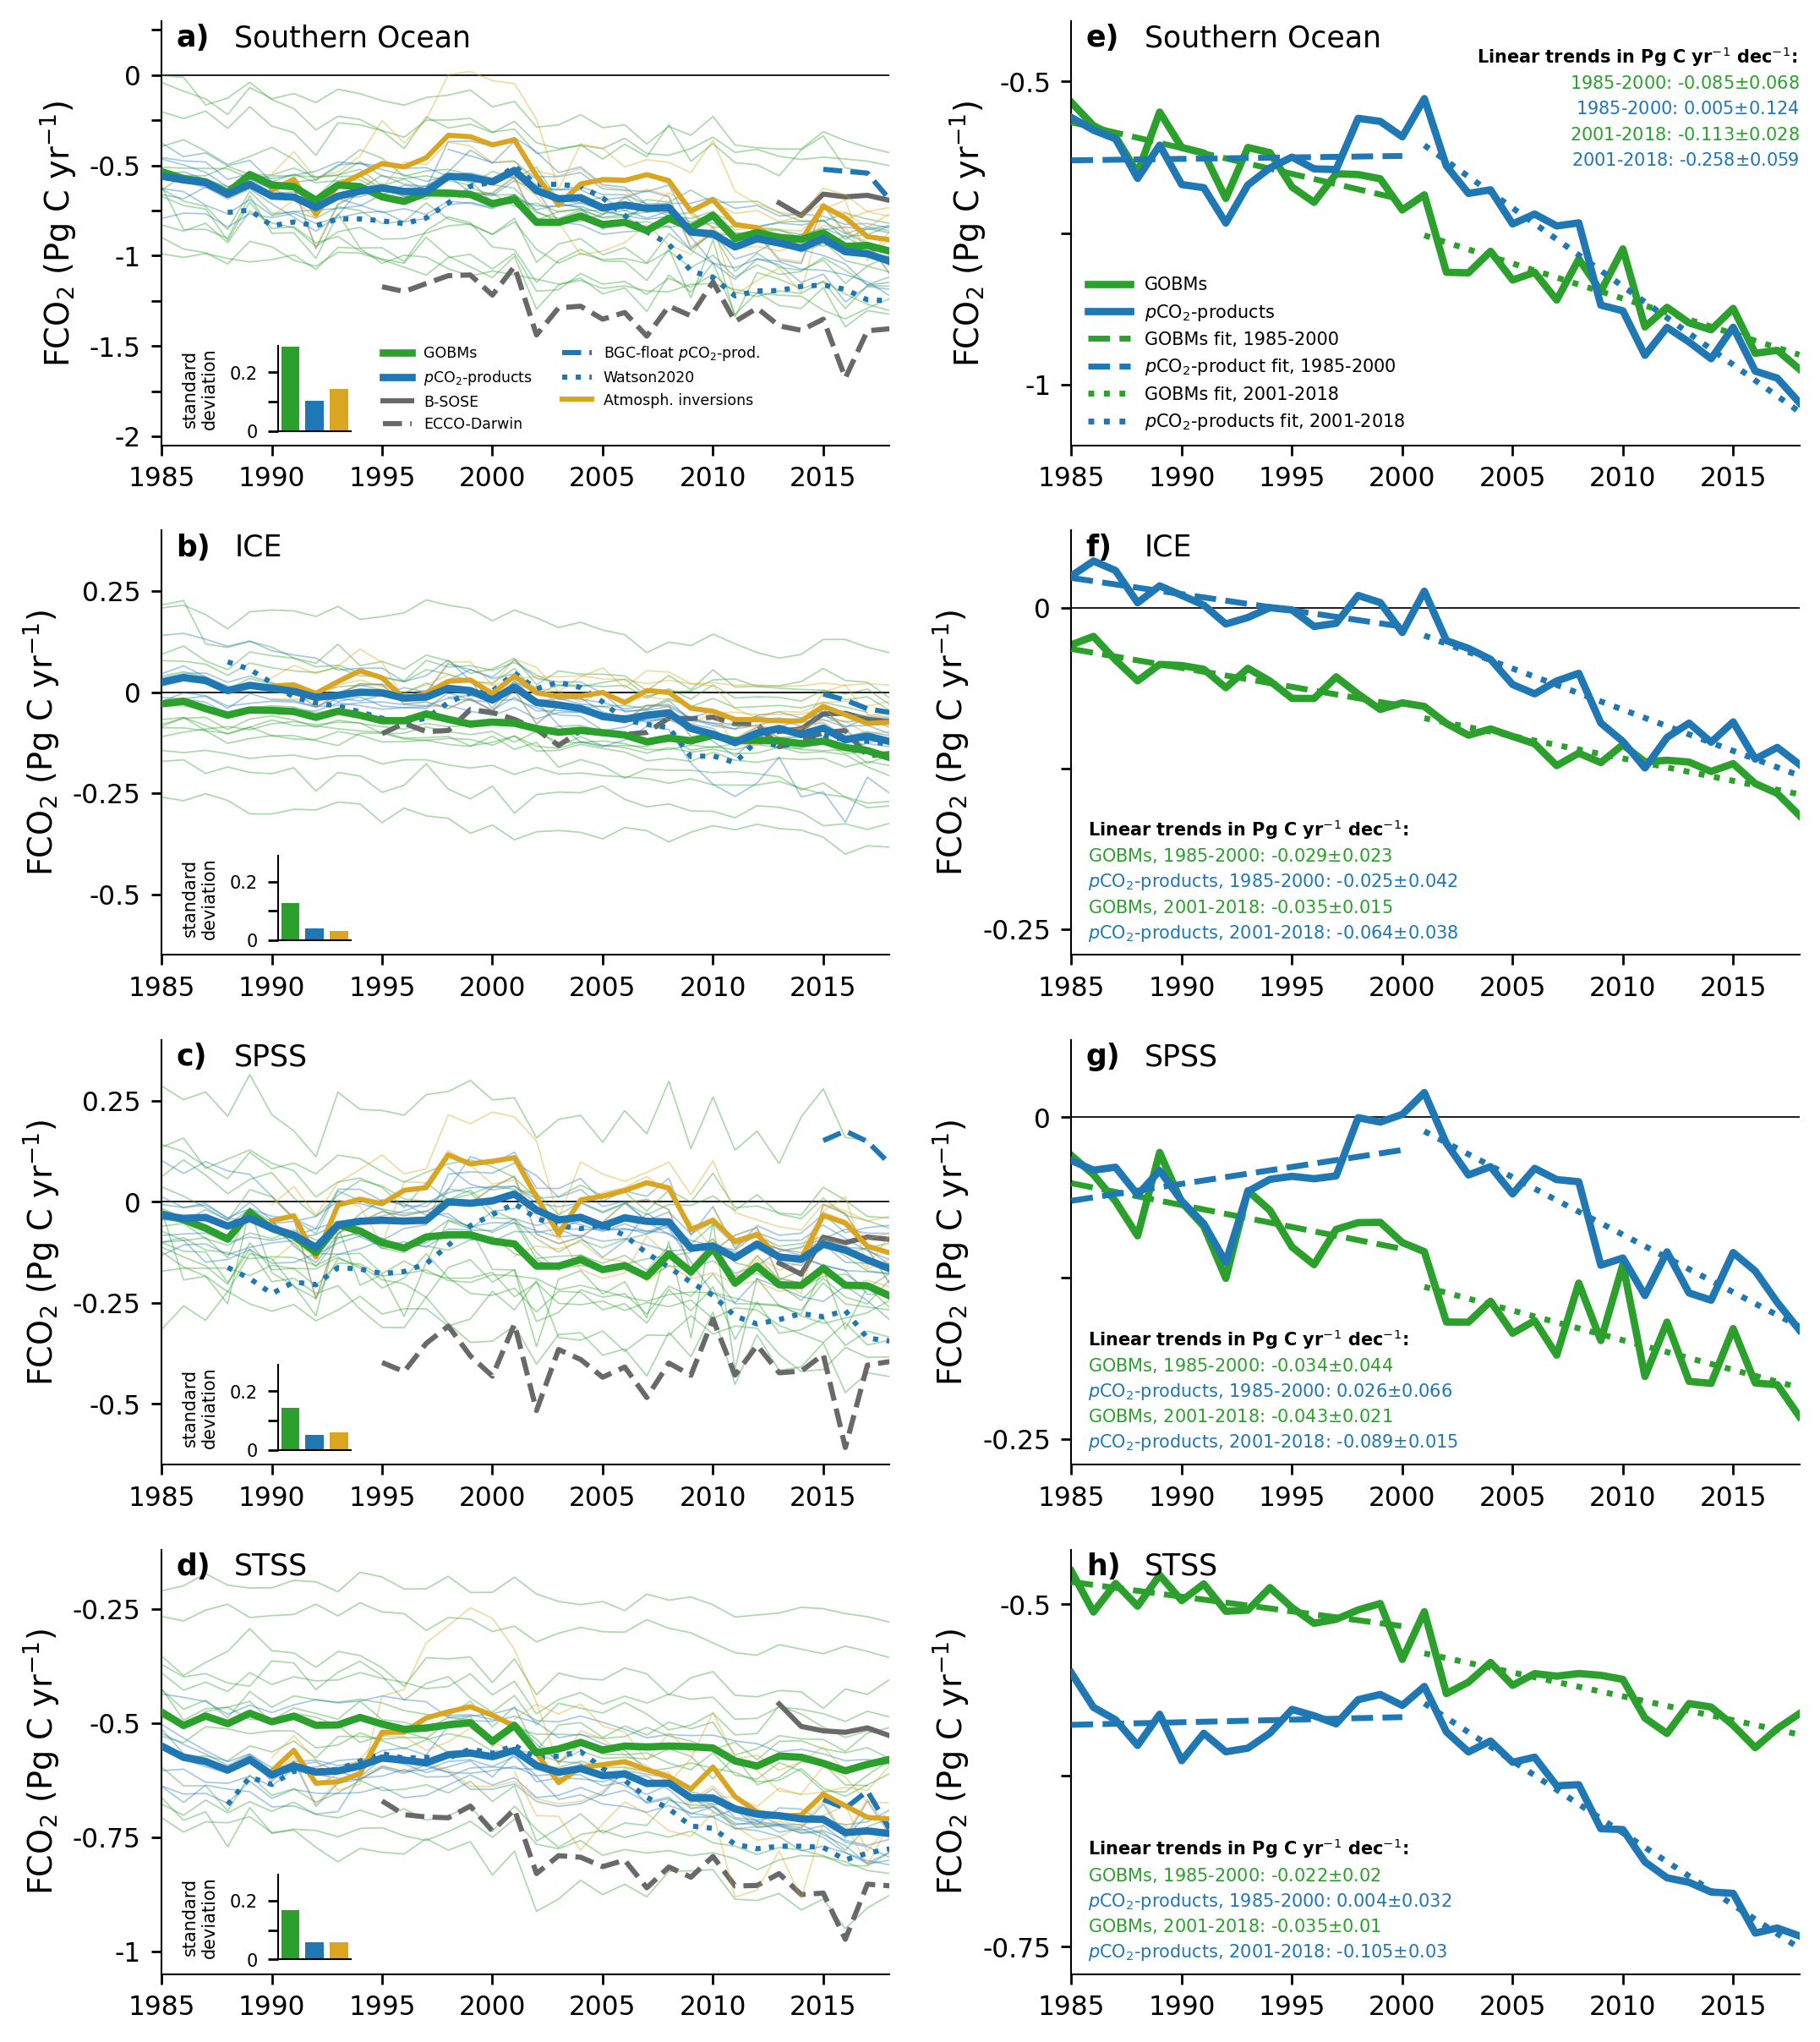

In [23]:
#------
# load trend in simB and plot everything
#-------

# CHECK: the list below should match the one at the very top of this script
models_short = ('CCSM_WHOI','CESM_ETHZ','CNRM_ESM2_1','EC_Earth3','FESOM_REcoM_HR','FESOM_REcoM_LR',\
             'MOM6_Princeton','MPIOM_HAMOCC','MRI_ESM2_1','NorESM_OC1.2',\
             'ORCA025_GEOMAR','ORCA1_LIM3_PISCES','PlankTOM12','ROMS-SouthernOcean-ETHZ')

f1 = Dataset(path_trend+'LinearTrend_1985_2018_CO2_flux_simB.nc')
slope_models = np.zeros([len(models),len(subregions)])
for mm in range(0,len(models)):
    slope_models[mm,:] = f1.variables['trend_fgco2_'+models_short[mm]][:]/10
f1.close()
# order of subregions in file: 
#subregions = ('STSS-Atl','STSS-Ind','STSS-Pac',\
#              'SPSS-Atl','SPSS-Ind','SPSS-Pac',\
#              'ICE-Atl','ICE-Ind','ICE-Pac','STSS','SPSS','ICE','all')

#----
#  load trends 1985-2000 and 2001-2018
#----
f1 = Dataset(path_trend+'LinearTrend_1985_2000_CO2_flux_simB.nc')
slope_models_1985_2000 = np.zeros([len(models),len(subregions)])
for mm in range(0,len(models)):
    slope_models_1985_2000[mm,:] = f1.variables['trend_fgco2_'+models_short[mm]][:]/10
f1.close()
f1 = Dataset(path_trend+'LinearTrend_2001_2018_CO2_flux_simB.nc')
slope_models_2001_2018 = np.zeros([len(models),len(subregions)])
for mm in range(0,len(models)):
    slope_models_2001_2018[mm,:] = f1.variables['trend_fgco2_'+models_short[mm]][:]/10
f1.close()

# trend is in Pg C yr-1 dec-1

# -> divide by 10 to get Pg C yr-1 yr-1
# -> subtract this from flux of each year in sim A -> DOUBLE-CHECK THE SIGN!!!!

#----
# plot for paper: green/blue
#-----

dpicnt = 250

matplotlib.rcParams['axes.linewidth'] = 0.6 #set the value globally
plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})
    
panel_labels = ['a)','d)','c)','b)','e)','h)','g)','f)']

unit    = 'FCO$_{2}$ (Pg C yr$^{-1}$)'
factor2 = -1*365.25*86400.*12.011/1e15 # conversion factor from mol C m-2 s-1 to PgC yr-1


fig, axs = plt.subplots(4,2,figsize=(10,12), dpi=dpicnt,\
                            gridspec_kw={'width_ratios': [1,1],\
                                         'height_ratios': [1,1,1,1]})
plt.subplots_adjust(wspace=0.25)
plt.subplots_adjust(hspace=0.2)

ax1 = plt.subplot2grid((4,2), (0,0))#, colspan=6) # all
ax2 = plt.subplot2grid((4,2), (1,0))#, colspan=6) # STSS
ax3 = plt.subplot2grid((4,2), (2,0))#, colspan=6) # SPSS
ax4 = plt.subplot2grid((4,2), (3,0))#, colspan=6) # ICE

# MMM and MDM with trends pre/post 2000
ax5 = plt.subplot2grid((4,2), (0,1))#, colspan=6) # all
ax6 = plt.subplot2grid((4,2), (1,1))#, colspan=6) # STSS
ax7 = plt.subplot2grid((4,2), (2,1))#, colspan=6) # SPSS
ax8 = plt.subplot2grid((4,2), (3,1))#, colspan=6) # ICE

# transpose arrays for function:
# expected input: data: models x regions x time, data_mean: regions x time; swap dimensions in arrays
flux_models_subareas_plot     = np.transpose(flux_models_subareas,[1,2,0])
flux_data_products_plot       = np.transpose(flux_data_products_subareas,[1,2,0])
flux_data_assim_subareas_plot = np.transpose(flux_data_assim_subareas,[1,2,0])
flux_data_ocim_subareas_plot  = np.transpose(flux_ocim_subareas,[1,2,0])
flux_atminv_subareas_plot  = np.transpose(flux_atminv_subareas,[1,2,0])
## apply model trends
#for mm in range(0,len(models)):
#    for rr in range(0,len(subregions)):
#        for yy in range(0,len(eval_time)):
#            flux_models_subareas_plot[mm,rr,yy] = flux_models_subareas_plot[mm,rr,yy]-slope_models[mm,rr]
## new multi-model-mean
#multi_model_mean_plot = np.mean(flux_models_subareas_plot,axis=0)
multi_model_mean_plot      = np.transpose(multi_model_mean,[1,0])
multi_data_prod_mean_plot  = np.transpose(multi_data_prod_mean,[1,0])
multi_data_assim_mean_plot = np.transpose(multi_data_assim_mean,[1,0])
multi_data_watson_mean_plot = np.transpose(multi_data_watson_mean,[1,0])
multi_atminv_mean_plot = np.transpose(multi_atminv_mean,[1,0])
multi_soccom_mean_plot = np.transpose(multi_soccom_mean,[1,0])
multi_soccom_mean_plot[:,0:-4] = np.nan # only show years 2015-2018 for SOCCOM products



atminv_ocim_on = False
if atminv_ocim_on:
    leg_pos = (0.81, 0.15)
    leg_col = 2
    prop={'size': 5}
else:
    leg_pos = (0.72, 0.135) #(1.01, 0.73)
    #leg_pos = (0.96, 0.82)
    leg_col = 2
    prop={'size': 6}
    
#-----
# all
#-----
ax=ax1
rr = subregions.index("all") # region index
print (subregions[rr])
counter = 1 # if set to 1, print legend
panel_number = 1
panel_label = panel_labels[panel_number-1]
ylim1,ylim2=-2.05,0.3 # -1.8
yticks = [-2,-1.75,-1.5,-1.25,-1,-0.75,-0.5,-0.25,0,0.25]
yticklabels =[-2,'',-1.5,'',-1,'',-0.5,'',0,'']
yticks_on=True

leg_pos = (0.84, 0.135) #(0.72, 0.135) #(1.01, 0.73)
leg_col = 2
prop={'size': 5.0}

##left, bottom, width, height = [0.25, 0.6, 0.2, 0.2]
#ax2 = fig.add_axes([left, bottom, width, height])
    
subroutine_plotting_time_series_1region_w_simB(ax,area_mean_watson[rr],area_mean_soccom[rr],\
                                                multi_data_watson_mean_plot[rr,:],\
                                                multi_soccom_mean_plot[rr,:],\
                                               multi_atminv_mean_plot[rr,:],\
                                               area_mean_atminv[rr],\
                                                biome_area_models[:,rr],\
                                        np.transpose(biome_area_data_products_varying[:,:,rr]),\
                                                biome_area_data_assim[:,rr],biome_area_ocim[:,rr],\
                                                biome_area_atminv[:,rr],\
                                                flux_models_subareas_plot[:,rr,:],\
                                                flux_data_products_plot[:,rr,:],\
                                                flux_data_assim_subareas_plot[:,rr,:],\
                                                flux_data_ocim_subareas_plot[:,rr,:],\
                                                flux_atminv_subareas_plot[:,rr,:],\
                                        add_to_models[rr],biome_area_river[rr],\
                                                models,data_prod,data_assim,data_ocim,data_atminv,\
                                               eval_time,factor2,unit,\
                                       'Southern Ocean',panel_label,counter,atminv_ocim_on,\
                                        yticks_on,ylim1,ylim2,yticks,yticklabels,leg_pos,leg_col,prop,\
                                               slope_models[:,rr])

#-----
# STSS
#-----
ax=ax4
#ax.set_axis_off()
rr = subregions.index("STSS") # region index
print (subregions[rr])
counter = 0 # if set to 1, print legend
panel_number = 2
panel_label = panel_labels[panel_number-1]
ylim1,ylim2=-1.05,-0.12 # -1.3, 0
yticks = [-1,-0.75,-0.5,-0.25]#,0]
yticklabels =[-1,-0.75,-0.5,-0.25]#,0]
yticks_on=True
subroutine_plotting_time_series_1region_w_simB(ax,area_mean_watson[rr],area_mean_soccom[rr],\
                                                multi_data_watson_mean_plot[rr,:],\
                                                multi_soccom_mean_plot[rr,:],\
                                                multi_atminv_mean_plot[rr,:],\
                                               area_mean_atminv[rr],\
                                                biome_area_models[:,rr],\
                                        np.transpose(biome_area_data_products_varying[:,:,rr]),\
                                                biome_area_data_assim[:,rr],biome_area_ocim[:,rr],\
                                                biome_area_atminv[:,rr],\
                                                flux_models_subareas_plot[:,rr,:],\
                                                flux_data_products_plot[:,rr,:],\
                                                flux_data_assim_subareas_plot[:,rr,:],\
                                                flux_data_ocim_subareas_plot[:,rr,:],\
                                                flux_atminv_subareas_plot[:,rr,:],\
                                        add_to_models[rr],biome_area_river[rr],\
                                                models,data_prod,data_assim,data_ocim,data_atminv,\
                                               eval_time,factor2,unit,\
                                       subregions[rr],panel_label,counter,atminv_ocim_on,\
                                        yticks_on,ylim1,ylim2,yticks,yticklabels,leg_pos,leg_col,\
                                               prop,slope_models[:,rr])

# same yticks etc for the three subregions: 
if atminv_ocim_on:
    ylim1,ylim2=-1.0,0.4
    yticks = [-1.0,-0.75,-0.5,-0.25,0,0.25]
    yticklabels =[-1,'',-0.5,'',0,'']
else:
    #ylim1,ylim2=-0.75,0.5
    #yticks = [0.75,-0.5,-0.25,0,0.25,0.5]
    #yticklabels =['',-0.5,'',0,'',0.5]
    ylim1,ylim2=-0.65,0.4
    yticks = [-0.5,-0.25,0,0.25]
    yticklabels =[-0.5,'',0,'']
    
#-----
# SPSS
#-----
ax=ax3
#ax.set_axis_off()
rr = subregions.index("SPSS") # region index
print (subregions[rr])
counter = 0 # if set to 1, print legend
panel_number = 3
panel_label = panel_labels[panel_number-1]
ylim1,ylim2=-0.65,0.4
yticks = [-0.5,-0.25,0,0.25]
yticklabels =[-0.5,-0.25,0,0.25]
yticks_on=True
subroutine_plotting_time_series_1region_w_simB(ax,area_mean_watson[rr],area_mean_soccom[rr],\
                                                multi_data_watson_mean_plot[rr,:],\
                                                multi_soccom_mean_plot[rr,:],\
                                                multi_atminv_mean_plot[rr,:],\
                                               area_mean_atminv[rr],\
                                                biome_area_models[:,rr],\
                                        np.transpose(biome_area_data_products_varying[:,:,rr]),\
                                                biome_area_data_assim[:,rr],biome_area_ocim[:,rr],\
                                                biome_area_atminv[:,rr],\
                                                flux_models_subareas_plot[:,rr,:],\
                                                flux_data_products_plot[:,rr,:],\
                                                flux_data_assim_subareas_plot[:,rr,:],\
                                                flux_data_ocim_subareas_plot[:,rr,:],\
                                                flux_atminv_subareas_plot[:,rr,:],\
                                        add_to_models[rr],biome_area_river[rr],\
                                                models,data_prod,data_assim,data_ocim,data_atminv,\
                                               eval_time,factor2,unit,\
                                       subregions[rr],panel_label,counter,atminv_ocim_on,\
                                        yticks_on,ylim1,ylim2,yticks,yticklabels,leg_pos,leg_col,prop,\
                                               slope_models[:,rr])
#-----
# ICE
#-----
leg_pos = (0.95, 0.135) #(0.72, 0.135) #(1.01, 0.73)
leg_col = 2
prop={'size': 6}

ax=ax2
#ax.set_axis_off()
rr = subregions.index("ICE") # region index
print (subregions[rr])
counter = 0 # if set to 1, print legend
panel_number = 4
panel_label = panel_labels[panel_number-1]
ylim1,ylim2=-0.65,0.4
yticks = [-0.5,-0.25,0,0.25]
yticklabels =[-0.5,-0.25,0,0.25]
yticks_on=True
subroutine_plotting_time_series_1region_w_simB(ax,area_mean_watson[rr],area_mean_soccom[rr],\
                                                multi_data_watson_mean_plot[rr,:],\
                                                multi_soccom_mean_plot[rr,:],\
                                                multi_atminv_mean_plot[rr,:],\
                                               area_mean_atminv[rr],\
                                                biome_area_models[:,rr],\
                                        np.transpose(biome_area_data_products_varying[:,:,rr]),\
                                                biome_area_data_assim[:,rr],biome_area_ocim[:,rr],\
                                                biome_area_atminv[:,rr],\
                                                flux_models_subareas_plot[:,rr,:],\
                                                flux_data_products_plot[:,rr,:],\
                                                flux_data_assim_subareas_plot[:,rr,:],\
                                                flux_data_ocim_subareas_plot[:,rr,:],\
                                                flux_atminv_subareas_plot[:,rr,:],\
                                        add_to_models[rr],biome_area_river[rr],\
                                                models,data_prod,data_assim,data_ocim,data_atminv,\
                                               eval_time,factor2,unit,\
                                       subregions[rr],panel_label,counter,atminv_ocim_on,\
                                        yticks_on,ylim1,ylim2,yticks,yticklabels,leg_pos,leg_col,prop,\
                                               slope_models[:,rr])    
    
    
#----
# only MMM and MDM with trend pre/post 2000
#----

# bottom left
leg_pos = (0.48, 0.215)  #(0.46, 0.215) 
leg_col = 1
prop={'size': 6}

## top right
#leg_pos = (1.0, 0.8) 
#leg_col = 1
#prop={'size': 5.5}
    
    
ax=ax5
rr = subregions.index("all") # region index
print ('')    
print (subregions[rr])
counter = 1 # if set to 1, print legend
panel_number = 5
panel_label = panel_labels[panel_number-1]
ylim1,ylim2=-1.1,-0.4
yticks = [-1,-0.75,-0.5]
yticklabels =[-1,'',-0.5]
#ylim1,ylim2=-1.8,0.3
#yticks = [-1.75,-1.5,-1.25,-1,-0.75,-0.5,-0.25,0,0.25]
#yticklabels =['',-1.5,'',-1,'',-0.5,'',0,'']
yticks_on=True
subroutine_plotting_time_series_1region_MMM_MDM_w_simB(ax,biome_area_models[:,rr],\
                                                       np.transpose(biome_area_data_products_varying[:,:,rr]),\
                                                flux_models_subareas_plot[:,rr,:],\
                                                flux_data_products_plot[:,rr,:],\
                                                add_to_models[rr],biome_area_river[rr],\
                                                models,data_prod,\
                                               eval_time,factor2,unit,\
                                       'Southern Ocean',panel_label,counter,\
                                            yticks_on,ylim1,ylim2,yticks,yticklabels,\
                                                   leg_pos,leg_col,prop,slope_models[:,rr],\
                                                      slope_models_1985_2000[:,rr],\
                                              slope_models_2001_2018[:,rr])


ax=ax8
#ax.set_axis_off()
rr = subregions.index("STSS") # region index
print ('')    
print (subregions[rr])
counter = 0 # if set to 1, print legend
panel_number = 6
panel_label = panel_labels[panel_number-1]
ylim1,ylim2=-0.77,-0.46
yticks = [-0.75,-0.625,-0.5,]
yticklabels =[-0.75,'',-0.5]
#yticks = [-0.7,-0.6,-0.5,]
#yticklabels =[-0.7,-0.6,-0.5]
#ylim1,ylim2=-1.3,-0.0
#yticks = [-1,-0.75,-0.5,-0.25,0]
#yticklabels =[-1,'',-0.5,'',0]
yticks_on=True
subroutine_plotting_time_series_1region_MMM_MDM_w_simB(ax,biome_area_models[:,rr],\
                                                       np.transpose(biome_area_data_products_varying[:,:,rr]),\
                                                flux_models_subareas_plot[:,rr,:],\
                                                flux_data_products_plot[:,rr,:],\
                                                add_to_models[rr],biome_area_river[rr],\
                                                models,data_prod,\
                                               eval_time,factor2,unit,\
                                       subregions[rr],panel_label,counter,\
                                            yticks_on,ylim1,ylim2,yticks,yticklabels,\
                                                   leg_pos,leg_col,prop,slope_models[:,rr],\
                                                      slope_models_1985_2000[:,rr],\
                                              slope_models_2001_2018[:,rr])
    
#-----
# SPSS
#-----
ax=ax7
#ax.set_axis_off()
rr = subregions.index("SPSS") # region index
print ('')    
print (subregions[rr])
counter = 0 # if set to 1, print legend
panel_number = 7
panel_label = panel_labels[panel_number-1]
ylim1,ylim2=-0.27,0.06
yticks = [-0.25,-0.125,0]
yticklabels =[-0.25,'',0]
#yticks = [-0.2,-0.1,0]
#yticklabels =[-0.2,-0.1,0]
yticks_on=True
subroutine_plotting_time_series_1region_MMM_MDM_w_simB(ax,biome_area_models[:,rr],\
                                                       np.transpose(biome_area_data_products_varying[:,:,rr]),\
                                                flux_models_subareas_plot[:,rr,:],\
                                                flux_data_products_plot[:,rr,:],\
                                                add_to_models[rr],biome_area_river[rr],\
                                                models,data_prod,\
                                               eval_time,factor2,unit,\
                                       subregions[rr],panel_label,counter,\
                                            yticks_on,ylim1,ylim2,yticks,yticklabels,\
                                                   leg_pos,leg_col,prop,slope_models[:,rr],\
                                                      slope_models_1985_2000[:,rr],\
                                              slope_models_2001_2018[:,rr])

ax=ax6
#ax.set_axis_off()
rr = subregions.index("ICE") # region index
print ('')    
print (subregions[rr])
counter = 0 # if set to 1, print legend
panel_number = 8
panel_label = panel_labels[panel_number-1]
#ylim1,ylim2=-0.16,0.055
#yticks = [-0.15,-0.1,-0.05,0]
#yticklabels =[-0.15,-0.1,-0.05,0]
ylim1,ylim2=-0.27,0.06
yticks = [-0.25,-0.125,0]
yticklabels =[-0.25,'',0]
yticks_on=True
subroutine_plotting_time_series_1region_MMM_MDM_w_simB(ax,biome_area_models[:,rr],\
                                                       np.transpose(biome_area_data_products_varying[:,:,rr]),\
                                                flux_models_subareas_plot[:,rr,:],\
                                                flux_data_products_plot[:,rr,:],\
                                                add_to_models[rr],biome_area_river[rr],\
                                                models,data_prod,\
                                               eval_time,factor2,unit,\
                                       subregions[rr],panel_label,counter,\
                                            yticks_on,ylim1,ylim2,yticks,yticklabels,\
                                                   leg_pos,leg_col,prop,slope_models[:,rr],\
                                                      slope_models_1985_2000[:,rr],\
                                              slope_models_2001_2018[:,rr])

if river_adjustment:
    river_name = '_wRiver_Adjustment'
else:
    river_name = ''
    
if atminv_ocim_on: 
    filename1 = 'fig8_time_series_CO2_flux_avg_'+str(year1)+'_'+str(year2)+\
    '_wShading_std_wOCIM_wAtmInv_2x2_panels'+river_name+'_drift_corrected'
else:
    filename1 = 'fig8_time_series_CO2_flux_avg_'+str(year1)+'_'+str(year2)+\
    '_wShading_std_2x2_panels'+river_name+'_drift_corrected'
print (filename1)
    
plt.savefig(save_to_dir+filename1+'.png',dpi = dpicnt, bbox_inches='tight',format='png')
plt.savefig(save_to_dir+filename1+'.pdf',dpi = dpicnt, bbox_inches='tight',format='pdf')
plt.show()





In [24]:

rr = -3
print (subregions[rr])
for mm in range(0,len(models)):
    print (models[mm],slope_models[mm,rr],slope_models_1985_2000[mm,rr],slope_models_2001_2018[mm,rr] )
    
    

SPSS
CCSM-WHOI -0.000596534984651953 -0.000793502083979547 -0.0006766350707039237
CESM-ETHZ 1.243532187800156e-05 1.374266685161274e-05 2.9953949706396088e-05
CNRM-ESM2-1 8.33383746794425e-05 6.446985935326666e-05 0.00010099915380124003
EC-Earth3 8.325365342898294e-05 0.00010999506048392504 5.579723438131623e-05
FESOM_REcoM_HR -0.00376293552108109 -0.011097574606537819 0.0008871678146533668
FESOM_REcoM_LR -0.0017048877198249102 -0.0017615724354982376 -0.0015282046515494585
MOM6-Princeton 0.0006408104090951383 0.0014616026310250163 -0.0005076351226307452
MPIOM-HAMOCC -0.0005810760194435716 -4.101736340089701e-05 3.776641460717656e-05
MRI-ESM2-1 -7.600765093229711e-05 -7.691951032029465e-05 -7.894206646597013e-05
NorESM-OC1.2 -0.0003429623320698738 -0.000325723085552454 -0.0003114418941549957
ORCA025-GEOMAR 7.160394306993112e-05 0.00010177156946156174 0.00014032836770638824
ORCA1-LIM3-PISCES 0.0001241978316102177 0.0016621988033875823 -0.001328068901784718
PlankTOM12 1.1973027540079784e-

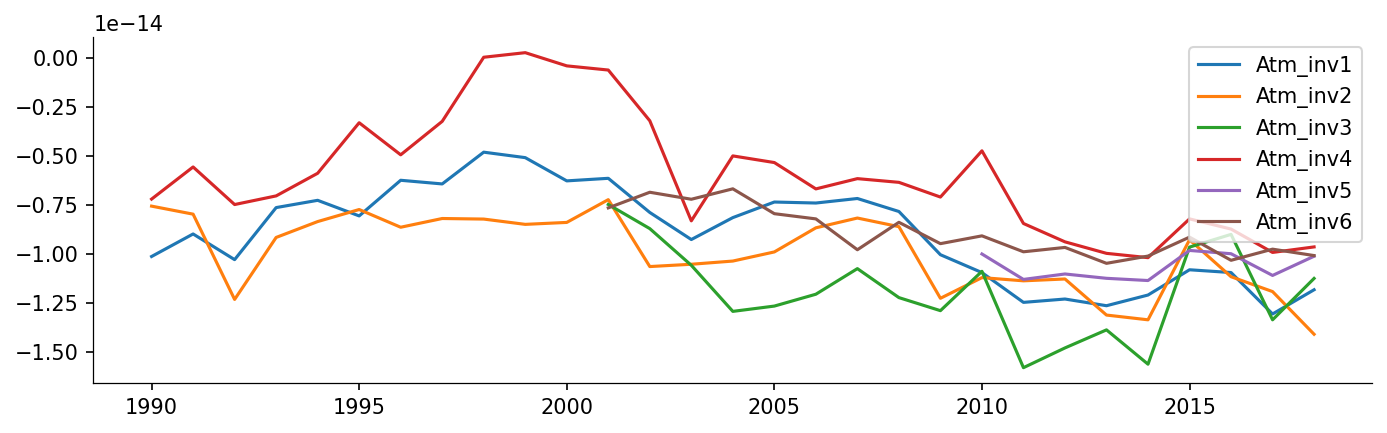

In [25]:
#----
# plot time series of all atm. inversions (not polished)
#---- 

rr = subregions.index("all") # region index
aa = flux_atminv_subareas_plot[:,rr,:]

plt.figure(figsize=(11,3), dpi=150, facecolor='w', edgecolor='k')
for ii in range(0,6):
    plt.plot(eval_time,-1*aa[ii,:],label=data_atminv[ii])
plt.legend()
plt.show()


STSS-Atl
Comparison with and without drift correction:
FESOM_REcoM_LR
drift: -2.6930862077279016e-05
first year, with correction vs without correction: -0.27211303799912295 -0.27213996886120023
last year, with correction vs without correction: -0.3102451696249885 -0.31027210048706577
with drift corr, MMM, first/last year: -0.18445967093510235 -0.20761123086232383
no drift corr, MMM, first/last year: -0.1845028275918669 -0.20766031549151293

last year for models, data: -0.20761123086232383 -0.23790117995251828
-0.2237251619007471
Mean std models,obs: 0.06621976095629306 0.021677125498683034
STSS-Ind
Comparison with and without drift correction:
FESOM_REcoM_LR
drift: -8.433144830632955e-05
first year, with correction vs without correction: -0.2550665467856206 -0.2551508782339269
last year, with correction vs without correction: -0.29463785026578015 -0.2947221817140865
with drift corr, MMM, first/last year: -0.18167191613617964 -0.21833368540966477
no drift corr, MMM, first/last year: -0.

/tmp/ipykernel_459263/704476052.py:563: RuntimeWarning: Mean of empty slice
  atminv_mean  = np.nanmean(area_2d_atminv[ind_list,:]*(-1)*data_atminv_all[ind_list,:],axis=0)
/global/homes/c/cnissen/.conda/envs/myenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_459263/704476052.py:563: RuntimeWarning: Mean of empty slice
  atminv_mean  = np.nanmean(area_2d_atminv[ind_list,:]*(-1)*data_atminv_all[ind_list,:],axis=0)
/global/homes/c/cnissen/.conda/envs/myenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_459263/704476052.py:563: RuntimeWarning: Mean of empty slice
  atminv_mean  = np.nanmean(area_2d_atminv[ind_list,:]*(-1)*data_atminv_all[ind_list,:],axis=0)
/global/homes/c/cnissen/.conda/envs/myenv/lib/python3.

SPSS-Atl
Comparison with and without drift correction:
FESOM_REcoM_LR
drift: -0.00021194273722358048
first year, with correction vs without correction: -0.05286449595368536 -0.05307643869090894
last year, with correction vs without correction: -0.11453979579957471 -0.11475173853679829
with drift corr, MMM, first/last year: -0.06100193498180071 -0.10069535832588981
no drift corr, MMM, first/last year: -0.061152489513789196 -0.10085483729048815

last year for models, data: -0.10069535832588981 -0.08707238581517404
-0.05308897759147569
Mean std models,obs: 0.033804273379200805 0.01573120579735664
SPSS-Ind
Comparison with and without drift correction:
FESOM_REcoM_LR
drift: -0.001035693334415555
first year, with correction vs without correction: -0.016236723459563486 -0.01727241679397904
last year, with correction vs without correction: -0.08908669175564662 -0.09012238509006218
with drift corr, MMM, first/last year: 0.029908936302883285 -0.04335406038533867
no drift corr, MMM, first/last ye

/tmp/ipykernel_459263/704476052.py:563: RuntimeWarning: Mean of empty slice
  atminv_mean  = np.nanmean(area_2d_atminv[ind_list,:]*(-1)*data_atminv_all[ind_list,:],axis=0)
/global/homes/c/cnissen/.conda/envs/myenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_459263/704476052.py:563: RuntimeWarning: Mean of empty slice
  atminv_mean  = np.nanmean(area_2d_atminv[ind_list,:]*(-1)*data_atminv_all[ind_list,:],axis=0)
/global/homes/c/cnissen/.conda/envs/myenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_459263/704476052.py:563: RuntimeWarning: Mean of empty slice
  atminv_mean  = np.nanmean(area_2d_atminv[ind_list,:]*(-1)*data_atminv_all[ind_list,:],axis=0)
/global/homes/c/cnissen/.conda/envs/myenv/lib/python3.

Mean std models,obs: 0.04070637065198865 0.016022270717465818
fig8_time_series_CO2_flux_avg_1985_2018_wShading_std_9_regions_wRiver_Adjustment_drift_corrected.png


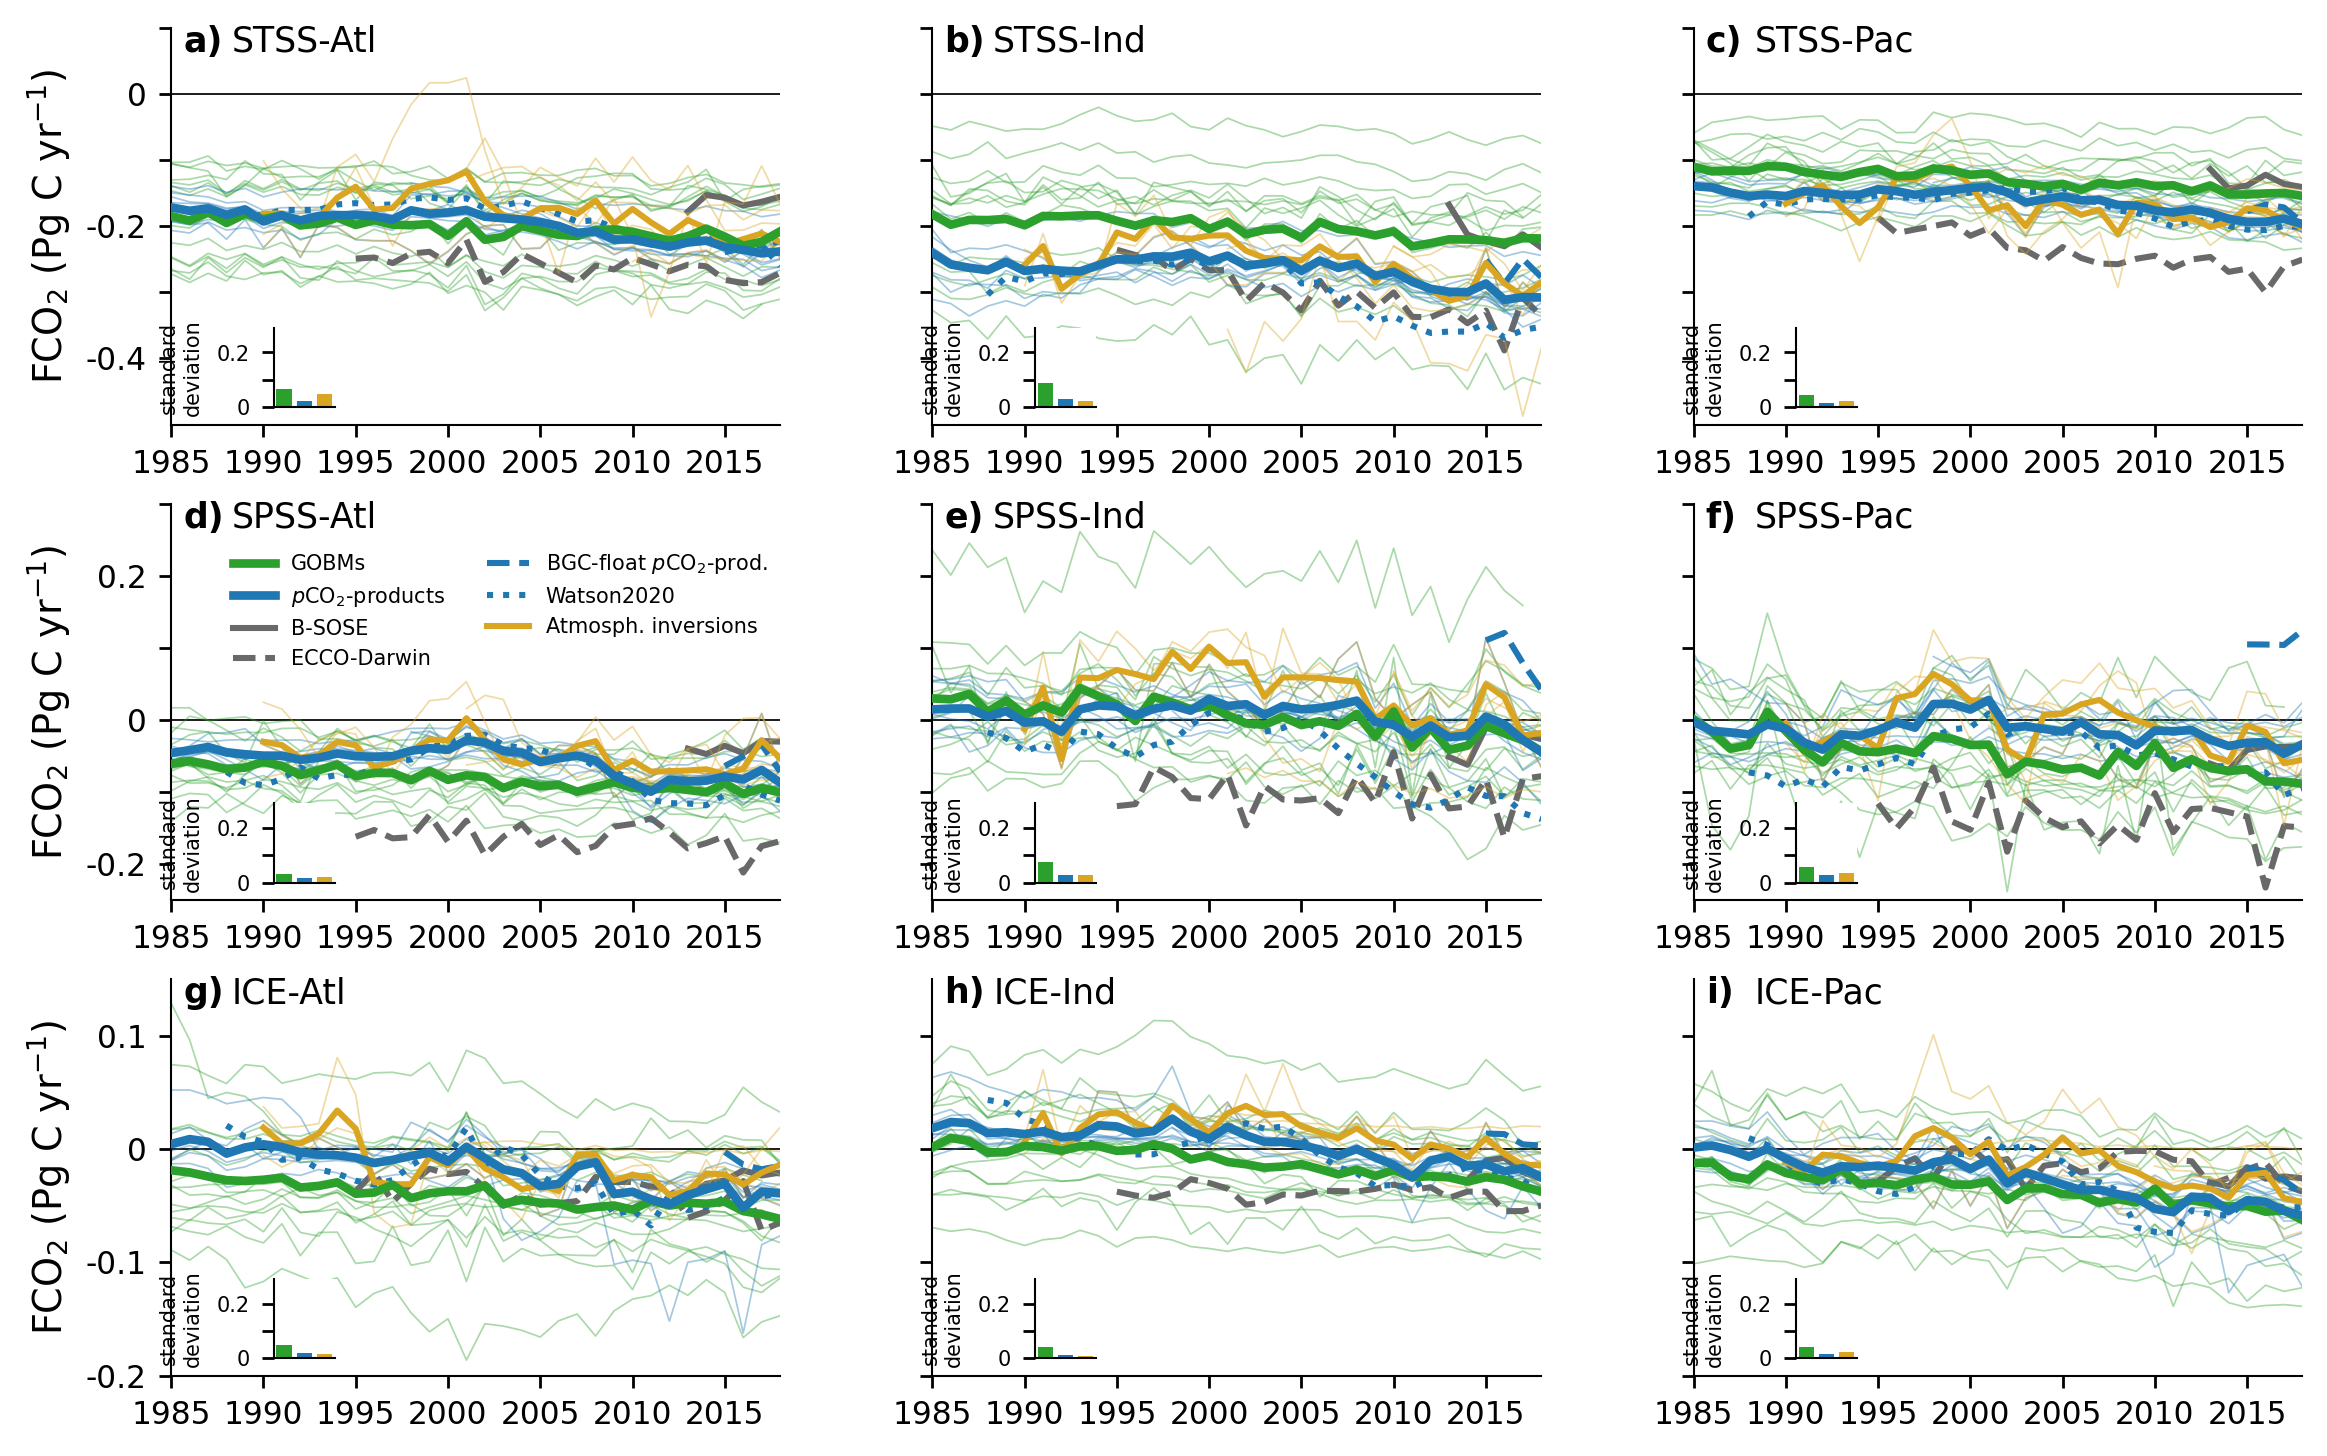

In [26]:
#------
# load trend in simB -> 9 regions
#-------

# CHECK: the list below should match the one at the very top of this script
models_short = ('CCSM_WHOI','CESM_ETHZ','CNRM_ESM2_1','EC_Earth3','FESOM_REcoM_HR','FESOM_REcoM_LR',\
             'MOM6_Princeton','MPIOM_HAMOCC','MRI_ESM2_1','NorESM_OC1.2',\
             'ORCA025_GEOMAR','ORCA1_LIM3_PISCES','PlankTOM12','ROMS-SouthernOcean-ETHZ')

f1 = Dataset(path_trend+'LinearTrend_1985_2018_CO2_flux_simB.nc')

slope_models = np.zeros([len(models),len(subregions)])
for mm in range(0,len(models)):
    slope_models[mm,:] = f1.variables['trend_fgco2_'+models_short[mm]][:]/10
f1.close()
# order of subregions in file: 
#subregions = ('STSS-Atl','STSS-Ind','STSS-Pac',\
#              'SPSS-Atl','SPSS-Ind','SPSS-Pac',\
#              'ICE-Atl','ICE-Ind','ICE-Pac','STSS','SPSS','ICE','all')


# trend is in Pg C yr-1 dec-1

# -> divide by 10 to get Pg C yr-1 yr-1
# -> subtract this from flux of each year in sim A -> DOUBLE-CHECK THE SIGN!!!!

#----
# plot for paper: green/blue
#-----

dpicnt = 250

matplotlib.rcParams['axes.linewidth'] = 0.6 #set the value globally
plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})


unit    = 'FCO$_{2}$ (Pg C yr$^{-1}$)'
factor2 = -1*365.25*86400.*12.011/1e15 # conversion factor from mol C m-2 s-1 to PgC yr-1

panel_labels = ['a)','b)','c)','d)','e)','f)','g)','h)','i)']

fig, axs = plt.subplots(3,3,figsize=(11,7), dpi=dpicnt,\
                            gridspec_kw={'width_ratios': [1,1,1],\
                                         'height_ratios': [1,1,1]})
plt.subplots_adjust(wspace=0.25)
plt.subplots_adjust(hspace=0.2)

# STSS
ax1 = plt.subplot2grid((3,3), (0,0))
ax2 = plt.subplot2grid((3,3), (0,1))
ax3 = plt.subplot2grid((3,3), (0,2))
# SPSS
ax4 = plt.subplot2grid((3,3), (1,0))
ax5 = plt.subplot2grid((3,3), (1,1))
ax6 = plt.subplot2grid((3,3), (1,2))
# ICE
ax7 = plt.subplot2grid((3,3), (2,0))
ax8 = plt.subplot2grid((3,3), (2,1))
ax9 = plt.subplot2grid((3,3), (2,2))


# transpose arrays for function:
# expected input: data: models x regions x time, data_mean: regions x time; swap dimensions in arrays
flux_models_subareas_plot     = np.transpose(flux_models_subareas,[1,2,0])
flux_data_products_plot       = np.transpose(flux_data_products_subareas,[1,2,0])
flux_data_assim_subareas_plot = np.transpose(flux_data_assim_subareas,[1,2,0])
flux_data_ocim_subareas_plot  = np.transpose(flux_ocim_subareas,[1,2,0])
flux_atminv_subareas_plot  = np.transpose(flux_atminv_subareas,[1,2,0])
## apply model trends
#for mm in range(0,len(models)):
#    for rr in range(0,len(subregions)):
#        for yy in range(0,len(eval_time)):
#            flux_models_subareas_plot[mm,rr,yy] = flux_models_subareas_plot[mm,rr,yy]-slope_models[mm,rr]
## new multi-model-mean
#multi_model_mean_plot = np.mean(flux_models_subareas_plot,axis=0)
multi_model_mean_plot      = np.transpose(multi_model_mean,[1,0])
multi_data_prod_mean_plot  = np.transpose(multi_data_prod_mean,[1,0])
multi_data_assim_mean_plot = np.transpose(multi_data_assim_mean,[1,0])
multi_data_watson_mean_plot = np.transpose(multi_data_watson_mean,[1,0])
multi_soccom_mean_plot = np.transpose(multi_soccom_mean,[1,0])
multi_soccom_mean_plot[:,0:-4] = np.nan # only show years 2015-2018 for SOCCOM products

leg_pos = (1.01, 0.73) #(1.01, 0.73),(0.72, 0.135)
leg_col = 2
prop={'size': 6}
    
#-----
# STSS subregions
#-----
ylim1,ylim2=-0.5,0.1
yticks = [-0.4,-0.3,-0.2,-0.1,0,0.1]
yticklabels =[-0.4,'',-0.2,'',0,'']

ax=ax1
rr = subregions.index("STSS-Atl") # region index
print (subregions[rr])
counter = 0 # if set to 1, print legend
panel_number = 1
panel_label = panel_labels[panel_number-1]
yticks_on=True

subroutine_plotting_time_series_1region_w_simB(ax,area_mean_watson[rr],area_mean_soccom[rr],\
                                                multi_data_watson_mean_plot[rr,:],\
                                                multi_soccom_mean_plot[rr,:],\
                                               multi_atminv_mean_plot[rr,:],\
                                               area_mean_atminv[rr],\
                                                biome_area_models[:,rr],\
                                        np.transpose(biome_area_data_products_varying[:,:,rr]),\
                                                biome_area_data_assim[:,rr],biome_area_ocim[:,rr],\
                                                biome_area_atminv[:,rr],\
                                                flux_models_subareas_plot[:,rr,:],\
                                                flux_data_products_plot[:,rr,:],\
                                                flux_data_assim_subareas_plot[:,rr,:],\
                                                flux_data_ocim_subareas_plot[:,rr,:],\
                                                flux_atminv_subareas_plot[:,rr,:],\
                                        add_to_models[rr],biome_area_river[rr],\
                                                models,data_prod,data_assim,data_ocim,data_atminv,\
                                               eval_time,factor2,unit,\
                                       subregions[rr],panel_label,counter,atminv_ocim_on,\
                                        yticks_on,ylim1,ylim2,yticks,yticklabels,leg_pos,leg_col,prop,\
                                               slope_models[:,rr])

ax=ax2
rr = subregions.index("STSS-Ind") # region index
print (subregions[rr])
counter = 0 # if set to 1, print legend
panel_number = 2
panel_label = panel_labels[panel_number-1]
yticks_on=False
subroutine_plotting_time_series_1region_w_simB(ax,area_mean_watson[rr],area_mean_soccom[rr],\
                                                multi_data_watson_mean_plot[rr,:],\
                                                multi_soccom_mean_plot[rr,:],\
                                               multi_atminv_mean_plot[rr,:],\
                                               area_mean_atminv[rr],\
                                                biome_area_models[:,rr],\
                                        np.transpose(biome_area_data_products_varying[:,:,rr]),\
                                                biome_area_data_assim[:,rr],biome_area_ocim[:,rr],\
                                                biome_area_atminv[:,rr],\
                                                flux_models_subareas_plot[:,rr,:],\
                                                flux_data_products_plot[:,rr,:],\
                                                flux_data_assim_subareas_plot[:,rr,:],\
                                                flux_data_ocim_subareas_plot[:,rr,:],\
                                                flux_atminv_subareas_plot[:,rr,:],\
                                        add_to_models[rr],biome_area_river[rr],\
                                                models,data_prod,data_assim,data_ocim,data_atminv,\
                                               eval_time,factor2,unit,\
                                       subregions[rr],panel_label,counter,atminv_ocim_on,\
                                        yticks_on,ylim1,ylim2,yticks,yticklabels,leg_pos,leg_col,prop,\
                                               slope_models[:,rr])

ax=ax3
rr = subregions.index("STSS-Pac") # region index
print (subregions[rr])
counter = 0 # if set to 1, print legend
panel_number = 3
panel_label = panel_labels[panel_number-1]
yticks_on=False
subroutine_plotting_time_series_1region_w_simB(ax,area_mean_watson[rr],area_mean_soccom[rr],\
                                                multi_data_watson_mean_plot[rr,:],\
                                                multi_soccom_mean_plot[rr,:],\
                                               multi_atminv_mean_plot[rr,:],\
                                               area_mean_atminv[rr],\
                                                biome_area_models[:,rr],\
                                        np.transpose(biome_area_data_products_varying[:,:,rr]),\
                                                biome_area_data_assim[:,rr],biome_area_ocim[:,rr],\
                                                biome_area_atminv[:,rr],\
                                                flux_models_subareas_plot[:,rr,:],\
                                                flux_data_products_plot[:,rr,:],\
                                                flux_data_assim_subareas_plot[:,rr,:],\
                                                flux_data_ocim_subareas_plot[:,rr,:],\
                                                flux_atminv_subareas_plot[:,rr,:],\
                                        add_to_models[rr],biome_area_river[rr],\
                                                models,data_prod,data_assim,data_ocim,data_atminv,\
                                               eval_time,factor2,unit,\
                                       subregions[rr],panel_label,counter,atminv_ocim_on,\
                                        yticks_on,ylim1,ylim2,yticks,yticklabels,leg_pos,leg_col,prop,\
                                               slope_models[:,rr])

#-----
# SPSS subregions
#-----
ylim1,ylim2=-0.25,0.3
yticks = [-0.2,-0.1,0,0.1,0.2,0.3]
yticklabels =[-0.2,'',0,'',0.2,'']

ax=ax4
rr = subregions.index("SPSS-Atl") # region index
print (subregions[rr])
counter = 1 # if set to 1, print legend
panel_number = 4
panel_label = panel_labels[panel_number-1]
yticks_on=True
subroutine_plotting_time_series_1region_w_simB(ax,area_mean_watson[rr],area_mean_soccom[rr],\
                                                multi_data_watson_mean_plot[rr,:],\
                                                multi_soccom_mean_plot[rr,:],\
                                               multi_atminv_mean_plot[rr,:],\
                                               area_mean_atminv[rr],\
                                                biome_area_models[:,rr],\
                                        np.transpose(biome_area_data_products_varying[:,:,rr]),\
                                                biome_area_data_assim[:,rr],biome_area_ocim[:,rr],\
                                                biome_area_atminv[:,rr],\
                                                flux_models_subareas_plot[:,rr,:],\
                                                flux_data_products_plot[:,rr,:],\
                                                flux_data_assim_subareas_plot[:,rr,:],\
                                                flux_data_ocim_subareas_plot[:,rr,:],\
                                                flux_atminv_subareas_plot[:,rr,:],\
                                        add_to_models[rr],biome_area_river[rr],\
                                                models,data_prod,data_assim,data_ocim,data_atminv,\
                                               eval_time,factor2,unit,\
                                       subregions[rr],panel_label,counter,atminv_ocim_on,\
                                        yticks_on,ylim1,ylim2,yticks,yticklabels,leg_pos,leg_col,prop,\
                                               slope_models[:,rr])

ax=ax5
rr = subregions.index("SPSS-Ind") # region index
print (subregions[rr])
counter = 0 # if set to 1, print legend
panel_number = 5
panel_label = panel_labels[panel_number-1]
yticks_on=False
subroutine_plotting_time_series_1region_w_simB(ax,area_mean_watson[rr],area_mean_soccom[rr],\
                                                multi_data_watson_mean_plot[rr,:],\
                                                multi_soccom_mean_plot[rr,:],\
                                               multi_atminv_mean_plot[rr,:],\
                                               area_mean_atminv[rr],\
                                                biome_area_models[:,rr],\
                                        np.transpose(biome_area_data_products_varying[:,:,rr]),\
                                                biome_area_data_assim[:,rr],biome_area_ocim[:,rr],\
                                                biome_area_atminv[:,rr],\
                                                flux_models_subareas_plot[:,rr,:],\
                                                flux_data_products_plot[:,rr,:],\
                                                flux_data_assim_subareas_plot[:,rr,:],\
                                                flux_data_ocim_subareas_plot[:,rr,:],\
                                                flux_atminv_subareas_plot[:,rr,:],\
                                        add_to_models[rr],biome_area_river[rr],\
                                                models,data_prod,data_assim,data_ocim,data_atminv,\
                                               eval_time,factor2,unit,\
                                       subregions[rr],panel_label,counter,atminv_ocim_on,\
                                        yticks_on,ylim1,ylim2,yticks,yticklabels,leg_pos,leg_col,prop,\
                                               slope_models[:,rr])

ax=ax6
rr = subregions.index("SPSS-Pac") # region index
print (subregions[rr])
counter = 0 # if set to 1, print legend
panel_number = 6
panel_label = panel_labels[panel_number-1]
yticks_on=False
subroutine_plotting_time_series_1region_w_simB(ax,area_mean_watson[rr],area_mean_soccom[rr],\
                                                multi_data_watson_mean_plot[rr,:],\
                                                multi_soccom_mean_plot[rr,:],\
                                               multi_atminv_mean_plot[rr,:],\
                                               area_mean_atminv[rr],\
                                                biome_area_models[:,rr],\
                                        np.transpose(biome_area_data_products_varying[:,:,rr]),\
                                                biome_area_data_assim[:,rr],biome_area_ocim[:,rr],\
                                                biome_area_atminv[:,rr],\
                                                flux_models_subareas_plot[:,rr,:],\
                                                flux_data_products_plot[:,rr,:],\
                                                flux_data_assim_subareas_plot[:,rr,:],\
                                                flux_data_ocim_subareas_plot[:,rr,:],\
                                                flux_atminv_subareas_plot[:,rr,:],\
                                        add_to_models[rr],biome_area_river[rr],\
                                                models,data_prod,data_assim,data_ocim,data_atminv,\
                                               eval_time,factor2,unit,\
                                       subregions[rr],panel_label,counter,atminv_ocim_on,\
                                        yticks_on,ylim1,ylim2,yticks,yticklabels,leg_pos,leg_col,prop,\
                                               slope_models[:,rr])   
    
#-----
# ICE subregions
#-----
ylim1,ylim2=-0.2,0.15
yticks = [-0.2,-0.1,0,0.1]
yticklabels =[-0.2,-0.1,0,0.1]

ax=ax7
rr = subregions.index("ICE-Atl") # region index
print (subregions[rr])
counter = 0 # if set to 1, print legend
panel_number = 7
panel_label = panel_labels[panel_number-1]
yticks_on=True
subroutine_plotting_time_series_1region_w_simB(ax,area_mean_watson[rr],area_mean_soccom[rr],\
                                                multi_data_watson_mean_plot[rr,:],\
                                                multi_soccom_mean_plot[rr,:],\
                                               multi_atminv_mean_plot[rr,:],\
                                               area_mean_atminv[rr],\
                                                biome_area_models[:,rr],\
                                        np.transpose(biome_area_data_products_varying[:,:,rr]),\
                                                biome_area_data_assim[:,rr],biome_area_ocim[:,rr],\
                                                biome_area_atminv[:,rr],\
                                                flux_models_subareas_plot[:,rr,:],\
                                                flux_data_products_plot[:,rr,:],\
                                                flux_data_assim_subareas_plot[:,rr,:],\
                                                flux_data_ocim_subareas_plot[:,rr,:],\
                                                flux_atminv_subareas_plot[:,rr,:],\
                                        add_to_models[rr],biome_area_river[rr],\
                                                models,data_prod,data_assim,data_ocim,data_atminv,\
                                               eval_time,factor2,unit,\
                                       subregions[rr],panel_label,counter,atminv_ocim_on,\
                                        yticks_on,ylim1,ylim2,yticks,yticklabels,leg_pos,leg_col,prop,\
                                               slope_models[:,rr])

ax=ax8
rr = subregions.index("ICE-Ind") # region index
print (subregions[rr])
counter = 0 # if set to 1, print legend
panel_number = 8
panel_label = panel_labels[panel_number-1]
yticks_on=False
subroutine_plotting_time_series_1region_w_simB(ax,area_mean_watson[rr],area_mean_soccom[rr],\
                                                multi_data_watson_mean_plot[rr,:],\
                                                multi_soccom_mean_plot[rr,:],\
                                               multi_atminv_mean_plot[rr,:],\
                                               area_mean_atminv[rr],\
                                                biome_area_models[:,rr],\
                                        np.transpose(biome_area_data_products_varying[:,:,rr]),\
                                                biome_area_data_assim[:,rr],biome_area_ocim[:,rr],\
                                                biome_area_atminv[:,rr],\
                                                flux_models_subareas_plot[:,rr,:],\
                                                flux_data_products_plot[:,rr,:],\
                                                flux_data_assim_subareas_plot[:,rr,:],\
                                                flux_data_ocim_subareas_plot[:,rr,:],\
                                                flux_atminv_subareas_plot[:,rr,:],\
                                        add_to_models[rr],biome_area_river[rr],\
                                                models,data_prod,data_assim,data_ocim,data_atminv,\
                                               eval_time,factor2,unit,\
                                       subregions[rr],panel_label,counter,atminv_ocim_on,\
                                        yticks_on,ylim1,ylim2,yticks,yticklabels,leg_pos,leg_col,prop,\
                                               slope_models[:,rr])

ax=ax9
rr = subregions.index("ICE-Pac") # region index
print (subregions[rr])
counter = 0 # if set to 1, print legend
panel_number = 9
panel_label = panel_labels[panel_number-1]
yticks_on=False
subroutine_plotting_time_series_1region_w_simB(ax,area_mean_watson[rr],area_mean_soccom[rr],\
                                                multi_data_watson_mean_plot[rr,:],\
                                                multi_soccom_mean_plot[rr,:],\
                                               multi_atminv_mean_plot[rr,:],\
                                               area_mean_atminv[rr],\
                                                biome_area_models[:,rr],\
                                        np.transpose(biome_area_data_products_varying[:,:,rr]),\
                                                biome_area_data_assim[:,rr],biome_area_ocim[:,rr],\
                                                biome_area_atminv[:,rr],\
                                                flux_models_subareas_plot[:,rr,:],\
                                                flux_data_products_plot[:,rr,:],\
                                                flux_data_assim_subareas_plot[:,rr,:],\
                                                flux_data_ocim_subareas_plot[:,rr,:],\
                                                flux_atminv_subareas_plot[:,rr,:],\
                                        add_to_models[rr],biome_area_river[rr],\
                                                models,data_prod,data_assim,data_ocim,data_atminv,\
                                               eval_time,factor2,unit,\
                                       subregions[rr],panel_label,counter,atminv_ocim_on,\
                                        yticks_on,ylim1,ylim2,yticks,yticklabels,leg_pos,leg_col,prop,\
                                               slope_models[:,rr])


if river_adjustment:
    river_name = '_wRiver_Adjustment'
else:
    river_name = ''
    
if atminv_ocim_on: 
    filename1 = 'fig8_time_series_CO2_flux_avg_'+str(year1)+'_'+str(year2)+\
    '_wShading_std_wOCIM_wAtmInv_9_regions'+river_name+'_drift_corrected.png'
else:
    filename1 = 'fig8_time_series_CO2_flux_avg_'+str(year1)+'_'+str(year2)+\
    '_wShading_std_9_regions'+river_name+'_drift_corrected.png'
print (filename1)
    
plt.savefig(save_to_dir+filename1,dpi = dpicnt, bbox_inches='tight')
plt.show()






In [27]:
print (save_to_dir)

/global/cfs/cdirs/m4003/cnissen/Plots/RECCAPv2_SO_Paper/Fig_8/


In [28]:

def subroutine_plotting_time_series_1region_colors_w_simB(ax,area_mean_watson,\
                                            area_mean_soccom,multi_data_watson_mean,multi_soccom_mean,\
                                                biome_area_models,biome_area_data_products,\
                                                biome_area_data_assim,biome_area_ocim,\
                                                biome_area_atminv,\
                                                models_all,data_all,\
                                                            data_assim_all,data_ocim_all,data_atminv_all,\
                                            add_to_models,biome_area_river,\
                                                            models,data_prod,data_assim,data_ocim,data_atminv,\
                                               eval_time,factor,unit,\
                                       subregions,panel_label,counter,atminv_ocim_on,\
                                            yticks_on,ylim1,ylim2,yticks,yticklabels,leg_pos,leg_col,leg_prop,\
                                                         slope):
    
                            
    lw_mean          = 2.5
    lw_all           = 1
    alpha_value      = 0.3
    alpha_std=0.3
    fs_text = 9
    
    line_type_list = ('-','-','-','-','-','-','-','-','-','-',':',':',':',':',':',':',':')
    
    #from matplotlib.colors import ListedColormap
    
    color_list = [(51./255.,34./255.,136./255.),(136./255.,204./255.,238./255.),\
                  (68./255.,170./255.,153./255.),(17./255.,119./255.,51./255.),\
                  (153./255.,153./255.,51./255.),(221./255.,204./255.,119./255.),\
                   (204./255.,102./255.,119./255.),(136./255.,34./255.,85./255.),\
                   (170./255.,68./255.,153./255.),(170./255.,170./255.,170./255.),\
                  
                  (51./255.,34./255.,136./255.),(136./255.,204./255.,238./255.),\
                  (68./255.,170./255.,153./255.),(17./255.,119./255.,51./255.),\
                  (153./255.,153./255.,51./255.),(221./255.,204./255.,119./255.),\
                   (204./255.,102./255.,119./255.),(136./255.,34./255.,85./255.),\
                   (170./255.,68./255.,153./255.),(170./255.,170./255.,170./255.)]
    #color_list = ListedColormap(color_list)
    
    factor_river = 365.25*86400.*12.011/1e15 # for river fluxes, no need to multiply by "-1" -> pos=outgassing already!

    #-----
    # MODELS
    #-----
    add_rivers = factor_river*biome_area_river*add_to_models
    add_each_year = add_rivers*np.ones(len(eval_time))
    
    # create array of area: models x time (area constant in time)
    area_2d = np.transpose(np.tile(biome_area_models[:],[len(eval_time),1])) # should be models x time
    
    model_data_mean = np.nanmean(area_2d*factor*models_all[:,:],axis=0)+add_each_year
    model_data_std = np.nanstd(area_2d*factor*models_all[:,:],axis=0)
    #print model_data_std
    #a2a = area_mean_models*factor*model_mean[:]+model_data_std
    #a2b = area_mean_models*factor*model_mean[:]-model_data_std
    a2a = model_data_mean+model_data_std
    a2b = model_data_mean-model_data_std
    for dd in range(0,models_all.shape[0]):
        #print 'Avg for '+models[dd]+': '+str(np.nanmean(biome_area_models[dd]*factor*models_all[dd,:]+add_each_year))
        ax.plot(range(0,len(eval_time)),biome_area_models[dd]*factor*models_all[dd,:]+add_each_year-slope[dd],\
                    color=color_list[dd], linewidth=2.0,linestyle=line_type_list[dd], alpha=0.8) #ax=ax, hue=dim
    
    ax.set_xlim((0.0,len(eval_time)-1))
    ax.set_ylim((ylim1,ylim2))
    
    if counter==0: # don't plot for STSS
        ax.hlines(0,0,len(eval_time),color='k', linestyle='--', linewidth=0.5, zorder=0)

    if yticks_on: 
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticklabels)
        ax.set_ylabel(unit,fontsize=fs_text+2)
    else: 
        ax.set_yticks([])
        ax.set_yticklabels([])
        
    ax.set_xticks(np.arange(0,len(eval_time),5))
    ax.set_xticklabels(eval_time[0::5])

    for label in ax.yaxis.get_majorticklabels():
            label.set_size(fs_text)
    for label in ax.xaxis.get_majorticklabels():
            label.set_size(fs_text)

    #if counter>0:
    #    ax.legend(loc='right',bbox_to_anchor=leg_pos, \
    #                      ncol=leg_col,fancybox=False,frameon=False,shadow=False,prop=leg_prop) 
    ax.annotate(panel_label,xy=(0.02,0.94), xycoords='axes fraction',
                         fontsize=fs_text+1,fontweight='bold')
    ax.annotate(subregions,xy=(0.1,0.94), xycoords='axes fraction',fontsize=fs_text+1)
    
    
    
def subroutine_plotting_time_series_1region_colors(ax,area_mean_watson,\
                                            area_mean_soccom,multi_data_watson_mean,multi_soccom_mean,\
                                                biome_area_models,biome_area_data_products,\
                                                biome_area_data_assim,biome_area_ocim,\
                                                biome_area_atminv,\
                                                models_all,data_all,\
                                                            data_assim_all,data_ocim_all,data_atminv_all,\
                                            add_to_models,biome_area_river,\
                                                            models,data_prod,data_assim,data_ocim,data_atminv,\
                                               eval_time,factor,unit,\
                                       subregions,panel_label,counter,atminv_ocim_on,\
                                            yticks_on,ylim1,ylim2,yticks,yticklabels,leg_pos,leg_col,leg_prop):
    
                            
    lw_mean          = 2.5
    lw_all           = 1
    alpha_value      = 0.3
    alpha_std=0.3
    fs_text = 9
    
    line_type_list = ('-','-','-','-','-','-','-','-','-','-',':',':',':',':',':',':',':')
    
    #from matplotlib.colors import ListedColormap
    
    color_list = [(51./255.,34./255.,136./255.),(136./255.,204./255.,238./255.),\
                  (68./255.,170./255.,153./255.),(17./255.,119./255.,51./255.),\
                  (153./255.,153./255.,51./255.),(221./255.,204./255.,119./255.),\
                   (204./255.,102./255.,119./255.),(136./255.,34./255.,85./255.),\
                   (170./255.,68./255.,153./255.),(170./255.,170./255.,170./255.),\
                  
                  (51./255.,34./255.,136./255.),(136./255.,204./255.,238./255.),\
                  (68./255.,170./255.,153./255.),(17./255.,119./255.,51./255.),\
                  (153./255.,153./255.,51./255.),(221./255.,204./255.,119./255.),\
                   (204./255.,102./255.,119./255.),(136./255.,34./255.,85./255.),\
                   (170./255.,68./255.,153./255.),(170./255.,170./255.,170./255.)]
    #color_list = ListedColormap(color_list)
    
    factor_river = 365.25*86400.*12.011/1e15 # for river fluxes, no need to multiply by "-1" -> pos=outgassing already!

    #-----
    # MODELS
    #-----
    add_rivers = factor_river*biome_area_river*add_to_models
    add_each_year = add_rivers*np.ones(len(eval_time))
    
    # create array of area: models x time (area constant in time)
    area_2d = np.transpose(np.tile(biome_area_models[:],[len(eval_time),1])) # should be models x time
    
    model_data_mean = np.nanmean(area_2d*factor*models_all[:,:],axis=0)+add_each_year
    model_data_std = np.nanstd(area_2d*factor*models_all[:,:],axis=0)
    #print model_data_std
    #a2a = area_mean_models*factor*model_mean[:]+model_data_std
    #a2b = area_mean_models*factor*model_mean[:]-model_data_std
    a2a = model_data_mean+model_data_std
    a2b = model_data_mean-model_data_std
    for dd in range(0,models_all.shape[0]):
        #print 'Avg for '+models[dd]+': '+str(np.nanmean(biome_area_models[dd]*factor*models_all[dd,:]+add_each_year))
        ax.plot(range(0,len(eval_time)),biome_area_models[dd]*factor*models_all[dd,:]+add_each_year,\
                    color=color_list[dd], linewidth=2.0,linestyle=line_type_list[dd], alpha=0.8) #ax=ax, hue=dim
    
    ax.set_xlim((0.0,len(eval_time)-1))
    ax.set_ylim((ylim1,ylim2))
    
    if counter==0: # don't plot for STSS
        ax.hlines(0,0,len(eval_time),color='k', linestyle='--', linewidth=0.5, zorder=0)

    if yticks_on: 
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticklabels)
        ax.set_ylabel(unit,fontsize=fs_text+2)
    else: 
        ax.set_yticks([])
        ax.set_yticklabels([])
        
    ax.set_xticks(np.arange(0,len(eval_time),5))
    ax.set_xticklabels(eval_time[0::5])

    for label in ax.yaxis.get_majorticklabels():
            label.set_size(fs_text)
    for label in ax.xaxis.get_majorticklabels():
            label.set_size(fs_text)

    #if counter>0:
    #    ax.legend(loc='right',bbox_to_anchor=leg_pos, \
    #                      ncol=leg_col,fancybox=False,frameon=False,shadow=False,prop=leg_prop) 
    ax.annotate(panel_label,xy=(0.02,0.94), xycoords='axes fraction',
                         fontsize=fs_text+1,fontweight='bold')
    ax.annotate(subregions,xy=(0.1,0.94), xycoords='axes fraction',fontsize=fs_text+1)



all
STSS
SPSS
ICE
fig8_time_series_CO2_flux_avg_1985_2018_all_models__wRiver_Adjustment_drift_corrected.png


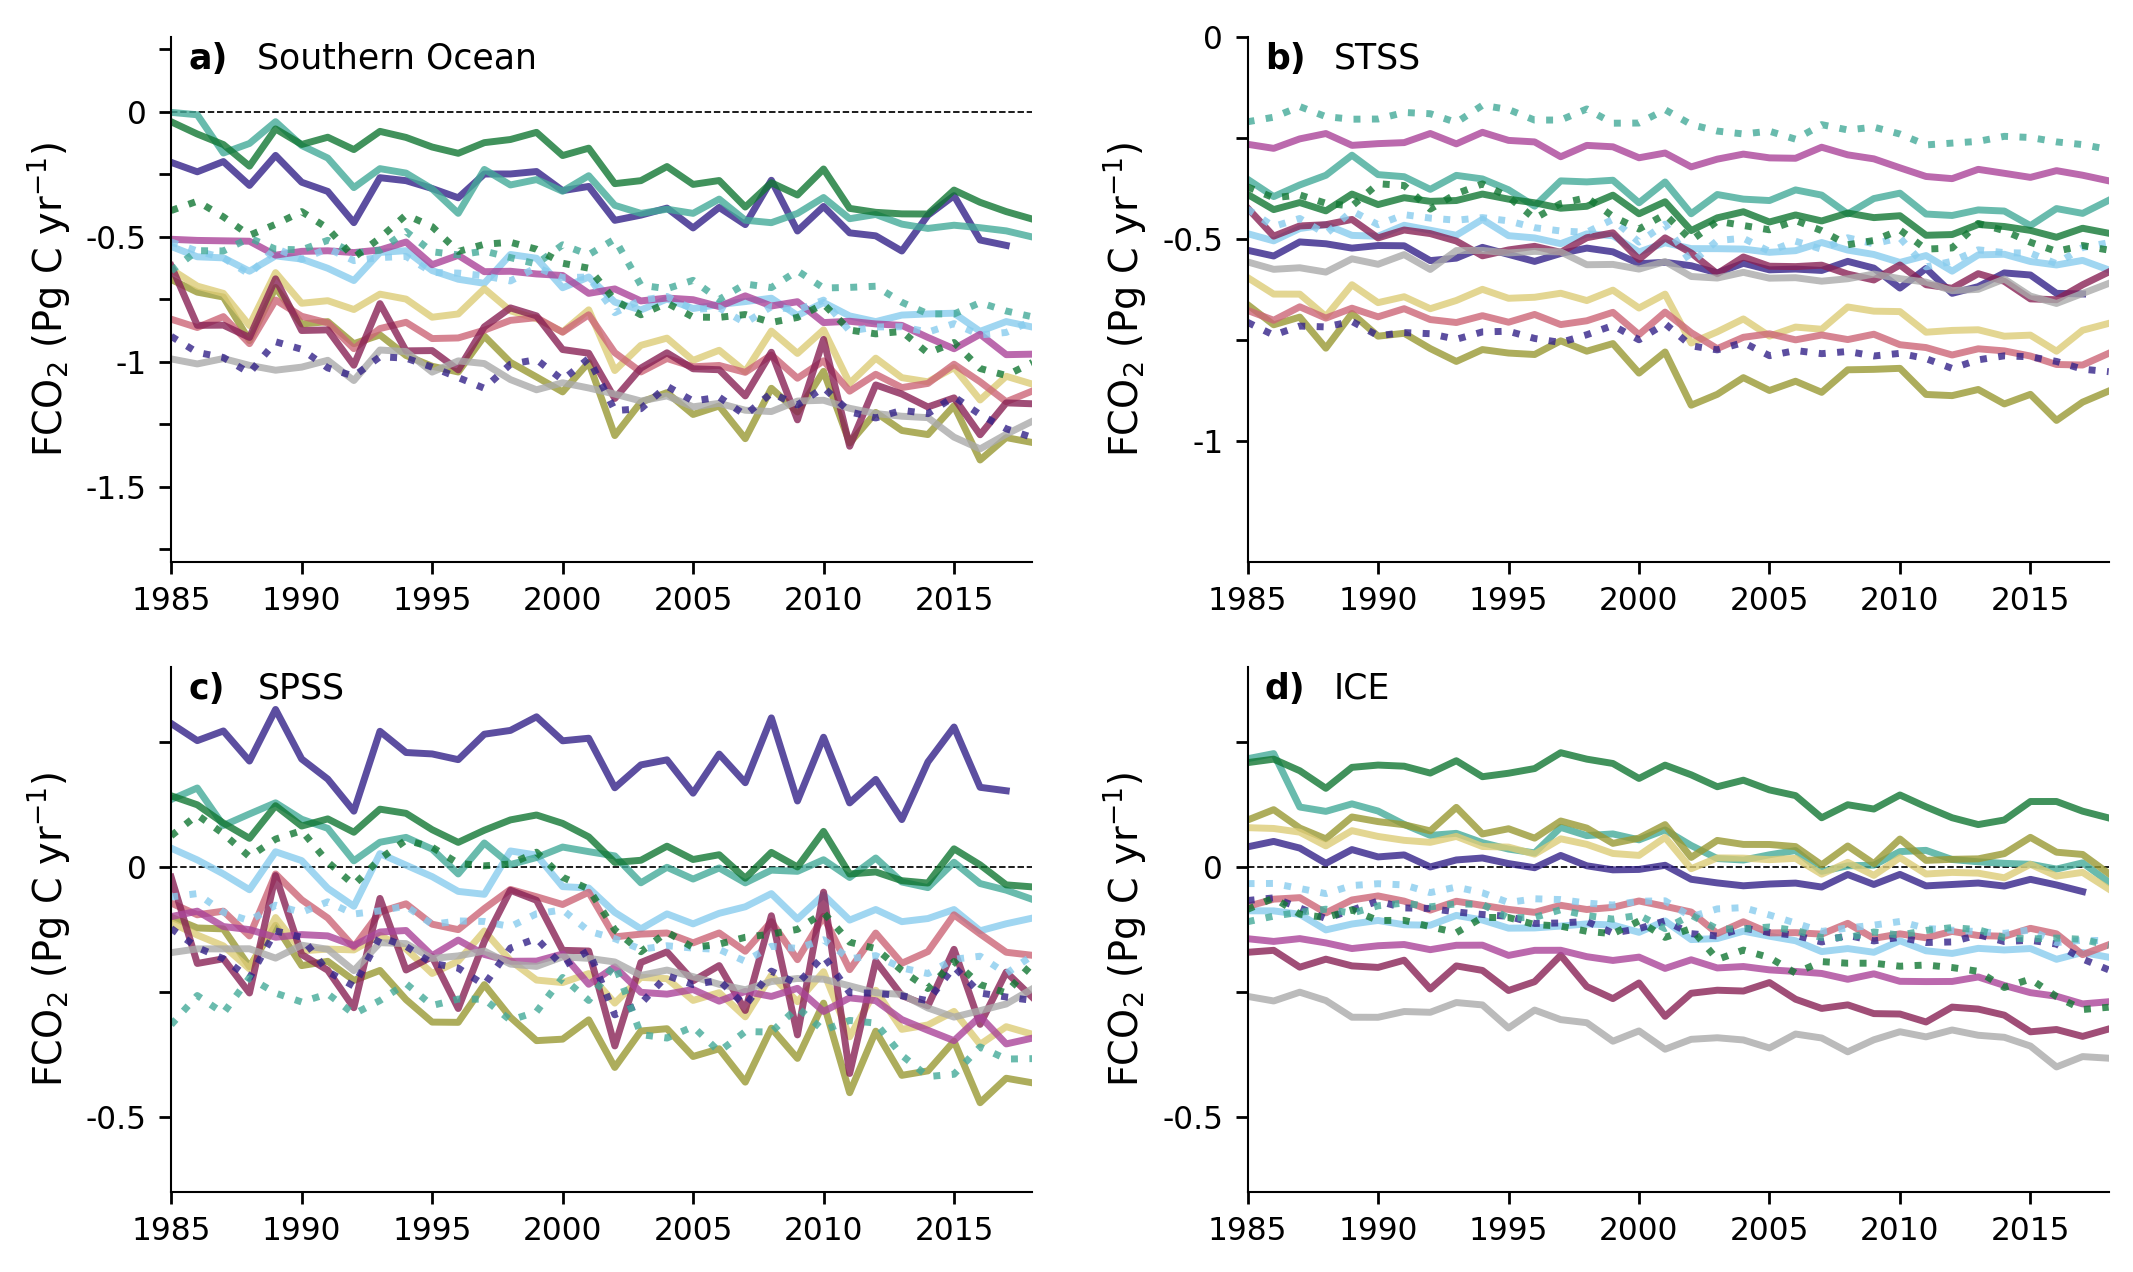

In [29]:
#-----
# individual models (WITH drift correction)
#-----

dpicnt = 250

matplotlib.rcParams['axes.linewidth'] = 0.6 #set the value globally
plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})
    
panel_labels = ['a)','b)','c)','d)']

unit    = 'FCO$_{2}$ (Pg C yr$^{-1}$)'
factor2 = -1*365.25*86400.*12.011/1e15 # conversion factor from mol C m-2 s-1 to PgC yr-1


fig, axs = plt.subplots(2,2,figsize=(10,6), dpi=dpicnt,\
                            gridspec_kw={'width_ratios': [1,1],\
                                         'height_ratios': [1,1]})
plt.subplots_adjust(wspace=0.25)
plt.subplots_adjust(hspace=0.2)

ax1 = plt.subplot2grid((2,2), (0,0))#, colspan=6) # all
ax2 = plt.subplot2grid((2,2), (0,1))#, colspan=6) # STSS
ax3 = plt.subplot2grid((2,2), (1,0))#, colspan=6) # SPSS
ax4 = plt.subplot2grid((2,2), (1,1))#, colspan=6) # ICE


# transpose arrays for function:
# expected input: data: models x regions x time, data_mean: regions x time; swap dimensions in arrays
flux_models_subareas_plot     = np.transpose(flux_models_subareas,[1,2,0])
flux_data_products_plot       = np.transpose(flux_data_products_subareas,[1,2,0])
flux_data_assim_subareas_plot = np.transpose(flux_data_assim_subareas,[1,2,0])
flux_data_ocim_subareas_plot  = np.transpose(flux_ocim_subareas,[1,2,0])
flux_atminv_subareas_plot  = np.transpose(flux_atminv_subareas,[1,2,0])
multi_model_mean_plot      = np.transpose(multi_model_mean,[1,0])
multi_data_prod_mean_plot  = np.transpose(multi_data_prod_mean,[1,0])
multi_data_assim_mean_plot = np.transpose(multi_data_assim_mean,[1,0])
multi_data_watson_mean_plot = np.transpose(multi_data_watson_mean,[1,0])
multi_soccom_mean_plot = np.transpose(multi_soccom_mean,[1,0])
multi_soccom_mean_plot[:,0:-4] = np.nan # only show years 2015-2018 for SOCCOM products

atminv_ocim_on = False
if atminv_ocim_on:
    leg_pos = (0.81, 0.15)
    leg_col = 2
    prop={'size': 5}
else:
    leg_pos = (0.72, 0.135) #(1.01, 0.73)
    #leg_pos = (0.96, 0.82)
    leg_col = 2
    prop={'size': 6}
    
#-----
# all
#-----
ax=ax1
rr = subregions.index("all") # region index
print (subregions[rr])
counter = 0 # if set to 1, print legend
panel_number = 1
panel_label = panel_labels[panel_number-1]
ylim1,ylim2=-1.8,0.3
yticks = [-1.75,-1.5,-1.25,-1,-0.75,-0.5,-0.25,0,0.25]
yticklabels =['',-1.5,'',-1,'',-0.5,'',0,'']
yticks_on=True
subroutine_plotting_time_series_1region_colors_w_simB(ax,area_mean_watson[rr],area_mean_soccom[rr],\
                                                multi_data_watson_mean_plot[rr,:],\
                                                multi_soccom_mean_plot[rr,:],\
                                                biome_area_models[:,rr],\
                                        np.transpose(biome_area_data_products_varying[:,:,rr]),\
                                                biome_area_data_assim[:,rr],biome_area_ocim[:,rr],\
                                                biome_area_atminv[:,rr],\
                                                flux_models_subareas_plot[:,rr,:],\
                                                flux_data_products_plot[:,rr,:],\
                                                flux_data_assim_subareas_plot[:,rr,:],\
                                                flux_data_ocim_subareas_plot[:,rr,:],\
                                                flux_atminv_subareas_plot[:,rr,:],\
                                        add_to_models[rr],biome_area_river[rr],\
                                                models,data_prod,data_assim,data_ocim,data_atminv,\
                                               eval_time,factor2,unit,\
                                       'Southern Ocean',panel_label,counter,atminv_ocim_on,\
                                        yticks_on,ylim1,ylim2,yticks,yticklabels,leg_pos,leg_col,prop,\
                                                     slope_models[:,rr])

#-----
# STSS
#-----
ax=ax2
#ax.set_axis_off()
rr = subregions.index("STSS") # region index
print (subregions[rr])
counter = 1 # if set to 1, print legend
panel_number = 2
panel_label = panel_labels[panel_number-1]
ylim1,ylim2=-1.3,-0.0
yticks = [-1,-0.75,-0.5,-0.25,0]
yticklabels =[-1,'',-0.5,'',0]
yticks_on=True
subroutine_plotting_time_series_1region_colors_w_simB(ax,area_mean_watson[rr],area_mean_soccom[rr],\
                                                multi_data_watson_mean_plot[rr,:],\
                                                multi_soccom_mean_plot[rr,:],\
                                                biome_area_models[:,rr],\
                                        np.transpose(biome_area_data_products_varying[:,:,rr]),\
                                                biome_area_data_assim[:,rr],biome_area_ocim[:,rr],\
                                                biome_area_atminv[:,rr],\
                                                flux_models_subareas_plot[:,rr,:],\
                                                flux_data_products_plot[:,rr,:],\
                                                flux_data_assim_subareas_plot[:,rr,:],\
                                                flux_data_ocim_subareas_plot[:,rr,:],\
                                                flux_atminv_subareas_plot[:,rr,:],\
                                        add_to_models[rr],biome_area_river[rr],\
                                                models,data_prod,data_assim,data_ocim,data_atminv,\
                                               eval_time,factor2,unit,\
                                       subregions[rr],panel_label,counter,atminv_ocim_on,\
                                        yticks_on,ylim1,ylim2,yticks,yticklabels,leg_pos,leg_col,prop,\
                                                     slope_models[:,rr])

# same yticks etc for the three subregions: 
if atminv_ocim_on:
    ylim1,ylim2=-1.0,0.4
    yticks = [-1.0,-0.75,-0.5,-0.25,0,0.25]
    yticklabels =[-1,'',-0.5,'',0,'']
else:
    #ylim1,ylim2=-0.75,0.5
    #yticks = [0.75,-0.5,-0.25,0,0.25,0.5]
    #yticklabels =['',-0.5,'',0,'',0.5]
    ylim1,ylim2=-0.65,0.4
    yticks = [-0.5,-0.25,0,0.25]
    yticklabels =[-0.5,'',0,'']
    
#-----
# SPSS
#-----
ax=ax3
#ax.set_axis_off()
rr = subregions.index("SPSS") # region index
print (subregions[rr])
counter = 0 # if set to 1, print legend
panel_number = 3
panel_label = panel_labels[panel_number-1]
yticks_on=True
subroutine_plotting_time_series_1region_colors_w_simB(ax,area_mean_watson[rr],area_mean_soccom[rr],\
                                                multi_data_watson_mean_plot[rr,:],\
                                                multi_soccom_mean_plot[rr,:],\
                                                biome_area_models[:,rr],\
                                        np.transpose(biome_area_data_products_varying[:,:,rr]),\
                                                biome_area_data_assim[:,rr],biome_area_ocim[:,rr],\
                                                biome_area_atminv[:,rr],\
                                                flux_models_subareas_plot[:,rr,:],\
                                                flux_data_products_plot[:,rr,:],\
                                                flux_data_assim_subareas_plot[:,rr,:],\
                                                flux_data_ocim_subareas_plot[:,rr,:],\
                                                flux_atminv_subareas_plot[:,rr,:],\
                                        add_to_models[rr],biome_area_river[rr],\
                                                models,data_prod,data_assim,data_ocim,data_atminv,\
                                               eval_time,factor2,unit,\
                                       subregions[rr],panel_label,counter,atminv_ocim_on,\
                                        yticks_on,ylim1,ylim2,yticks,yticklabels,leg_pos,leg_col,prop,\
                                                     slope_models[:,rr])
#-----
# ICE
#-----
ax=ax4
#ax.set_axis_off()
rr = subregions.index("ICE") # region index
print (subregions[rr])
counter = 0 # if set to 1, print legend
panel_number = 4
panel_label = panel_labels[panel_number-1]
yticks_on=True
subroutine_plotting_time_series_1region_colors_w_simB(ax,area_mean_watson[rr],area_mean_soccom[rr],\
                                                multi_data_watson_mean_plot[rr,:],\
                                                multi_soccom_mean_plot[rr,:],\
                                                biome_area_models[:,rr],\
                                        np.transpose(biome_area_data_products_varying[:,:,rr]),\
                                                biome_area_data_assim[:,rr],biome_area_ocim[:,rr],\
                                                biome_area_atminv[:,rr],\
                                                flux_models_subareas_plot[:,rr,:],\
                                                flux_data_products_plot[:,rr,:],\
                                                flux_data_assim_subareas_plot[:,rr,:],\
                                                flux_data_ocim_subareas_plot[:,rr,:],\
                                                flux_atminv_subareas_plot[:,rr,:],\
                                        add_to_models[rr],biome_area_river[rr],\
                                                models,data_prod,data_assim,data_ocim,data_atminv,\
                                               eval_time,factor2,unit,\
                                       subregions[rr],panel_label,counter,atminv_ocim_on,\
                                        yticks_on,ylim1,ylim2,yticks,yticklabels,leg_pos,leg_col,prop,\
                                                     slope_models[:,rr])    
    
if river_adjustment:
    river_name = '_wRiver_Adjustment'
else:
    river_name = ''
    
filename1 = 'fig8_time_series_CO2_flux_avg_'+str(year1)+'_'+str(year2)+\
    '_all_models_'+river_name+'_drift_corrected.png'
print (filename1)
    
plt.savefig(save_to_dir+filename1,dpi = dpicnt, bbox_inches='tight')
plt.show()






all
fig8_time_series_CO2_flux_avg_1985_2018_all_models__wRiver_Adjustment_drift_corrected_LEGEND.png


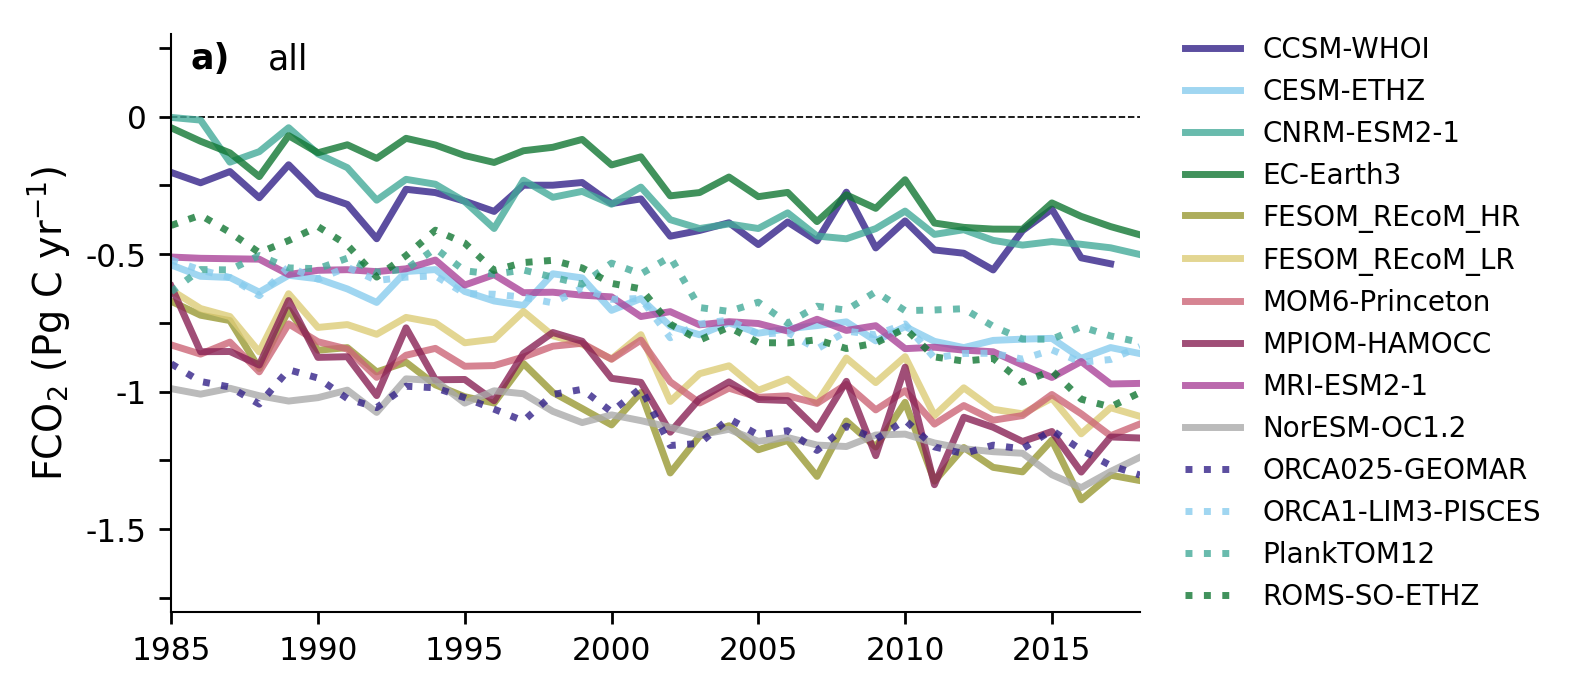

In [30]:
#-----
# individual models (WITH drift correction) -> LEGEND
#-----

                
lw_mean          = 2.5
lw_all           = 1
alpha_value      = 0.3
alpha_std=0.3
fs_text = 9

line_type_list = ('-','-','-','-','-','-','-','-','-','-',':',':',':',':',':',':',':')
    
color_list = [(51./255.,34./255.,136./255.),(136./255.,204./255.,238./255.),\
                  (68./255.,170./255.,153./255.),(17./255.,119./255.,51./255.),\
                  (153./255.,153./255.,51./255.),(221./255.,204./255.,119./255.),\
                   (204./255.,102./255.,119./255.),(136./255.,34./255.,85./255.),\
                   (170./255.,68./255.,153./255.),(170./255.,170./255.,170./255.),\
                  
                  (51./255.,34./255.,136./255.),(136./255.,204./255.,238./255.),\
                  (68./255.,170./255.,153./255.),(17./255.,119./255.,51./255.),\
                  (153./255.,153./255.,51./255.),(221./255.,204./255.,119./255.),\
                   (204./255.,102./255.,119./255.),(136./255.,34./255.,85./255.),\
                   (170./255.,68./255.,153./255.),(170./255.,170./255.,170./255.)]
factor_river = 365.25*86400.*12.011/1e15 # for river fluxes, no need to multiply by "-1" -> pos=outgassing already!

    
    
dpicnt = 250

matplotlib.rcParams['axes.linewidth'] = 0.6 #set the value globally
plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})
    
panel_labels = ['a)','b)','c)','d)']

unit    = 'FCO$_{2}$ (Pg C yr$^{-1}$)'
factor2 = -1*365.25*86400.*12.011/1e15 # conversion factor from mol C m-2 s-1 to PgC yr-1



fig, axs = plt.subplots(1,1,figsize=(5,3), dpi=dpicnt,\
                            gridspec_kw={'width_ratios': [1],\
                                         'height_ratios': [1]})
plt.subplots_adjust(wspace=0.25)
plt.subplots_adjust(hspace=0.2)

ax = plt.subplot2grid((1,1), (0,0))

# transpose arrays for function:
# expected input: data: models x regions x time, data_mean: regions x time; swap dimensions in arrays
flux_models_subareas_plot     = np.transpose(flux_models_subareas,[1,2,0])
flux_data_products_plot       = np.transpose(flux_data_products_subareas,[1,2,0])
flux_data_assim_subareas_plot = np.transpose(flux_data_assim_subareas,[1,2,0])
flux_data_ocim_subareas_plot  = np.transpose(flux_ocim_subareas,[1,2,0])
flux_atminv_subareas_plot  = np.transpose(flux_atminv_subareas,[1,2,0])
multi_model_mean_plot      = np.transpose(multi_model_mean,[1,0])
multi_data_prod_mean_plot  = np.transpose(multi_data_prod_mean,[1,0])
multi_data_assim_mean_plot = np.transpose(multi_data_assim_mean,[1,0])
multi_data_watson_mean_plot = np.transpose(multi_data_watson_mean,[1,0])
multi_soccom_mean_plot = np.transpose(multi_soccom_mean,[1,0])
multi_soccom_mean_plot[:,0:-4] = np.nan # only show years 2015-2018 for SOCCOM products

atminv_ocim_on = False
if atminv_ocim_on:
    leg_pos = (0.81, 0.15)
    leg_col = 2
    prop={'size': 5}
else:
    leg_pos = (0.72, 0.135) #(1.01, 0.73)
    #leg_pos = (0.96, 0.82)
    leg_col = 2
    prop={'size': 6}
    
#-----
# all
#-----
rr = subregions.index("all") # region index
print (subregions[rr])
counter = 0 # if set to 1, print legend
panel_number = 1
panel_label = panel_labels[panel_number-1]
ylim1,ylim2=-1.8,0.3
yticks = [-1.75,-1.5,-1.25,-1,-0.75,-0.5,-0.25,0,0.25]
yticklabels =['',-1.5,'',-1,'',-0.5,'',0,'']
yticks_on=True

add_rivers = factor_river*biome_area_river[rr]*add_to_models[rr]
add_each_year = add_rivers*np.ones(len(eval_time))
    
models2     = ('CCSM-WHOI','CESM-ETHZ','CNRM-ESM2-1','EC-Earth3','FESOM_REcoM_HR','FESOM_REcoM_LR',\
             'MOM6-Princeton','MPIOM-HAMOCC','MRI-ESM2-1','NorESM-OC1.2',\
             'ORCA025-GEOMAR','ORCA1-LIM3-PISCES','PlankTOM12','ROMS-SO-ETHZ')

# create array of area: models x time (area constant in time)
for dd in range(0,len(models)):
    ax.plot(range(0,len(eval_time)),\
            biome_area_models[dd,rr]*factor2*flux_models_subareas_plot[dd,rr,:]+add_each_year-slope_models[dd,rr],\
                    color=color_list[dd], linewidth=2.0,linestyle=line_type_list[dd], alpha=0.8,label=models2[dd]) 
    
#legend_handles = ax.get_legend_handles_labels()
#ax2.legend(legend_handles, models, 'center')
    
ax.set_xlim((0.0,len(eval_time)-1))
ax.set_ylim((ylim1,ylim2))
    
if counter==0: # don't plot for STSS
    ax.hlines(0,0,len(eval_time),color='k', linestyle='--', linewidth=0.5, zorder=0)

if yticks_on: 
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_ylabel(unit,fontsize=fs_text+2)
else: 
    ax.set_yticks([])
    ax.set_yticklabels([])
        
ax.set_xticks(np.arange(0,len(eval_time),5))
ax.set_xticklabels(eval_time[0::5])

for label in ax.yaxis.get_majorticklabels():
        label.set_size(fs_text)
for label in ax.xaxis.get_majorticklabels():
        label.set_size(fs_text)

leg_pos = (1.44, 0.5) #(1.01, 0.73)
leg_col = 1
prop={'size': 8}
ax.legend(loc='right',bbox_to_anchor=leg_pos, \
                      ncol=leg_col,fancybox=False,frameon=False,shadow=False,prop=prop) 

ax.annotate(panel_label,xy=(0.02,0.94), xycoords='axes fraction',
                         fontsize=fs_text+1,fontweight='bold')
ax.annotate(subregions[rr],xy=(0.1,0.94), xycoords='axes fraction',fontsize=fs_text+1)
 
    
if river_adjustment:
    river_name = '_wRiver_Adjustment'
else:
    river_name = ''
    
filename1 = 'fig8_time_series_CO2_flux_avg_'+str(year1)+'_'+str(year2)+\
    '_all_models_'+river_name+'_drift_corrected_LEGEND.png'
print (filename1)
    
plt.savefig(save_to_dir+filename1,dpi = dpicnt, bbox_inches='tight')
plt.show()

#fig.show()
#figlegend.show()
#figlegend.savefig(save_to_dir+'legend.png')




all
STSS
SPSS
ICE
fig8_time_series_CO2_flux_avg_1985_2018_all_models__wRiver_Adjustment.png


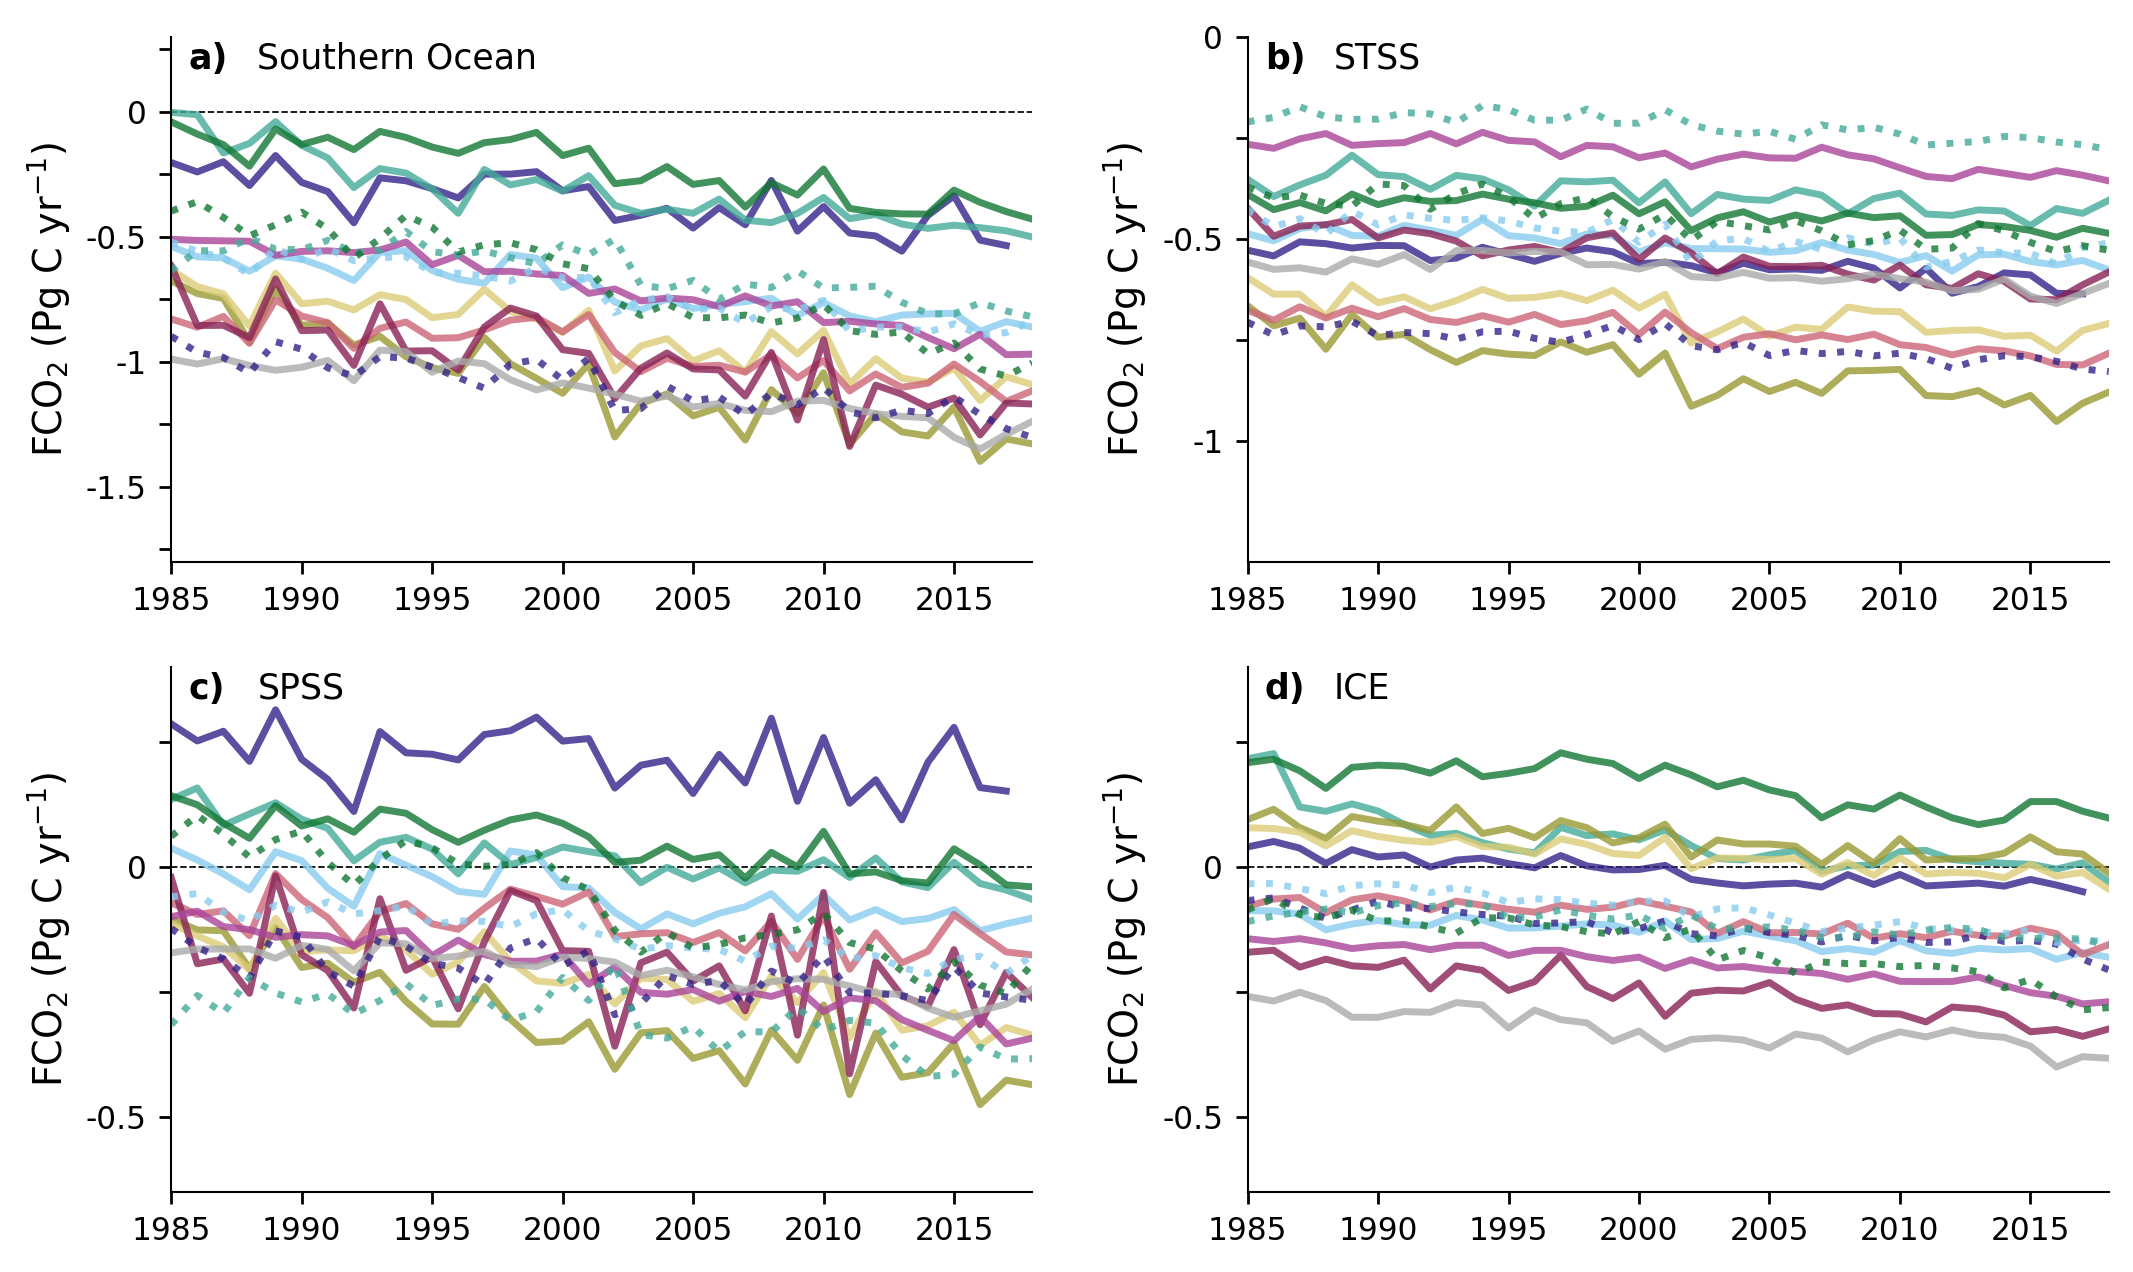

In [31]:
#-----
# individual models (w/o drift correction)
#-----

dpicnt = 250

matplotlib.rcParams['axes.linewidth'] = 0.6 #set the value globally
plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})
    
panel_labels = ['a)','b)','c)','d)']

unit    = 'FCO$_{2}$ (Pg C yr$^{-1}$)'
factor2 = -1*365.25*86400.*12.011/1e15 # conversion factor from mol C m-2 s-1 to PgC yr-1


fig, axs = plt.subplots(2,2,figsize=(10,6), dpi=dpicnt,\
                            gridspec_kw={'width_ratios': [1,1],\
                                         'height_ratios': [1,1]})
plt.subplots_adjust(wspace=0.25)
plt.subplots_adjust(hspace=0.2)

ax1 = plt.subplot2grid((2,2), (0,0))#, colspan=6) # all
ax2 = plt.subplot2grid((2,2), (0,1))#, colspan=6) # STSS
ax3 = plt.subplot2grid((2,2), (1,0))#, colspan=6) # SPSS
ax4 = plt.subplot2grid((2,2), (1,1))#, colspan=6) # ICE


# transpose arrays for function:
# expected input: data: models x regions x time, data_mean: regions x time; swap dimensions in arrays
flux_models_subareas_plot     = np.transpose(flux_models_subareas,[1,2,0])
flux_data_products_plot       = np.transpose(flux_data_products_subareas,[1,2,0])
flux_data_assim_subareas_plot = np.transpose(flux_data_assim_subareas,[1,2,0])
flux_data_ocim_subareas_plot  = np.transpose(flux_ocim_subareas,[1,2,0])
flux_atminv_subareas_plot  = np.transpose(flux_atminv_subareas,[1,2,0])
multi_model_mean_plot      = np.transpose(multi_model_mean,[1,0])
multi_data_prod_mean_plot  = np.transpose(multi_data_prod_mean,[1,0])
multi_data_assim_mean_plot = np.transpose(multi_data_assim_mean,[1,0])
multi_data_watson_mean_plot = np.transpose(multi_data_watson_mean,[1,0])
multi_soccom_mean_plot = np.transpose(multi_soccom_mean,[1,0])
multi_soccom_mean_plot[:,0:-4] = np.nan # only show years 2015-2018 for SOCCOM products

atminv_ocim_on = False
if atminv_ocim_on:
    leg_pos = (0.81, 0.15)
    leg_col = 2
    prop={'size': 5}
else:
    leg_pos = (0.72, 0.135) #(1.01, 0.73)
    #leg_pos = (0.96, 0.82)
    leg_col = 2
    prop={'size': 6}
    
#-----
# all
#-----
ax=ax1
rr = subregions.index("all") # region index
print (subregions[rr])
counter = 0 # if set to 1, print legend
panel_number = 1
panel_label = panel_labels[panel_number-1]
ylim1,ylim2=-1.8,0.3
yticks = [-1.75,-1.5,-1.25,-1,-0.75,-0.5,-0.25,0,0.25]
yticklabels =['',-1.5,'',-1,'',-0.5,'',0,'']
yticks_on=True
subroutine_plotting_time_series_1region_colors(ax,area_mean_watson[rr],area_mean_soccom[rr],\
                                                multi_data_watson_mean_plot[rr,:],\
                                                multi_soccom_mean_plot[rr,:],\
                                                biome_area_models[:,rr],\
                                        np.transpose(biome_area_data_products_varying[:,:,rr]),\
                                                biome_area_data_assim[:,rr],biome_area_ocim[:,rr],\
                                                biome_area_atminv[:,rr],\
                                                flux_models_subareas_plot[:,rr,:],\
                                                flux_data_products_plot[:,rr,:],\
                                                flux_data_assim_subareas_plot[:,rr,:],\
                                                flux_data_ocim_subareas_plot[:,rr,:],\
                                                flux_atminv_subareas_plot[:,rr,:],\
                                        add_to_models[rr],biome_area_river[rr],\
                                                models,data_prod,data_assim,data_ocim,data_atminv,\
                                               eval_time,factor2,unit,\
                                       'Southern Ocean',panel_label,counter,atminv_ocim_on,\
                                        yticks_on,ylim1,ylim2,yticks,yticklabels,leg_pos,leg_col,prop)

#-----
# STSS
#-----
ax=ax2
#ax.set_axis_off()
rr = subregions.index("STSS") # region index
print (subregions[rr])
counter = 1 # if set to 1, print legend
panel_number = 2
panel_label = panel_labels[panel_number-1]
ylim1,ylim2=-1.3,-0.0
yticks = [-1,-0.75,-0.5,-0.25,0]
yticklabels =[-1,'',-0.5,'',0]
yticks_on=True
subroutine_plotting_time_series_1region_colors(ax,area_mean_watson[rr],area_mean_soccom[rr],\
                                                multi_data_watson_mean_plot[rr,:],\
                                                multi_soccom_mean_plot[rr,:],\
                                                biome_area_models[:,rr],\
                                        np.transpose(biome_area_data_products_varying[:,:,rr]),\
                                                biome_area_data_assim[:,rr],biome_area_ocim[:,rr],\
                                                biome_area_atminv[:,rr],\
                                                flux_models_subareas_plot[:,rr,:],\
                                                flux_data_products_plot[:,rr,:],\
                                                flux_data_assim_subareas_plot[:,rr,:],\
                                                flux_data_ocim_subareas_plot[:,rr,:],\
                                                flux_atminv_subareas_plot[:,rr,:],\
                                        add_to_models[rr],biome_area_river[rr],\
                                                models,data_prod,data_assim,data_ocim,data_atminv,\
                                               eval_time,factor2,unit,\
                                       subregions[rr],panel_label,counter,atminv_ocim_on,\
                                        yticks_on,ylim1,ylim2,yticks,yticklabels,leg_pos,leg_col,prop)

# same yticks etc for the three subregions: 
if atminv_ocim_on:
    ylim1,ylim2=-1.0,0.4
    yticks = [-1.0,-0.75,-0.5,-0.25,0,0.25]
    yticklabels =[-1,'',-0.5,'',0,'']
else:
    #ylim1,ylim2=-0.75,0.5
    #yticks = [0.75,-0.5,-0.25,0,0.25,0.5]
    #yticklabels =['',-0.5,'',0,'',0.5]
    ylim1,ylim2=-0.65,0.4
    yticks = [-0.5,-0.25,0,0.25]
    yticklabels =[-0.5,'',0,'']
    
#-----
# SPSS
#-----
ax=ax3
#ax.set_axis_off()
rr = subregions.index("SPSS") # region index
print (subregions[rr])
counter = 0 # if set to 1, print legend
panel_number = 3
panel_label = panel_labels[panel_number-1]
yticks_on=True
subroutine_plotting_time_series_1region_colors(ax,area_mean_watson[rr],area_mean_soccom[rr],\
                                                multi_data_watson_mean_plot[rr,:],\
                                                multi_soccom_mean_plot[rr,:],\
                                                biome_area_models[:,rr],\
                                        np.transpose(biome_area_data_products_varying[:,:,rr]),\
                                                biome_area_data_assim[:,rr],biome_area_ocim[:,rr],\
                                                biome_area_atminv[:,rr],\
                                                flux_models_subareas_plot[:,rr,:],\
                                                flux_data_products_plot[:,rr,:],\
                                                flux_data_assim_subareas_plot[:,rr,:],\
                                                flux_data_ocim_subareas_plot[:,rr,:],\
                                                flux_atminv_subareas_plot[:,rr,:],\
                                        add_to_models[rr],biome_area_river[rr],\
                                                models,data_prod,data_assim,data_ocim,data_atminv,\
                                               eval_time,factor2,unit,\
                                       subregions[rr],panel_label,counter,atminv_ocim_on,\
                                        yticks_on,ylim1,ylim2,yticks,yticklabels,leg_pos,leg_col,prop)
#-----
# ICE
#-----
ax=ax4
#ax.set_axis_off()
rr = subregions.index("ICE") # region index
print (subregions[rr])
counter = 0 # if set to 1, print legend
panel_number = 4
panel_label = panel_labels[panel_number-1]
yticks_on=True
subroutine_plotting_time_series_1region_colors(ax,area_mean_watson[rr],area_mean_soccom[rr],\
                                                multi_data_watson_mean_plot[rr,:],\
                                                multi_soccom_mean_plot[rr,:],\
                                                biome_area_models[:,rr],\
                                        np.transpose(biome_area_data_products_varying[:,:,rr]),\
                                                biome_area_data_assim[:,rr],biome_area_ocim[:,rr],\
                                                biome_area_atminv[:,rr],\
                                                flux_models_subareas_plot[:,rr,:],\
                                                flux_data_products_plot[:,rr,:],\
                                                flux_data_assim_subareas_plot[:,rr,:],\
                                                flux_data_ocim_subareas_plot[:,rr,:],\
                                                flux_atminv_subareas_plot[:,rr,:],\
                                        add_to_models[rr],biome_area_river[rr],\
                                                models,data_prod,data_assim,data_ocim,data_atminv,\
                                               eval_time,factor2,unit,\
                                       subregions[rr],panel_label,counter,atminv_ocim_on,\
                                        yticks_on,ylim1,ylim2,yticks,yticklabels,leg_pos,leg_col,prop)    
    
if river_adjustment:
    river_name = '_wRiver_Adjustment'
else:
    river_name = ''
    
filename1 = 'fig8_time_series_CO2_flux_avg_'+str(year1)+'_'+str(year2)+\
    '_all_models_'+river_name+'.png'
print (filename1)
    
plt.savefig(save_to_dir+filename1,dpi = dpicnt, bbox_inches='tight')
plt.show()





In [32]:
#---
# get numbers on interannual variability
#---

def subroutine_get_IAV_of_detrended_time_series(area_mean_watson,\
                                            area_mean_soccom,multi_data_watson_mean,multi_soccom_mean,\
                                                biome_area_models,biome_area_data_products,\
                                                biome_area_data_assim,biome_area_ocim,\
                                                biome_area_atminv,\
                                                models_all,data_all,\
                                                            data_assim_all,data_ocim_all,data_atminv_all,\
                                            add_to_models,biome_area_river,\
                                                            models,data_prod,data_assim,data_ocim,data_atminv,\
                                               eval_time,factor,\
                                       subregions,atminv_ocim_on,slope):
    
    factor_river = 365.25*86400.*12.011/1e15 # for river fluxes, no need to multiply by "-1" -> pos=outgassing already!

    IAV_models = np.zeros(len(models))
    IAV_data = np.zeros(len(data_prod))
    IAV_data_assim = np.zeros(len(data_assim))
    IAV_Watson = np.zeros(1)
    IAV_atminv = np.zeros(len(data_atminv))
    
    #-----
    # MODELS
    #-----
    add_rivers = factor_river*biome_area_river*add_to_models
    add_each_year = add_rivers*np.ones(len(eval_time))
    
    # create array of area: models x time (area constant in time)
    area_2d = np.transpose(np.tile(biome_area_models[:],[len(eval_time),1])) # should be models x time
    
    #a2a = model_data_mean+model_data_std
    #a2b = model_data_mean-model_data_std
    for dd in range(0,models_all.shape[0]):
        a1 = biome_area_models[dd]*factor*models_all[dd,:]+add_each_year-slope[dd]
        ind_no_NaN = np.where(~np.isnan(a1))[0] # detrending function cannot handle NaNs
        a1 = a1[ind_no_NaN]
        detrended = signal.detrend(a1)
        #print 'IAV for '+models[dd]+': '+str(np.nanstd(detrended))
        IAV_models[dd]=np.nanstd(detrended)
        del detrended,ind_no_NaN,a1
        
    #-----
    # DATA ASSIM
    #-----
    # B-SOSE
    a1 = biome_area_data_assim[0]*factor*data_assim_all[0,:]
    ind_no_NaN = np.where(~np.isnan(a1))[0] # detrending function cannot handle NaNs
    a1 = a1[ind_no_NaN]
    detrended = signal.detrend(a1)
   # print 'IAV for '+data_assim[0]+': '+str(np.nanstd(detrended))
    IAV_data_assim[0]=np.nanstd(detrended)
    del detrended,ind_no_NaN,a1
    # ECCO
    a1 = biome_area_data_assim[1]*factor*data_assim_all[1,:]
    ind_no_NaN = np.where(~np.isnan(a1))[0] # detrending function cannot handle NaNs
    a1 = a1[ind_no_NaN]
    detrended = signal.detrend(a1)
    #print 'IAV for '+data_assim[1]+': '+str(np.nanstd(detrended))
    IAV_data_assim[1]=np.nanstd(detrended)
    del detrended,ind_no_NaN,a1
        
    #-----
    # DATA -> area not constant in time, passed as an input argument 
    #-----
    for dd in range(0,data_all.shape[0]):
        a1 = biome_area_data_products[dd,:]*factor*data_all[dd,:]
        ind_no_NaN = np.where(~np.isnan(a1))[0] # detrending function cannot handle NaNs
        a1 = a1[ind_no_NaN]
        detrended = signal.detrend(a1)
       # print 'IAV for '+data_prod[dd]+': '+str(np.nanstd(detrended))
        IAV_data[dd]=np.nanstd(detrended)
        del detrended,ind_no_NaN,a1
        
    #-----
    # SOCCOM
    #-----
   # ax.plot(range(0,len(eval_time)),area_mean_soccom*factor*multi_soccom_mean,\
   #                  color_soccom,label='Data-products+SOCCOM',linewidth=lw_mean-0.75,zorder=21)
        
    #-----
    # DATA: Watson2020
    #-----
    a1 = area_mean_watson*factor*multi_data_watson_mean[:]
    ind_no_NaN = np.where(~np.isnan(a1))[0] # detrending function cannot handle NaNs
    a1 = a1[ind_no_NaN]
    detrended = signal.detrend(a1)
   # print 'IAV for Watson2020: '+str(np.nanstd(detrended))
    IAV_Watson[0]=np.nanstd(detrended)
    del detrended,ind_no_NaN,a1
    
    #-----
    # atm inv
    #-----
    for dd in range(0,len(data_atminv)):
        a1 = biome_area_atminv[dd]*(-1)*data_atminv_all[dd]
        ind_no_NaN = np.where(~np.isnan(a1))[0] # detrending function cannot handle NaNs
        a1 = a1[ind_no_NaN]
        detrended = signal.detrend(a1)
       # print 'IAV for '+data_atminv[0]+': '+str(np.nanstd(detrended))
        IAV_atminv[dd]=np.nanstd(detrended)
    del detrended,ind_no_NaN,a1
    
    return IAV_models,IAV_data_assim,IAV_data,IAV_Watson,IAV_atminv
        


In [33]:
#---
# print some numbers: IAV
#---

factor2 = -1*365.25*86400.*12.011/1e15 # conversion factor from mol C m-2 s-1 to PgC yr-1

# transpose arrays for function:
# expected input: data: models x regions x time, data_mean: regions x time; swap dimensions in arrays
flux_models_subareas_plot     = np.transpose(flux_models_subareas,[1,2,0])
flux_data_products_plot       = np.transpose(flux_data_products_subareas,[1,2,0])
flux_data_assim_subareas_plot = np.transpose(flux_data_assim_subareas,[1,2,0])
flux_data_ocim_subareas_plot  = np.transpose(flux_ocim_subareas,[1,2,0])
flux_atminv_subareas_plot  = np.transpose(flux_atminv_subareas,[1,2,0])
multi_data_watson_mean_plot = np.transpose(multi_data_watson_mean,[1,0])
multi_soccom_mean_plot = np.transpose(multi_soccom_mean,[1,0])
multi_soccom_mean_plot[:,0:-4] = np.nan # only show years 2015-2018 for SOCCOM products
    
#-----
# loop over all regions
#-----

IAV_models = np.zeros([len(subregions),len(models)])
IAV_data = np.zeros([len(subregions),len(data_prod)])
IAV_data_assim = np.zeros([len(subregions),len(data_assim)])
IAV_Watson = np.zeros([len(subregions),1])
IAV_atminv = np.zeros([len(subregions),len(data_atminv)])
    
for rr in range(0,len(subregions)):
    print (subregions[rr])
    IAV_models[rr,:],IAV_data_assim[rr,:],IAV_data[rr,:],IAV_Watson[rr,:],IAV_atminv[rr,:] = subroutine_get_IAV_of_detrended_time_series(area_mean_watson[rr],\
                                                                        area_mean_soccom[rr],\
                                                multi_data_watson_mean_plot[rr,:],\
                                                multi_soccom_mean_plot[rr,:],\
                                                biome_area_models[:,rr],\
                                        np.transpose(biome_area_data_products_varying[:,:,rr]),\
                                                biome_area_data_assim[:,rr],biome_area_ocim[:,rr],\
                                                biome_area_atminv[:,rr],\
                                                flux_models_subareas_plot[:,rr,:],\
                                                flux_data_products_plot[:,rr,:],\
                                                flux_data_assim_subareas_plot[:,rr,:],\
                                                flux_data_ocim_subareas_plot[:,rr,:],\
                                                flux_atminv_subareas_plot[:,rr,:],\
                                        add_to_models[rr],biome_area_river[rr],\
                                                models,data_prod,data_assim,data_ocim,data_atminv,\
                                               eval_time,factor2,\
                                       subregions[rr],atminv_ocim_on,slope_models[:,rr])



STSS-Atl
STSS-Ind
STSS-Pac
SPSS-Atl
SPSS-Ind
SPSS-Pac
ICE-Atl
ICE-Ind
ICE-Pac
STSS
SPSS
ICE
all


In [34]:

# apply model trends
models_all2 = np.zeros_like(flux_models_subareas_plot)
# "slope" is already in PgC yr-1 yr-1, 
# make sure that when applying it to fluxes, the latter are already in Pg C yr-1
for rr in range(0,len(subregions)):
    for mm in range(0,len(models)):
        for yy in range(0,len(eval_time)):
            add_rivers = -1*factor2*biome_area_river[rr]*add_to_models[rr]
            
            models_all2[mm,rr,yy] = biome_area_models[mm,rr]*factor2*flux_models_subareas_plot[mm,rr,yy]+\
                            add_rivers-slope_models[mm,rr]

# for calculation of multi-model mean, use the array that is drift-corrected
model_data_mean = np.nanmean(models_all2,axis=0)
model_data_std  = np.nanstd(models_all2,axis=0)
    
print (model_data_mean.shape)
print (model_data_mean[-1,:])


(13, 34)
[-0.53459943 -0.57267884 -0.59090562 -0.65054069 -0.55028321 -0.60865662
 -0.61788288 -0.69265462 -0.60864983 -0.61726901 -0.67390288 -0.69914606
 -0.65203667 -0.65327943 -0.6603257  -0.71173203 -0.68672141 -0.81449081
 -0.81533269 -0.77981615 -0.82725368 -0.81457964 -0.86024733 -0.79260845
 -0.84591366 -0.77594446 -0.90455751 -0.87222763 -0.89786274 -0.90929472
 -0.87390418 -0.94803531 -0.94308149 -0.97398056]


In [37]:
#-------
# print some numbers: IAV
#-------

print_numbers = False

if print_numbers:
    data_atminv2 = ['CAMSv20r2','sEXTocNEETv2021','CTE2021','NISMON-CO2','CMS-Flux','UoE']

    filename_numbers = 'Fig8_numbers_IAV_models_drift_corrected.txt'
    f = open(save_to_dir+filename_numbers, "a")

    print('##########',file=f)
    print('Definition of IAV:',file=f)
    print('std of detrended time series; time series from 1985-2018 unless indicated otherwise',file=f)
    print('all numbers are in PgC yr-1',file=f)
    print('##########',file=f)
    print('CCSM-WHOI from 1985-2017 only',file=f)
    print('B-SOSE from 2013-2018 only',file=f)
    print('ECCO-DARWIN from 1995-2018 only',file=f)
    print('AOML from 1998-2018 only',file=f)
    print('Watson2020 from 1988-2018 only',file=f)
    print('CAMSv20r2 from 1990-2018 only',file=f)
    print('sEXTocNEETv2021 from 1990-2018 only',file=f)
    print('CTE2021 from 2001-2018 only',file=f)
    print('NISMON-CO2 from 1990-2018 only',file=f)
    print('CMS-Flux from 2010-2018 only',file=f)
    print('UoE from 2001-2018 only',file=f)
    print ('-----',file=f)
    print('Multi model mean includes all models',file=f)
    print('Multi data-product includes all except AOML & Watson2020',file=f)
    print('Multi atm. inv from 1990-2018 only and only considering products starting in 1990',file=f)
    print ('-----',file=f)
    for rr in range(len(subregions)-1, -1, -1):
        print('##########',file=f)
        print('Region '+subregions[rr]+':', file=f)
        print('##########', file=f)
        print ('-----',file=f)
        print ('MODELS',file=f)
        print ('-----',file=f)
        for mm in range(0,len(models)):
            print (models[mm],IAV_models[rr,mm], file=f)
        print ('Multi model mean:',np.mean(IAV_models[rr,:]), file=f)
        print ('-----',file=f)
        print ('DATA-ASSIM. MODELS',file=f)
        print ('-----',file=f)
        for mm in range(0,len(data_assim)):
            print (data_assim[mm],IAV_data_assim[rr,mm], file=f)
        print ('-----',file=f)
        print ('DATA-PRODUCTS',file=f)
        print ('-----',file=f)
        for mm in range(0,len(data_prod)):
            print (data_prod[mm],IAV_data[rr,mm], file=f)
        print ('Multi data-product mean:',np.mean(IAV_data[rr,1:]), file=f)
        print (data_watson[0],IAV_Watson[rr,0], file=f)
        print ('-----',file=f)
        print ('ATM. INVERSION',file=f)
        print ('-----',file=f)
        for mm in range(0,len(data_atminv)):
            print (data_atminv2[mm],IAV_atminv[rr,mm], file=f)
        print ('Multi atm. inv. mean:',np.mean(IAV_atminv[rr,[0,1,3]]), file=f) # only include those that start in 1990

    f.close()

    print ('done')


done


In [38]:
#-------
# print some numbers
#-------

if print_numbers:
    factor_river = 365.25*86400.*12.011/1e15 # for river fluxes, no need to multiply by "-1" -> pos=outgassing already!

    data_prod2 = data_prod[1:]# exclude AOML -> for identification of min/max in year 1985
    models2 = models[1:]# exclude CCSM -> for identification of min/max in year 2018
    #print data_prod2

    filename_numbers = 'Fig8_numbers_'+str(year1)+'_'+str(year2)+'_models_drift_corrected.txt'
    f = open(save_to_dir+filename_numbers, "a")
    #print('Note: AOML not considered for identification of min/max in year 1985',file=f)
    for rr in range(len(subregions)-1, -1, -1):
        add_rivers = factor_river*biome_area_river[rr]*add_to_models[rr]
        add_each_year = add_rivers*np.ones(len(eval_time))

        print('##########', file=f)
        print('Region '+subregions[rr]+':', file=f)
        print ('-----',file=f)
        print (str(year1)+':',file=f)
        print ('-----',file=f)
        ind=0
        print ('multi-model mean:',model_data_mean[rr,ind], file=f)
    print ('multi-model std:',model_data_std[rr,ind], file=f)
    print ('Min across models: '+str(np.min(models_all2[:,rr,ind]))+' in '+models[np.argmin(models_all2[:,rr,ind])], file=f)
    print ('Max across models: '+str(np.max(models_all2[:,rr,ind]))+' in '+models[np.argmax(models_all2[:,rr,ind])], file=f)
    #print ('multi-model mean:',area_mean_models[rr]*factor2*multi_model_mean_plot[rr,ind]+add_each_year[ind], file=f)
    #print ('multi-model std:',np.nanstd(area_mean_models[rr]*factor2*flux_models_subareas_plot[:,rr,ind],axis=0), file=f)
    #print ('Min across models: '+str(np.min(factor2*biome_area_models[:,rr]*flux_models_subareas_plot[:,rr,ind])+add_each_year[ind])+\
    #                ' in '+models[np.argmin(factor2*biome_area_models[:,rr]*flux_models_subareas_plot[:,rr,ind])], file=f)
    #print ('Max across models: '+str(np.max(factor2*biome_area_models[:,rr]*flux_models_subareas_plot[:,rr,ind])+add_each_year[ind])+\
    #                ' in '+models[np.argmax(factor2*biome_area_models[:,rr]*flux_models_subareas_plot[:,rr,ind])], file=f)
    print ('multi-data product mean:',area_mean_data_products[rr]*factor2*multi_data_prod_mean_plot[rr,ind], file=f)
    print ('multi-data product std:',np.nanstd(area_mean_data_products[rr]*factor2*flux_data_products_plot[:,rr,ind],axis=0), file=f)
    print ('Min across data products: '+str(np.nanmin(factor2*biome_area_data_products[1:,rr]*flux_data_products_plot[1:,rr,ind]))+\
                    ' in '+data_prod2[np.argmin(factor2*biome_area_data_products[1:,rr]*flux_data_products_plot[1:,rr,ind])], file=f)
    print ('Max across data products: '+str(np.nanmax(factor2*biome_area_data_products[1:,rr]*flux_data_products_plot[1:,rr,ind]))+\
                    ' in '+data_prod2[np.argmax(factor2*biome_area_data_products[1:,rr]*flux_data_products_plot[1:,rr,ind])], file=f)
    print ('BSOSE:',factor2*biome_area_data_assim[0,rr]*flux_data_assim_subareas_plot[0,rr,ind], file=f)
    print ('ECCO-Darwin:',factor2*biome_area_data_assim[1,rr]*flux_data_assim_subareas_plot[1,rr,ind], file=f)
    print ('OCIM-v2014:',factor2*biome_area_ocim[0,rr]*flux_data_ocim_subareas_plot[0,rr,ind], file=f)
    print ('OCIM-v2021:',factor2*biome_area_ocim[1,rr]*flux_data_ocim_subareas_plot[1,rr,ind], file=f)
    print ('Watson2020 mean:',factor2*area_mean_watson[rr]*multi_data_watson_mean_plot[rr,ind], file=f)
    print ('Atm Inv mean:',np.mean(biome_area_atminv[ind_list,rr]*(-1)*flux_atminv_subareas_plot[ind_list,rr,ind]), file=f)
    print ('-----',file=f)
    print (str(year2)+':',file=f)
    print ('-----',file=f)
    ind=-1
    print ('multi-model mean:',model_data_mean[rr,ind], file=f)
    print ('multi-model std:',model_data_std[rr,ind], file=f)
    print ('Min across models: '+str(np.min(models_all2[1:,rr,ind]))+' in '+models2[np.argmin(models_all2[1:,rr,ind])], file=f)
    print ('Max across models: '+str(np.max(models_all2[1:,rr,ind]))+' in '+models2[np.argmax(models_all2[1:,rr,ind])], file=f)
    #print ('multi-model mean:',area_mean_models[rr]*factor2*multi_model_mean_plot[rr,ind]+add_each_year[ind], file=f)
    #print ('multi-model std:',np.nanstd(area_mean_models[rr]*factor2*flux_models_subareas_plot[:,rr,ind],axis=0), file=f)
    #print ('Min across models: '+str(np.min(factor2*biome_area_models[1:,rr]*flux_models_subareas_plot[1:,rr,ind])+add_each_year[ind])+\
    #                ' in '+models2[np.argmin(factor2*biome_area_models[1:,rr]*flux_models_subareas_plot[1:,rr,ind])], file=f)
    #print ('Max across models: '+str(np.max(factor2*biome_area_models[1:,rr]*flux_models_subareas_plot[1:,rr,ind])+add_each_year[ind])+\
    #                ' in '+models2[np.argmax(factor2*biome_area_models[1:,rr]*flux_models_subareas_plot[1:,rr,ind])], file=f)
    print ('multi-data product mean:',area_mean_data_products[rr]*factor2*multi_data_prod_mean_plot[rr,ind], file=f)
    print ('multi-data product std:',np.nanstd(area_mean_data_products[rr]*factor2*flux_data_products_plot[:,rr,ind],axis=0), file=f)
    print ('Min across data products: '+str(np.nanmin(factor2*biome_area_data_products[:,rr]*flux_data_products_plot[:,rr,ind]))+\
                    ' in '+data_prod[np.argmin(factor2*biome_area_data_products[:,rr]*flux_data_products_plot[:,rr,ind])], file=f)
    print ('Max across data products: '+str(np.nanmax(factor2*biome_area_data_products[:,rr]*flux_data_products_plot[:,rr,ind]))+\
                    ' in '+data_prod[np.argmax(factor2*biome_area_data_products[:,rr]*flux_data_products_plot[:,rr,ind])], file=f)
    print ('BSOSE:',factor2*biome_area_data_assim[0,rr]*flux_data_assim_subareas_plot[0,rr,ind], file=f)
    print ('ECCO-Darwin:',factor2*biome_area_data_assim[1,rr]*flux_data_assim_subareas_plot[1,rr,ind], file=f)
    print ('OCIM-v2014:',factor2*biome_area_ocim[0,rr]*flux_data_ocim_subareas_plot[0,rr,ind], file=f)
    print ('OCIM-v2021:',factor2*biome_area_ocim[1,rr]*flux_data_ocim_subareas_plot[1,rr,ind], file=f)
    print ('Watson2020 mean:',factor2*area_mean_watson[rr]*multi_data_watson_mean_plot[rr,ind], file=f)
    print ('Atm Inv mean:',np.mean(biome_area_atminv[ind_list,rr]*(-1)*flux_atminv_subareas_plot[ind_list,rr,ind]), file=f)
    print ('##########', file=f)
    print ('', file=f)

f.close()
print ('done')

done


In [39]:
#----
# print each model
#----

if print_numbers:
    filename_numbers = 'Fig8_numbers_all_models_'+str(year1)+'_'+str(year2)+'_drift_corrected.txt'
    f = open(save_to_dir+filename_numbers, "a")

    for rr in range(len(subregions)-1, -1, -1):
        add_rivers = factor_river*biome_area_river[rr]*add_to_models[rr]
        add_each_year = add_rivers*np.ones(len(eval_time))

        print('##########', file=f)
        print('Region '+subregions[rr]+':', file=f)
        print ('-----',file=f)
        print (str(year1)+':',file=f)
        print ('-----',file=f)
        ind=0
        for mm in range(0,len(models)):
            print (models[mm],models_all2[mm,rr,ind], file=f)
        print ('-----',file=f)
        print (str(year2)+':',file=f)
        print ('-----',file=f)
        ind=-1
        for mm in range(0,len(models)):
            print (models[mm],models_all2[mm,rr,ind], file=f)
            #print (models[mm],factor2*biome_area_models[mm,rr]*flux_models_subareas_plot[mm,rr,ind]+add_each_year[ind], file=f)
        print ('##########', file=f)
        print ('', file=f)

    f.close()


    #----
    # print each data_product
    #----
    filename_numbers = 'Fig8_numbers_all_data_products_'+str(year1)+'_'+str(year2)+'.txt'
    f = open(save_to_dir+filename_numbers, "a")

    for rr in range(len(subregions)-1, -1, -1):
        print('##########', file=f)
        print('Region '+subregions[rr]+':', file=f)
        print ('-----',file=f)
        print (str(year1)+':',file=f)
        print ('-----',file=f)
        ind=0
        for mm in range(0,len(data_prod)): 
            print (data_prod[mm],factor2*biome_area_data_products[mm,rr]*flux_data_products_plot[mm,rr,ind], file=f)
        print ('-----',file=f)
        print (str(year2)+':',file=f)
        print ('-----',file=f)
        ind=-1
        for mm in range(0,len(data_prod)): 
            print (data_prod[mm],factor2*biome_area_data_products[mm,rr]*flux_data_products_plot[mm,rr,ind], file=f)
        print ('##########', file=f)
        print ('', file=f)

    f.close()
    print ('done')


done
